# Physics-Informed Neural Network Implementation on Quadrotor Data

Importing needed libraries

In [1]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from torch.distributions import Normal, Independent, kl_divergence
from collections import namedtuple
from math import e, cos, sin, pi, atan2, asin, sqrt, tan

### Quadrotor Dynamical Data Generator

In [2]:
class Quadrotor_Dynamics_Generator():

  def __init__(self,
               x_size=24,
               y_size=12,
               traj_length=2,
               normalize=True,
               xy_offset=20,
               min_Z=0,
               max_Z=50,
               xydot_offset=60.0,
               min_Zdot = -30,
               max_Zdot = 30,
               min_accel_xy = -30,
               max_accel_xy = 30,
               min_accel_z = -30,
               max_accel_z = 30, 
               omega_offset=80,
               omegadot_offset=80,
               min_rp = -pi/2 + 0.1,
               max_rp = pi/2 - 0.1,
               min_rotor_rps = 0,
               max_rotor_rps = 1000,
               perturb_rps=10,
               ground_effect=False,
               wind_vel_offset = 25,
               Z_thresh=2,
               min_mass=0.5,
               max_mass=20
              ):

    self.x_size = x_size
    self.y_size = y_size
    self.traj_length = traj_length
    self.normalize = normalize
    self.xy_offset = xy_offset
    self.min_Z = min_Z
    self.max_Z = max_Z
    self.xydot_offset = xydot_offset
    self.omega_offset = omega_offset
    self.omegadot_offset = omegadot_offset

    self.min_rp = min_rp
    self.max_rp = max_rp
    self.min_rotor_bound = min_rotor_rps
    self.max_rotor_bound = max_rotor_rps
    self.perturb_rps = perturb_rps
    self.ground_effect = ground_effect
    self.Z_thresh = Z_thresh
    self.min_m = min_mass
    self.max_m = max_mass
    self.constants = self.constants_init()
    
    # Initialize minmax data needed for relavent simulation parameters (old format)
    self.minmax_data = torch.tensor([[-self.xydot_offset, self.xydot_offset],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [min_Zdot, max_Zdot],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_z, max_accel_z],
                                    [-self.omega_offset, self.omega_offset],
                                    [-self.omega_offset, self.omega_offset],
                                    [-self.omega_offset, self.omega_offset],
                                    [-self.omegadot_offset, self.omegadot_offset],
                                    [-self.omegadot_offset, self.omegadot_offset],
                                    [-self.omegadot_offset, self.omegadot_offset],
                                    [0, 0], #dt
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [self.min_m, self.max_m],
                                    [0,0],
                                    [0,0],
                                    [0,0],
                                    [0,0],
                                    [0,0],
                                    [0,0],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [min_Zdot, max_Zdot],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_z, max_accel_z],
                                    [-self.omega_offset, self.omega_offset],
                                    [-self.omega_offset, self.omega_offset],
                                    [-self.omega_offset, self.omega_offset],
                                    [-self.omegadot_offset, self.omegadot_offset],
                                    [-self.omegadot_offset, self.omegadot_offset],
                                    [-self.omegadot_offset, self.omegadot_offset]])
                                      
    

  # Evolves the dynamics of quadrotor
  def eqn_mtn(self, state_vec, uu, dt, rotor_disturbances=False, rotor_spike_bound=100, linvel_offset=torch.zeros([3,]), angvel_offset=torch.zeros([3,])):

    ########     NESTED FUNCTION     ########

    # Verify boundness of Euler angles
    def theta_check(theta):
      # Parsing euler angles
      roll = theta[0]
      pitch = theta[1]
      yaw = theta[2]

      # Ensuring euler angles remain within [-pi, pi]
      roll_offset = torch.abs(torch.floor(roll / (2*pi)))
      pitch_offset = torch.abs(torch.floor(pitch / (2*pi)))
      yaw_offset = torch.abs(torch.floor(yaw / (2*pi)))

      if roll > pi:
        roll -= roll_offset * (2*pi)
      elif roll < -pi:
        roll += roll_offset * (2*pi)

      if pitch > pi:
        pitch -= pitch_offset * (2*pi)
      elif pitch < -pi:
        pitch += pitch_offset * (2*pi)

      if yaw > pi:
        yaw -= yaw_offset * (2*pi)
      elif yaw < -pi:
        yaw += yaw_offset * (2*pi)

      theta_transformed = torch.tensor([roll, pitch, yaw])
      return theta_transformed
    
    ###########   END OF NESTED FUNCTION   ###########
    
    # Parsing positional and velocity states
    x = state_vec[:3]
    theta = state_vec[3:6]
    xdot = state_vec[6:9]
    thetadot = state_vec[9:12]
    omega = state_vec[12:15]
    omegadot = state_vec[15:18]
    a = state_vec[18:]
    
    # Checking if current altitude is at ground effect threshold  
    if x[2] <= 2 and x[2] > 0:
      self.ground_effect = True
    else:
      self.ground_effect = False  
      
    #print(f'EQN_MTN BEFORE: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}')


    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']


    # Incorporating rotor spiking (if applicable)
    if rotor_disturbances == True:
      uu_observed = uu.clone()
      uu = self.perturb_rv(uu_observed, rotor_spike_bound=rotor_spike_bound)

    # Integrating body rates
    omega = omega + dt * omegadot

    # Ensuring commanded velocities keep quadrotor within defined state space
    if linvel_offset.any():
      xdot = linvel_offset
    else:
      xdot = xdot + dt * a
      
    if angvel_offset.any():
      thetadot = angvel_offset
    else: 
      thetadot = self.omega2thetadot(omega, theta)

    # Integrating positional states
    theta = theta + dt * thetadot
    x = x + dt * xdot

    # Ensuring euler angles lie within appropriate bounds
    theta = theta_check(theta)
    
    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates from updated euler data
    omega = self.thetadot2omega(thetadot, theta)
    
    '''
    # Computing forces and moments from external perturbations
    V_w, F_w = self.inject_wind_peturb(V_w, dt)
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(z=x[2],z_thresh=2, m=m)
    else:
      Fg = torch.zeros_like(F_bf)

    # Computing exogenous disturbances
    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    '''
    # Compute linear and angular accelerations.
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd, prev_a=a)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km, prev_ωdot=omegadot)

    # Updating state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)
    #print(f'EQN_MTN AFTER: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}, V_w: {V_w}')
    
    return state_vec #, V_w, F_aero, tau_aero
  
  ####   QUADROTOR PHYSICS FUNCTIONS   ####
  
  # Compute translational accelerations
  def acceleration(self, inputs, angles, xdot, m, g, kf, kd, prev_a=torch.zeros([3,])):
    gravity = torch.tensor([0,0,-g])
    R = self.rotation(angles)
    T = R @ self.thrust(inputs, kf)
    Fd = -kd * xdot
    a = gravity + (1/m) * (T + Fd) - kd * prev_a
    return a

  # Compute angular accelerations
  def angular_acceleration(self, inputs, omega, I, I_r, L, b, km, prev_ωdot=torch.zeros([3,])):
    tau_m = self.motor_torques(inputs, L, b, km)
    #tau_g = self.gyroscopic_torques(inputs, omega, I_r)
    
    #print(f'tau_m: {tau_m}, tau_aero: {tau_aero}, tau_g: {tau_g}\n')
    #tau = (tau_m + tau_aero - tau_g)
    omegadot = torch.inverse(I) @ (tau_m - torch.linalg.cross(omega, I @ omega)) - km * prev_ωdot
    return omegadot
  
  # Compute torques, given current inputs, length of arm, drag coefficient, and moment coefficient.
  def motor_torques(self, inputs, L, b, km):
    # Inputs are values for ${\omega_i}^2$
    tau = torch.tensor([
        L * km * (inputs[0] - inputs[2]),
        L * km * (inputs[1] - inputs[3]),
        b * (inputs[0] - inputs[1] + inputs[2] - inputs[3])
    ])
    return tau
  
  # Compute thrust given current inputs and thrust coefficient.
  def thrust(self, inputs, kf):
    # Inputs are values for ${\omega_i}^2$
    T = torch.tensor([0, 0, kf * torch.sum(inputs)])
    return T

  # Compute gyroscopic torques on quadrotor
  def gyroscopic_torques(self, inputs, omega, I_r):
    # Parsing body rates
    pp = omega[0]
    qq = omega[1]
    
    # Untransforming squared inputs
    inputs = torch.sqrt(inputs)
    
    # Computing gyroscopic torques
    tau_g = torch.zeros([3,])
    tau_g[0] = I_r*qq*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    tau_g[1] = -I_r*pp*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    
    return tau_g

  ####    END OF PHYSICS FUNCTIONS     ####


  ####  PERTURBATION/NOISE FUNCTIONS   ####

  def perturb_rv(self, uu, rotor_spike_bound=100):

    # High: perturb_rps minmax = -100, 100
    # Medium: perturb_rps_minmax = -50, 50

    max_rotor_perturb_rps = rotor_spike_bound
    min_rotor_perturb_rps = -rotor_spike_bound
    
    # Sampling rotor spiking values
    dω1 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω2 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω3 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω4 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    
    # Applying spiking values to rotor velocities
    uu[0] += dω1
    uu[1] += dω2
    uu[2] += dω3
    uu[3] += dω4

     # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    return uu
  
  
  def model_rotor_vels(self, uu, noise_bias=10, noise_std=15):
    
    # Sampling noise vector to perturb rotor velocities in realistic manner
    noise_uu = torch.normal(mean=torch.tensor(noise_bias), std=torch.tensor(noise_std), size=[4,])
    
    # Applying noise to rotor velocities
    uu += noise_uu
    
    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    # Applying quantization step
    uu = torch.round(uu)
    
    return uu


  def compute_rotor_linvels(self, xdot, theta, omega, d_array, V_w):
    # VECTORIZE
    
    # Computing rotation matrix for  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing rotor linear velocities for each rotor
    Vr_array = torch.zeros([4,3])
    for rotor in range(4):
      Vr_array[rotor,:] = R.T @ (xdot - V_w) + torch.linalg.cross(omega, d_array[rotor,:])
    
    return Vr_array
    

  def inject_blade_flapping_force(self, theta, uu, Vr_array):
    # VECTORIZE
    
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Ca = 5e-4
    Cb = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of blade flapping forces coming from all rotors
    F_bf = torch.zeros([3,])
    F_bf_array = torch.zeros([4,3])
    mat = torch.tensor([[Ca,-Cb,0],
                        [Cb,Ca,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_bf = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_bf += rotor_F_bf
      F_bf_array[rotor,:] = rotor_F_bf

    return F_bf, F_bf_array

  def inject_induced_drag_force(self, theta, uu, Vr_array):
    # VECTORIZE
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Cdx = 5e-4
    Cdy = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of induced drag forces from all rotors
    F_id = torch.zeros(3,)
    F_id_array = torch.zeros([4,3]) 
    mat = torch.tensor([[Cdx,0,0],
                        [0,Cdy,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_id = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_id += rotor_F_id
      F_id_array[rotor,:] = rotor_F_id

    return F_id, F_id_array
  
  def inject_ground_effect(self, z, z_thresh, m):
  
    # Defining needed aerodynamic coefficient
    Cg = 1e-3

    # Computing ground effect force
    Fg_coeff = Cg / (4*z**2) - Cg / (z_thresh - z) ** 2
    Fg = Fg_coeff * torch.tensor([0,0,1])
    
    # Computing maximum allowed ground effect force based on quadrotor weight
    Fg_max = 0.4 * (m * 9.8)
    
    # Constraining ground effect force to be within realistic bounds
    if Fg[2] > Fg_max:
      Fg[2] = Fg_max
    elif Fg[2] < -Fg_max:
      Fg[2] = -Fg_max

    return Fg


  def inject_torque_perturb(self, F_bf_array, F_id_array, d_array):
    # VECTORIZE
    def skew_symmetric(d):
      Sd = torch.tensor([[0,-d[2],d[1]],
                        [d[2],0,-d[0]],
                        [-d[1],d[0],0]])
      return Sd

    tau_perturb = torch.zeros([3,])
    for rotor in range(4):
      d = d_array[rotor,:]
      F_bf = F_bf_array[rotor,:]
      F_id = F_id_array[rotor,:] 

      Sd = skew_symmetric(d)

      tau_perturb += Sd @ (F_bf + F_id)
    
    return tau_perturb
  
  def inject_wind_peturb(self, V_w, dt):
  
    # Computing matrices needed for wind update
    w_array1 = torch.tensor([80,75,24], dtype=torch.float32)
    w_array1 = torch.diag(w_array1)

    w_array2 = torch.tensor([1.65,1.5,1.9])
    w_array2 = torch.inverse(torch.diag(w_array2))

    # Computing updated wind force
    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
                  ])

    # Computing updated wind velocity
    w_d = torch.normal(mean=0, std=0.2, size=[3,])
    V_wdot = w_array2 @ (-V_w + w_array1 @ w_d)

    V_w += V_wdot * dt
    
    return V_w, F_w
  

  def apply_mm_gaussian_noise(self, xdot, a, ω, ωdot, V_w, max_num_peaks=5, num_points=500, gps_err_bias1=5e-2, gps_err_std1=1e-2, gyro_err_bias1=1e-2, gyro_err_std1=5e-2, 
                              gps_err_bias2=5e-1, gps_err_std2=6e-1, gyro_err_bias2=5e-1, gyro_err_std2=1.0, max_motion_scale=6e-3, min_motion_scale=5e-4):

    # Large Noise: gps_err_bias=0.2, gps_err_std=0.6, gyro_err_bias=5e-1, gyro_err_std=1e-3
    # Medium Noise: gps_err_bias=5e-2, gps_err_std=6e-3, gyro_err_bias=1e-2, gyro_err_std=1e-3

    # Preventing in-place computations
    xdot = xdot.clone()
    a = a.clone()
    ω = ω.clone()
    ωdot = ωdot.clone()

    num_peaks = random.randint(2,max_num_peaks)
    peak_weights = torch.rand([num_peaks,])
    peak_weights /= torch.sum(peak_weights)

    for i in range(num_peaks):
      
      # Computing sample size for noise peak
      N = int(torch.ceil(num_points * peak_weights[i])) if int(torch.ceil(num_points * peak_weights[i])) > 3 else 3

      # Sampling sensor noise characteristics
      gps_err_bias = random.random() * (gps_err_bias2 - gps_err_bias1) + gps_err_bias1
      gps_err_std = random.random() * (gps_err_std2 - gps_err_std1) + gps_err_std1
      gyro_err_bias = random.random() * (gyro_err_bias2 - gyro_err_bias1) + gyro_err_bias1
      gyro_err_std = random.random() * (gyro_err_std2 - gyro_err_std1) + gyro_err_std1
      V_w_err_bias = random.random() * (1 - 0.1) + 0.1
      V_w_err_std = random.random() * (1 - 1e-2) + 1e-2

      # Instantiating zero-mean gaussian noise for linear and angular data
      noise_xdot = torch.normal(mean=torch.tensor(gps_err_bias), std=torch.tensor(gps_err_std), size=[N,])
      noise_a = torch.normal(mean=torch.tensor(gps_err_bias*1.5), std=torch.tensor(gps_err_std*1.5), size=[N,])
      noise_ω = torch.normal(mean=torch.tensor(gyro_err_bias), std=torch.tensor(gyro_err_std), size=[N,])
      noise_ωdot = torch.normal(mean=torch.tensor(gyro_err_bias*1.5), std=torch.tensor(gyro_err_std*1.5), size=[N,])
      noise_V_w = torch.normal(mean=torch.tensor(V_w_err_bias), std=torch.tensor(V_w_err_std), size=[N,])

      # Shuffle the elements of the multimodal distribution
      shuffled_dist_xdot = noise_xdot[torch.randperm(len(noise_xdot))]
      shuffled_dist_a = noise_a[torch.randperm(len(noise_a))]
      shuffled_dist_ω = noise_ω[torch.randperm(len(noise_ω))]
      shuffled_dist_ωdot = noise_ωdot[torch.randperm(len(noise_ωdot))]
      shuffled_dist_V_w = noise_V_w[torch.randperm(len(noise_V_w))]

      # Parsing multimodal gaussian noise to disrupt sensor data
      noise_xdot = shuffled_dist_xdot[torch.randperm(3)]
      noise_a = shuffled_dist_a[torch.randperm(3)]
      noise_ω = shuffled_dist_ω[torch.randperm(3)]
      noise_ωdot = shuffled_dist_ωdot[torch.randperm(3)]
      noise_V_w = shuffled_dist_V_w[torch.randperm(3)]


    # Applying additive/multiplicative noise to dynamic signals
    motion_scale = random.random() * (max_motion_scale - min_motion_scale) + min_motion_scale
    xdot += noise_xdot
    a += noise_a
    ω += noise_ω
    ωdot += noise_ωdot
    V_w += noise_V_w
    
    xdot *= (1 + motion_scale * xdot)
    a *= (1 + motion_scale * a)
    ω *= (1 + motion_scale * ω)
    ωdot *= (1 + motion_scale * ωdot)
    V_w *= (1 + motion_scale * V_w)

    return xdot, a, ω, ωdot, V_w
  
  ####   END OF PERTURBATION/NOISE FUNCTIONS    ####
  

  # Initializing needed constants for simulation
  def constants_init(self, random_m=True, m=20):

    if random_m: 
      m = torch.tensor([random.random() * (self.max_m - self.min_m) + self.min_m])    # Randomly-sampled mass of quadrotor (kg)
    else:
      m = torch.tensor([m])              # Constant mass of quadrotor
      
    g = 9.806                            # Gravitational force (m/s^2)
    L = torch.pow((m / 2.5), 1/3)        # Length of quadrotor arm (rotor-to-center) (m)
    r_prop = L / 4                       # Radius of quadrotor propellor
    A = pi * r_prop**2                   # Cross-sectional area of propellor

    # Defining inertia tensor of quadrotor (kg*m^2)
    I = torch.zeros([3,3])
    I[0,0] = 0.35 * m
    I[1,1] = 0.35 * m
    I[2,2] = 0.40 * m
    
    # Defining rotor inertia (kg*m^2)
    I_r = 4e-5*m*L**2

    # Defining quadrotor aerodynamic properties
    force_reg = 1e-3
    torque_reg = 5e-4
    rho = 1.225                                                 # Air density (kg/m^3)
    ω_hover = torch.sqrt((m*g) / (4*1e-3))                      # Angular velocity of rotors needed to hover (rad/s)
    km = (2.5*m*g) / (4*ω_hover**2) * torque_reg                # Aerodynamic moment coefficient (N*s^2)
    kf = 5e-3 * force_reg * m                                   # Aerodynamic force coefficient (N*s^2)
    C_d = 1.5                                                   # Aerodynamic drag coefficient

    # Translational and moment drag coefficient
    kd = 0.5 * rho * C_d * A
    b = 0.5 * r_prop**3 * rho * C_d  * A * torque_reg 

    # Defining individual rotor distances to quadrotor center of mass
    d_array = torch.zeros([4,3])
    rotor_angle = torch.tensor([pi/4, 3*pi/4, 5*pi/4, 7*pi/4])
    for rotor in range(d_array.shape[0]):
      d_array[rotor,0] = L * sin(rotor_angle[rotor])
      d_array[rotor,1] = L * cos(rotor_angle[rotor])
      d_array[rotor,2] = 0.2 * L

    # Updating internal quadrotor inertial properties
    constants = {'I':I, 'I_r':I_r, 'g':g, 'm':m, 'L':L, 'b':b, 'kf':kf, 'km':km, 'kd':kd, 'd_array':d_array}
    return constants


  # Computing ZYZ rotation matrix (Body -> Inertial)
  def rotation(self, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]
    yaw = theta[2]

    # Computing rotation matrix
    R = torch.tensor([[cos(roll)*cos(yaw) - cos(pitch)*sin(roll)*sin(yaw), -cos(yaw)*sin(roll) - cos(roll)*cos(pitch)*sin(yaw), sin(pitch)*sin(yaw)],
                      [cos(pitch)*cos(yaw)*sin(roll) + cos(roll)*sin(yaw), cos(roll)*cos(pitch)*cos(yaw) - sin(roll)*sin(yaw), -cos(yaw)*sin(pitch)],
                      [sin(roll)*sin(pitch), cos(roll)*sin(pitch), cos(pitch)]])

    return R

  def linvel_control(self, Z):
    # Applying appropriate translational velocity offsets based on
    # quadrotor's current pose outside of defined regions (in m/s)
    linvel_offset = torch.zeros([3,])
  
    # Altitude control.
    if Z > self.max_Z:
      linvel_offset[2] = -10
    elif Z < self.min_Z:
      linvel_offset[2] = 10

    return linvel_offset


  def roll_pitch_control(self, ROLL, PITCH):
    # Applying appropriate roll/pitch velocity offset based on
    # quadrotor's current attitude (in rad/s)
    euler_offset = torch.zeros([3,])

    if ROLL < self.min_rp:
      euler_offset[0] = pi/2
    elif ROLL > self.max_rp:
      euler_offset[0] = -(pi/2)

    if PITCH < self.min_rp:
      euler_offset[1] = pi/2
    elif PITCH > self.max_rp:
      euler_offset[1] = -(pi/2)

    return euler_offset
  

  def sample_quad_states(self, uu):
    # Sample random initial simulation states
    X = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Y = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Z = random.random() * (self.max_Z - self.min_Z) + self.min_Z
    x = torch.tensor([X, Y, Z])
    
    # Ground effect check
    if Z <= self.Z_thresh:
      self.ground_effect=True
    else:
      self.ground_effect=False

    ROLL = random.random() * (pi/2 + pi/2) - pi/2
    PITCH = random.random() * (pi/2 + pi/2) - pi/2
    YAW = random.random() * (pi + pi) - pi
    theta = torch.tensor([ROLL, PITCH, YAW])

    X_dot = random.random() * (5 + 5) - 5
    Y_dot = random.random() * (5 + 5) - 5
    Z_dot = random.random() * (5 + 5) - 5
    xdot = torch.tensor([X_dot, Y_dot, Z_dot])

    ROLL_dot = random.random() * (2*pi + 2*pi) - 2*pi
    PITCH_dot = random.random() * (2*pi + 2*pi) - 2*pi
    YAW_dot = random.random() * (2*pi + 2*pi) - 2*pi
    thetadot = torch.tensor([ROLL_dot, PITCH_dot, YAW_dot])

    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']

    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates
    omega = self.thetadot2omega(thetadot, theta)

    '''
    # Computing forces and moments from external perturbations
    V_w = torch.zeros([3,])
    V_w[0] = random.random() * (15 + 15) - 15
    V_w[1] = random.random() * (15 + 15) - 15
    V_w[2] = random.random() * (15 + 15) - 15

    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
    ])
    
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(Z,self.Z_thresh, m)
    else:
      Fg = torch.zeros_like(F_bf)

    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    '''
    # Computing translational+rotational accelerations from sampled states
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km)

    # Saving randomized states into state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)

    return state_vec #, V_w


  def state_space_verify(self, Z, ROLL, PITCH):
    # Boolean that checks if quadrotor's states are within defined state space
    state_verified = False

    if Z > self.min_Z and abs(ROLL) < self.max_rp and abs(PITCH) < self.max_rp:

      state_verified = True

    return state_verified
  
  def quad_vel_verify(self, prev_state_vec, next_state_vec, linvel_offset, pitch_offset):
    vel_verified = True
    xdot_prev = prev_state_vec[6:9]
    thetadot_prev = prev_state_vec[9:12]

    xdot_next = next_state_vec[6:9]
    thetadot_next = next_state_vec[9:12]
    
    # Check to prevent offset velocities being included in 'quadout'
    if (xdot_next == linvel_offset).any() or (xdot_prev == linvel_offset).any() or \
      (thetadot_next == pitch_offset).any() or (thetadot_prev == pitch_offset).any():
        vel_verified = False

    return vel_verified

  def thetadot2omega(self, thetadot, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Inertial -> Body)
    R = torch.tensor([[1, 0, -sin(pitch)],
                      [0, cos(roll), cos(pitch)*sin(roll)],
                      [0, -sin(roll), cos(pitch)*cos(roll)]])

    # Computing angular body rates
    omega = R @ thetadot

    return omega


  def omega2thetadot(self, omega, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Body -> Inertial)
    R_inv = torch.tensor([[1, sin(roll)*tan(pitch), cos(roll)*tan(pitch)],
                      [0, cos(roll), -sin(roll)],
                      [0, sin(roll)/cos(pitch), cos(roll)/cos(pitch)]])

    # Computing angular body rates
    thetadot = R_inv @ omega

    return thetadot

  
  def update_controls(self, uu, rotor_rps_bound=20):

    # Computing randomly-selected change in each rotor velocity of quadrotor
    dw1 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw2 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw3 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw4 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound

    # Updating rotor velocities
    uu[0] += dw1
    uu[1] += dw2
    uu[2] += dw3
    uu[3] += dw4

    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - rotor_rps_bound
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + rotor_rps_bound

    return uu
  
  def index_data_stacker(self, dataset):
    num_targets = dataset.shape[0]
    traj_length = dataset.shape[1]
    stack_iters = dataset.shape[2]

    idx = torch.randperm(num_targets)
    idx = torch.unsqueeze(idx, dim=-1)
    idx = torch.unsqueeze(torch.concat([idx, idx], dim=1), dim=-1)
    idx_tnsr = torch.zeros([num_targets, traj_length, stack_iters])

    for stack in range(stack_iters):
      idx_tnsr[:,:,stack:stack+1] = idx

    return idx_tnsr.to(dtype=torch.int64) # ensure all entries are integers

  
  # Minmax normalization function
  def minmax_norm(self, dataset):
    # Parsing relevant data shapes
    batch_size = dataset.shape[0]
    dynamical_data_dim = dataset.shape[2]

    dim_skips = [12] + list(range(18,24))

    for batch in range(batch_size):
      for dim in range(dynamical_data_dim):
        # Skipping sampling rate dimension to avoid normalization
        if dim in dim_skips:
          continue

        curr_sequence = dataset[batch,:,dim:dim+1]
        curr_min = self.minmax_data[dim,0]
        curr_max = self.minmax_data[dim,1]

        dataset[batch,:,dim:dim+1] = (curr_sequence - curr_min) / (curr_max - curr_min)

    return dataset
  
 
  # Minmax unnormalization function
  def minmax_unnorm(self, x_pred):

    batch_size = x_pred.shape[0]
    state_dim = x_pred.shape[1]
    
    # Unnormalizing input array trajectory-by-trajectory
    for batch in range(batch_size):
      for dim in range(state_dim):

        min_value = self.minmax_data[dim, 0]
        max_value = self.minmax_data[dim, 1]

        x_pred[batch,dim] = x_pred[batch,dim] * (max_value - min_value) + min_value
 
    return x_pred
  
  
  # Converting pytorch tensor into seqential (N x data dim) tensor
  def sequential_split(self, dataset):
    
    combined_quad_array = torch.empty([dataset.shape[0]*2, self.x_size+self.y_size])
    for iter,i in enumerate(range(0, 2*dataset.shape[0], 2)):

        added_inputs1 = dataset[iter:iter+1,0,12:26]
        added_inputs2 = dataset[iter:iter+1,1,12:26]

        traj1 = dataset[iter:iter+1,0,:12]
        traj2 = dataset[iter:iter+1,1,:12]
        traj3 = dataset[iter:iter+1,1,26:]

        array1 = torch.concat([traj1,added_inputs1,traj2], dim=-1)
        array2 = torch.concat([traj2,added_inputs2,traj3], dim=-1)

        traj_array = torch.concat([array1, array2], dim=0)
        combined_quad_array[i:i+2,:] = traj_array

    return combined_quad_array
  
  
  def generate_random_signs(self, size):
    # Generate random integers (0 or 1)
    random_ints = torch.randint(0, 2, (size,))
    
    # Map 0 to -1 and 1 to 1
    signs = 2 * random_ints - 1
    
    return signs
  
  
  def generate_test_traj(self, seq_length, mass):
    
    # Initializing quadrotor output array
    quadout = torch.zeros([seq_length, self.traj_length, self.x_size+self.y_size])

    # Initializing input trajectory from our controller.
    w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    uu = torch.tensor([w1, w2, w3, w4])
    
    # Initializing quadrotor inertial constants
    self.constants = self.constants_init(random_m=False, m=mass)
    
    # Sampling initial quadrotor states
    state_vec = self.sample_quad_states(uu)
    
    # Sampling initial sampling rate
    dt = random.random() * (0.2 - 0.0001) + 0.0001

    # Saving current state as previous one
    prev_state_vec = state_vec
    
    # Step through the simulation, updating the state.
    disturbance_iter = 0
    disturb_quad_at = 20
    for i in range(seq_length):

      while True:
        
        transition_complete = False
        for j in range(self.traj_length):
          
          # Integrating dynamical states
          if disturbance_iter % disturb_quad_at == 0:
            next_state_vec = self.eqn_mtn(prev_state_vec, uu, dt)

            # Resetting irregular disturbance count
            disturb_quad_at = np.ceil(random.random() * 10)
            disturbance_iter = 0
          else:
            next_state_vec = self.eqn_mtn(prev_state_vec, uu, dt)
            
          Z = next_state_vec[2]
          ROLL = next_state_vec[3]
          PITCH = next_state_vec[4]

          # Verifying that candidate next state is within defined state space
          state_verified = self.state_space_verify(Z, ROLL, PITCH)
          
          if not state_verified: 
            
            # Evolving states with forcing terms until quadrotor back in admissible state space
            while True:
              linvel_offset = self.linvel_control(Z)
              rp_offset = self.roll_pitch_control(ROLL, PITCH)
              
              next_state_vec = self.eqn_mtn(prev_state_vec, uu, dt, linvel_offset=linvel_offset, angvel_offset=rp_offset)
              
              Z = next_state_vec[2]
              ROLL = next_state_vec[3]
              PITCH = next_state_vec[4]
              
              # Verifying that candidate next state is within defined state space
              state_verified = self.state_space_verify(Z, ROLL, PITCH)
              no_vel_offsets = self.quad_vel_verify(prev_state_vec, next_state_vec, linvel_offset, rp_offset)
              
              # Resetting states until quadrotor back in admissible state space
              prev_state_vec = next_state_vec
              
              if state_verified and no_vel_offsets:
                linvel_offset = torch.zeros([3,])
                rp_offset = torch.zeros([3,])
                break
      
            # Reset for loop that was forming current transistion in 'quadout' tensor
            break
          
          else:
            # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
            # of quadrotor
            xdot_prev = prev_state_vec[6:9]
            omega_prev = prev_state_vec[12:15]
            omegadot = prev_state_vec[15:18]
            a = prev_state_vec[18:]
            
            theta_next = next_state_vec[3:6]
            thetadot_next = next_state_vec[9:12]
            xdot_next = next_state_vec[6:9]
            omega_next = next_state_vec[12:15]
            omegadot_next = next_state_vec[15:18]
            a_next = next_state_vec[18:]
            
            # MODEL INPUTS
            quadout[i,j,:3] = xdot_prev
            quadout[i,j,3:6] = a
            quadout[i,j,6:9] = omega_prev
            quadout[i,j,9:12] = omegadot
            quadout[i,j,12:13] = dt
            quadout[i,j,13:17] = self.model_rotor_vels(uu)
            quadout[i,j,17:18] = self.constants['m']
            quadout[i,j,18:21] = theta_next 
            quadout[i,j,21:24] = thetadot_next
            
            # MODEL OUTPUTS
            quadout[i,j,24:27] = xdot_next
            quadout[i,j,27:30] = a_next
            quadout[i,j,30:33] = omega_next
            quadout[i,j,33:] = omegadot_next
            
            # If valid transitions formed, break while loop
            if j == self.traj_length-1: transition_complete = True 
            
            # Setting new states to previous ones
            prev_state_vec = next_state_vec
            
            disturbance_iter += 1
        
        # Updating rotor velocities and sampling next dt
        uu = self.update_controls(uu)
        dt = random.random() * (0.2 - 0.0001) + 0.0001
        
        if transition_complete: break  
    
    # Normalize data entries (if applicable)
    if self.normalize: quadout = self.minmax_norm(quadout)

    return quadout


  def generate_rand_dynamical_dataset(self, sample_size):
    # Initializing quadrotor output array
    quadout = torch.zeros([sample_size, self.traj_length, self.x_size+self.y_size])

    # Setting print checkpoint variable
    print_after = int(sample_size / 50)

    # Implemented try-except catch in case early data generation stoppage
    try:

      # Step through the simulation, updating the state.
      disturbance_iter = 0
      disturb_quad_at = 500
      for i in range(sample_size):

        # Initializing input trajectory from our controller.
        w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        uu = torch.tensor([w1, w2, w3, w4])
        
        # Sampling inertial constants
        self.constants = self.constants_init()
          
        # Sampling initial quadrotor states
        state_vec = self.sample_quad_states(uu)

        # Resampling next sampling rate
        dt = 0.01 #random.random() * (0.2 - 0.0001) + 0.0001

        # Saving current state as previous one
        prev_state_vec = state_vec

        while True:
          
          transition_complete = False
          for j in range(self.traj_length):
            
            # Integrating dynamical states
            if disturbance_iter % disturb_quad_at == 0:
              next_state_vec = self.eqn_mtn(prev_state_vec, uu, dt, rotor_disturbances=True)

              # Resetting irregular disturbance count
              disturb_quad_at = np.ceil(random.random() * 2000)
              disturbance_iter = 0
            else:
              next_state_vec = self.eqn_mtn(prev_state_vec, uu, dt)
              
            Z = next_state_vec[2]
            ROLL = next_state_vec[3]
            PITCH = next_state_vec[4]

            # Verifying that candidate next state is within defined state space
            state_verified = self.state_space_verify(Z, ROLL, PITCH)
            
            if not state_verified:
              # Sampling new rotor velocities from our controller.
              w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              uu = torch.tensor([w1, w2, w3, w4])
              
              # Sampling new quadrotor states until admissible transistion(s) is received
              state_vec = self.sample_quad_states(uu)
              prev_state_vec = state_vec
              break
            
            else:
              # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
              # of quadrotor
              xdot_prev = prev_state_vec[6:9]
              omega_prev = prev_state_vec[12:15]
              omegadot = prev_state_vec[15:18]
              a = prev_state_vec[18:]
              
              theta_next = next_state_vec[3:6]
              thetadot_next = next_state_vec[9:12]
              xdot_next = next_state_vec[6:9]
              omega_next = next_state_vec[12:15]
              omegadot_next = next_state_vec[15:18]
              a_next = next_state_vec[18:]
              
              # MODEL INPUTS
              quadout[i,j,:3] = xdot_prev
              quadout[i,j,3:6] = a
              quadout[i,j,6:9] = omega_prev
              quadout[i,j,9:12] = omegadot
              quadout[i,j,12:13] = dt
              quadout[i,j,13:17] = self.model_rotor_vels(uu)
              quadout[i,j,17:18] = self.constants['m']
              quadout[i,j,18:21] = theta_next 
              quadout[i,j,21:24] = thetadot_next
              
              # MODEL OUTPUTS
              quadout[i,j,24:27] = xdot_next
              quadout[i,j,27:30] = a_next
              quadout[i,j,30:33] = omega_next
              quadout[i,j,33:] = omegadot_next
              
              # If valid transitions formed, break while loop
              if j == self.traj_length-1: transition_complete = True 
              
              # Updating rotor velocities and sampling next dt
              uu = self.update_controls(uu)
              #dt = random.random() * (0.2 - 0.0001) + 0.0001
              
              # Setting new states to previous ones
              prev_state_vec = next_state_vec
              disturbance_iter += 1
          
          if transition_complete: break  
          
        if i % print_after == 0: print(f"Sample {i} reached!\n")
      
      print(f"Sample {i+1} reached. All samples collected!\n")

      # Normalize data entries (if applicable)
      if self.normalize: quadout = self.minmax_norm(quadout.clone())

      return quadout
    
    except KeyboardInterrupt:
      # Printing data generation stoppage message and initializing dataset needed for early stoppage 
      print(f"Data generation stopped at sample {i}. Will need to normalize data separately for model consumption! (use db.minmax_norm(traj_dataset))")
      quadout_early = torch.empty([i, self.traj_length, self.x_size+self.y_size])
      quadout_early = quadout[:i,:,:]
      
      return quadout_early
     


In [5]:
db = Quadrotor_Dynamics_Generator(normalize=False)

quadout = db.generate_rand_dynamical_dataset(sample_size=int(2e6))

Sample 0 reached!

Sample 40000 reached!

Sample 80000 reached!

Sample 120000 reached!

Sample 160000 reached!

Sample 200000 reached!

Sample 240000 reached!

Sample 280000 reached!

Sample 320000 reached!

Sample 360000 reached!

Sample 400000 reached!

Sample 440000 reached!

Sample 480000 reached!

Sample 520000 reached!

Sample 560000 reached!

Sample 600000 reached!

Sample 640000 reached!

Sample 680000 reached!

Sample 720000 reached!

Sample 760000 reached!

Sample 800000 reached!

Sample 840000 reached!

Sample 880000 reached!

Sample 920000 reached!

Sample 960000 reached!

Sample 1000000 reached!

Sample 1040000 reached!

Sample 1080000 reached!

Sample 1120000 reached!

Sample 1160000 reached!

Sample 1200000 reached!

Sample 1240000 reached!

Sample 1280000 reached!

Sample 1320000 reached!

Sample 1360000 reached!

Sample 1400000 reached!

Sample 1440000 reached!

Sample 1480000 reached!

Sample 1520000 reached!

Sample 1560000 reached!

Sample 1600000 reached!

Sample 

In [8]:
np.load('quad_traj_all_dataset_4.5e6_vel_data_high_disturbance_no_noise_unnorm_filtered.npy')[:5,:,:]

array([[[ 9.31544685e+00,  8.42596722e+00, -8.25410843e+00,
         -4.05452490e+00, -1.40902102e+00, -4.22146845e+00,
         -7.09520626e+00, -1.30771613e+00, -6.36771297e+00,
          2.14867401e+00,  7.41184294e-01,  6.38169241e+00,
          4.39096726e-02,  5.43414612e+02,  2.31648590e+02,
          8.25907349e+02,  1.04085722e+01, -1.18421764e+01,
          3.21831012e+00,  1.12774410e+01, -2.33286992e-01,
          4.45005298e-01, -2.43880892e+00, -9.97110939e+00,
         -1.21098757e-02, -6.89245224e+00,  9.13741398e+00,
          8.36409760e+00, -8.43947220e+00, -5.13365507e-01,
          6.16503119e-01, -1.14647532e+00, -7.00416613e+00,
          1.42641139e+00, -6.05546379e+00,  3.30213642e+00,
         -4.06762123e-01,  1.78166044e+00],
        [ 9.13741398e+00,  8.36409760e+00, -8.43947220e+00,
         -5.13365507e-01,  6.16503119e-01, -1.14647532e+00,
         -7.00416613e+00,  1.42641139e+00, -6.05546379e+00,
          3.30213642e+00, -4.06762123e-01,  1.78166044e+

In [5]:
db = Quadrotor_Dynamics_Generator(normalize=False)

quadout_eval = db.generate_test_traj(seq_length=int(1e2), mass=20)

In [8]:
quadout_eval[:,:,17]

tensor([[20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],
        [20., 20.],


In [11]:
np.save('quad_traj_PINN_dataset_2e6_no_noise_no_disturbance.npy', arr=quadout.detach().numpy())

In [6]:
quadout[:,:,12]

tensor([[0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        ...,
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100]])

In [8]:
np.save('quad_traj_dataset_1e6_dkf_test.npy', norm_quadout.detach().numpy())

In [6]:
norm_quadout = db.minmax_norm(quadout.clone())

In [3]:
db = Quadrotor_Dynamics_Generator(normalize=False, traj_length=5)
quadout = db.generate_rand_dynamical_dataset(sample_size=int(5e5))

Sample 0 reached!

Sample 100000 reached!

Sample 200000 reached!

Sample 300000 reached!

Sample 400000 reached!

Sample 500000 reached. All samples collected!



In [6]:
updated_quadout = quadout.clone() #torch.from_numpy(np.load('quad_traj_PINN_dataset_2e6_no_noise_no_disturbance.npy'))
combined_quad_array = np.empty([updated_quadout.shape[0]*2, 36])
for iter,i in enumerate(range(0, 2*updated_quadout.shape[0], 2)):

    added_inputs1 = updated_quadout[iter:iter+1,0,12:24]
    added_inputs2 = updated_quadout[iter:iter+1,1,12:24]

    traj1 = updated_quadout[iter:iter+1,0,:12]
    traj2 = updated_quadout[iter:iter+1,1,:12]
    traj3 = updated_quadout[iter:iter+1,1,24:]
    #traj4 = updated_quadout[iter:iter+1,observed_dim,0,:12]
    #traj5 = updated_quadout[iter:iter+1,observed_dim,1,:12]
    #traj6 = updated_quadout[iter:iter+1,observed_dim,1,23:]
    array1 = torch.concat([traj1,added_inputs1,traj2], dim=-1)
    array2 = torch.concat([traj2,added_inputs2,traj3], dim=-1)

    traj_array = np.concatenate([array1, array2], axis=0)
    combined_quad_array[i:i+2,:] = traj_array

In [7]:
data = {'prev_xdot':combined_quad_array[:,0],'prev_ydot':combined_quad_array[:,1],'prev_zdot':combined_quad_array[:,2],
        'prev_ax':combined_quad_array[:,3],'prev_ay':combined_quad_array[:,4],'prev_az':combined_quad_array[:,5],
        'prev_wx':combined_quad_array[:,6],'prev_wy':combined_quad_array[:,7],'prev_wz':combined_quad_array[:,8],
        'prev_wxdot':combined_quad_array[:,9],'prev_wydot':combined_quad_array[:,10],'prev_wzdot':combined_quad_array[:,11], 'dt':combined_quad_array[:,12],
        'R1':combined_quad_array[:,13],'R2':combined_quad_array[:,14],'R3':combined_quad_array[:,15],'R4':combined_quad_array[:,16], 'm':combined_quad_array[:,17],
        'next_roll':combined_quad_array[:,18],'next_pitch':combined_quad_array[:,19],'next_yaw':combined_quad_array[:,20],
        'next_rolldot':combined_quad_array[:,21],'next_pitchdot':combined_quad_array[:,22],'next_yawdot':combined_quad_array[:,23],
        'next_xdot':combined_quad_array[:,24],'next_ydot':combined_quad_array[:,25],'next_zdot':combined_quad_array[:,26],
        'next_ax':combined_quad_array[:,27],'next_ay':combined_quad_array[:,28],'next_az':combined_quad_array[:,29],
        'next_wx':combined_quad_array[:,30],'next_wy':combined_quad_array[:,31],'next_wz':combined_quad_array[:,32],
        'next_wxdot':combined_quad_array[:,33],'next_wydot':combined_quad_array[:,34],'next_wzdot':combined_quad_array[:,35]}


df = pd.DataFrame(data)

In [8]:
df_new = df.copy()
num_samples = df.shape[0]
idx_array = []

for i in range(0,num_samples,2):

    curr_trans = df_new.iloc[i:i+2,:]
    if (np.abs(curr_trans['next_wx']) > 80).any() or (np.abs(curr_trans['next_wy']) > 80).any() or (np.abs(curr_trans['next_wz']) > 80).any() or \
        (np.abs(curr_trans['next_wxdot']) > 80).any() or (np.abs(curr_trans['next_wydot']) > 80).any() or (np.abs(curr_trans['next_wzdot']) > 80).any() or \
        (np.abs(curr_trans['next_rolldot']) > 80).any() or (np.abs(curr_trans['next_pitchdot']) > 80).any() or (np.abs(curr_trans['next_yawdot']) > 80).any():
        idx_array.extend([i, i+1])


df_new.drop(idx_array, inplace=True)
#df_new.to_csv('quad_traj_dataframe_filtered_high_noise.csv')

In [11]:
idx_array

[]

In [9]:
quadout = torch.empty([int(df_new.shape[0]/2),2,36])
for iter,i in enumerate(range(0, df_new.shape[0], 2)):

    curr_sample = torch.from_numpy(df_new.iloc[i:i+2,:].values)
    prev_states = curr_sample[0:1,:12]
    prev_add_inputs = curr_sample[0:1,12:24]
    prev_trans_states = curr_sample[0:1,24:]
    next_add_inputs = curr_sample[1:2,12:24]
    next_states = curr_sample[1:2,24:]

    # Storing observed and latent states back into quadout tensor
    quadout[iter,0:1,:12] = prev_states
    quadout[iter,0:1,12:24] = prev_add_inputs
    quadout[iter,0:1,24:] = prev_trans_states
    quadout[iter,1:2,:12] = prev_trans_states
    quadout[iter,1:2,12:24] = next_add_inputs
    quadout[iter,1:2,24:] = next_states

In [10]:
quadout.shape

torch.Size([2000000, 2, 36])

In [13]:
np.save('quad_traj_PINN_dataset_2e6_mass_varying_unnorm_pt2.npy', quadout.detach().numpy())

In [3]:
quadout = torch.from_numpy(np.load('quad_traj_PINN_dataset_2e6_mass_varying_unnorm_pt2.npy'))

In [4]:
db = Quadrotor_Dynamics_Generator()
norm_quadout = db.minmax_norm(quadout.clone())

In [5]:
norm_quadout

tensor([[[0.5123, 0.5121, 0.5627,  ..., 0.4974, 0.5003, 0.5216],
         [0.5126, 0.5120, 0.5622,  ..., 0.4973, 0.4999, 0.5179]],

        [[0.5070, 0.5326, 0.4591,  ..., 0.4976, 0.5107, 0.4833],
         [0.5073, 0.5330, 0.4588,  ..., 0.4986, 0.5111, 0.4814]],

        [[0.5197, 0.4660, 0.5402,  ..., 0.5024, 0.4949, 0.4973],
         [0.5196, 0.4660, 0.5387,  ..., 0.5021, 0.4956, 0.4962]],

        ...,

        [[0.5002, 0.4836, 0.4624,  ..., 0.4789, 0.5006, 0.4923],
         [0.5002, 0.4837, 0.4623,  ..., 0.4786, 0.4994, 0.4919]],

        [[0.4696, 0.5295, 0.5444,  ..., 0.5006, 0.4943, 0.4958],
         [0.4692, 0.5290, 0.5437,  ..., 0.5023, 0.4944, 0.4960]],

        [[0.4848, 0.4596, 0.4708,  ..., 0.5032, 0.5030, 0.4968],
         [0.4847, 0.4599, 0.4694,  ..., 0.5029, 0.5028, 0.4971]]])

In [6]:
np.save('quad_traj_PINN_dataset_2e6_mass_varying_pt2.npy', norm_quadout.detach().numpy())

In [3]:
########     PARAM DEFINITIONS    ########
# state_vecs - Ground-truth state vector of quadrotor   (Size: Batch Size x 12)
# pred_vec - Predicted state vector of quadrotor       (Size: Batch Size x 12)
# uu - Control vector of quadrotor (rotor velocities)  (Size: Batch Size x 4)
# dt - Time step of ode integration step               (Size: Batch Size x 1)

######    START OF NESTED BATCH FUNCTIONS    ######

def thrust(inputs, kf):
    # Ensure inputs is a batch tensor
    # Inputs shape should be (batch_size, num_inputs), typically (batch_size, 4)
    # kf should be a scalar or a tensor of shape (batch_size,) if it varies per batch
    
    # Compute thrust values
    thrust_values = torch.sum(inputs, dim=1, keepdim=True)  # Shape: (batch_size, 1)
    
    # Compute thrust in the z direction
    T_z = kf.unsqueeze(1) * thrust_values  # Ensure kf is of shape (batch_size, 1)
    
    # Concatenate along columns to get shape (batch_size, 3)
    T = torch.cat([
        torch.zeros(inputs.size(0), 2, device=inputs.device),  # Shape: (batch_size, 2), zeros for the x and y components
        T_z  # Shape: (batch_size, 1), thrust in the z direction
    ], dim=1)  # Concatenate along columns
    
    return T

def motor_torques(inputs, L, b, km):
    # Ensure inputs is a batch tensor
    # Inputs shape should be (batch_size, 4)
    # L, b, km should be scalars or tensors of shape (batch_size,) if they vary per batch
    
    # Calculate torques
    tau = torch.stack([
        L * km * (inputs[:, 0] - inputs[:, 2]),
        L * km * (inputs[:, 1] - inputs[:, 3]),
        b * (inputs[:, 0] - inputs[:, 1] + inputs[:, 2] - inputs[:, 3])
    ], dim=1)  # Shape of tau will be (batch_size, 3)

    return tau


def rotation(theta):
    # Ensure theta is a batch tensor
    # theta shape: (batch_size, 3)
    
    batch_size = theta.size(0)
    
    # Initialize rotation matrices
    R = torch.zeros((batch_size, 3, 3), device=theta.device)
    
    # Extract roll, pitch, and yaw for each sample in the batch
    roll = theta[:, 0]
    pitch = theta[:, 1]
    yaw = theta[:, 2]
    
    # Compute rotation matrices for each sample in the batch
    cos_roll = torch.cos(roll)
    sin_roll = torch.sin(roll)
    cos_pitch = torch.cos(pitch)
    sin_pitch = torch.sin(pitch)
    cos_yaw = torch.cos(yaw)
    sin_yaw = torch.sin(yaw)
    
    R[:, 0, 0] = cos_roll * cos_yaw - cos_pitch * sin_roll * sin_yaw
    R[:, 0, 1] = -cos_yaw * sin_roll - cos_roll * cos_pitch * sin_yaw
    R[:, 0, 2] = sin_pitch * sin_yaw

    R[:, 1, 0] = cos_pitch * cos_yaw * sin_roll + cos_roll * sin_yaw
    R[:, 1, 1] = cos_roll * cos_pitch * cos_yaw - sin_roll * sin_yaw
    R[:, 1, 2] = -cos_yaw * sin_pitch

    R[:, 2, 0] = sin_roll * sin_pitch
    R[:, 2, 1] = cos_roll * sin_pitch
    R[:, 2, 2] = cos_pitch

    return R



def acceleration(inputs, angles, xdot, m, g, kf, kd, prev_a):
    
    # Defining gravity vector
    gravity = torch.tensor([0, 0, -g])  # Ensure gravity is on the same device as inputs
    
    # Compute rotation matrix for each batch
    R = rotation(angles)  # Shape should be [batch_size, 3, 3]
    
    # Compute thrust for each batch
    thrust_output = thrust(inputs, kf)  # Ensure this returns [batch_size, 3]
    
    # Compute thrust by batch matrix multiplication
    T = torch.bmm(R, thrust_output.unsqueeze(2)).squeeze(2)  # Ensure shape is [batch_size, 3]
    
    # Compute drag force
    kd = kd.unsqueeze(-1)
    Fd = -kd * xdot  # Shape should be [batch_size, 3]

    # Compute acceleration
    acceleration = gravity.unsqueeze(0) + (1 / m) * (T + Fd) - kd * prev_a  # Shape should be [batch_size, 3]
    
    return acceleration

    
def angular_acceleration(inputs, omega, I, I_r, L, b, km, prev_ωdot):
    # Compute motor torques for each batch
    tau_m = motor_torques(inputs, L, b, km)
    #print(tau_m.shape)

    # Compute gyroscopic torques for each batch
    #tau_g = gyroscopic_torques(inputs, omega, I_r)

    # Compute total torque
    #tau = tau_m + tau_aero - tau_g

    # Compute inverse of I for each batch
    I_inv = torch.linalg.inv(I)  # Shape: [batch_size, 3, 3]

    # Compute I @ omega for each batch
    omega_expanded = omega.unsqueeze(2)  # Shape: [batch_size, 3, 1]
    I_omega = torch.bmm(I, omega_expanded)  # Shape: [batch_size, 3, 1]

    # Compute omega_cross: omega x (I @ omega)
    I_omega_squeezed = I_omega.squeeze(2)  # Shape: [batch_size, 3]
    omega_cross = torch.cross(omega, I_omega_squeezed, dim=1)  # Shape: [batch_size, 3]

    # Ensure tau_minus_omega_cross is of shape [batch_size, 3]
    tau_minus_omega_cross = tau_m - omega_cross

    # Compute angular acceleration
    tau_minus_omega_cross_expanded = tau_minus_omega_cross.unsqueeze(2)  # Shape: [batch_size, 3, 1]
    omegadot = torch.bmm(I_inv, tau_minus_omega_cross_expanded).squeeze(2)  # Shape: [batch_size, 3]
    omegadot = omegadot - km.unsqueeze(-1) * prev_ωdot  # Shape: [batch_size, 3]

    return omegadot


def thetadot2omega(thetadot, theta):
    # Ensure inputs are batch tensors
    # thetadot shape: (batch_size, 3)
    # theta shape: (batch_size, 3)

    batch_size = theta.size(0)

    # Initialize rotation matrices
    R = torch.zeros((batch_size, 3, 3))
    
    # Compute rotation matrices for each sample in the batch
    roll = theta[:, 0]
    pitch = theta[:, 1]

    R[:, 0, 0] = 1
    R[:, 1, 1] = torch.cos(roll)
    R[:, 1, 2] = torch.cos(pitch) * torch.sin(roll)
    R[:, 2, 1] = -torch.sin(roll)
    R[:, 2, 2] = torch.cos(pitch) * torch.cos(roll)
    R[:, 0, 2] = -torch.sin(pitch)

    # Compute angular body rates
    omega = torch.bmm(R, thetadot.unsqueeze(2)).squeeze(2)  # Batch matrix multiplication

    return omega



def gyroscopic_torques(inputs, omega, I_r):
    # Ensure inputs and omega are batch tensors
    # inputs shape: (batch_size, num_inputs) e.g., (batch_size, 4)
    # omega shape: (batch_size, 3)
    # I_r shape: scalar or (batch_size,) if it varies per batch

    # Untransforming squared inputs
    inputs_sqrt = torch.sqrt(inputs)
    
    # Compute gyroscopic torques
    # Extract body rates
    pp = omega[:, 0]  # Shape: (batch_size,)
    qq = omega[:, 1]  # Shape: (batch_size,)
    
    # Compute individual components of tau_g
    tau_g_0 = I_r * qq * (inputs_sqrt[:, 0] - inputs_sqrt[:, 1] + inputs_sqrt[:, 2] - inputs_sqrt[:, 3])
    tau_g_1 = -I_r * pp * (inputs_sqrt[:, 0] - inputs_sqrt[:, 1] + inputs_sqrt[:, 2] - inputs_sqrt[:, 3])
    
    # Concatenate torques along the last dimension
    tau_g = torch.stack([tau_g_0, tau_g_1, torch.zeros(inputs.size(0), device=inputs.device)], dim=1)
    
    return tau_g


def constants_init(m):
    # Ensure m is of shape [batch size, 1]
    m = m.squeeze()  # Assuming m is of shape [batch size, 1] or [batch size]
    batch_size = m.size(0)

    # Constants
    g = 9.806  # Gravitational force (m/s^2)

    # Compute length of quadrotor arm (rotor-to-center) (m)
    L = torch.pow((m / 2.5), 1/3)

    # Radius and cross-sectional area of propellor
    r_prop = L / 4
    A = pi * r_prop**2

    # Defining inertia tensor of quadrotor (kg*m^2)
    print(m.shape)
    I = torch.zeros([batch_size, 3, 3])
    I[:, 0, 0] = 0.35 * m
    I[:, 1, 1] = 0.35 * m
    I[:, 2, 2] = 0.40 * m

    # Defining rotor inertia (kg*m^2)
    I_r = 4e-5 * m * L**2

    # Defining quadrotor aerodynamic properties
    force_reg = 1e-3
    torque_reg = 5e-4
    rho = 1.225                                         # Air density (kg/m^3)
    ω_hover = torch.sqrt((m * g) / (4 * 1e-3))          # Angular velocity of rotors needed to hover (rad/s)
    km = (2.5 * m * g) / (4 * ω_hover**2) * torque_reg  # Aerodynamic moment coefficient (N*s^2)
    kf = 5e-3 * force_reg * m                           # Aerodynamic force coefficient (N*s^2)
    C_d = 1.5                                           # Aerodynamic drag coefficient

    # Translational and moment drag coefficient
    kd = 0.5 * rho * C_d * A
    b = 0.5 * r_prop**3 * rho * C_d * A * torque_reg

    # Defining individual rotor distances to quadrotor center of mass
    d_array = torch.zeros([batch_size, 4, 3])
    rotor_angle = torch.tensor([pi / 4, 3 * pi / 4, 5 * pi / 4, 7 * pi / 4])
    for rotor in range(d_array.shape[1]):
        d_array[:, rotor, 0] = L * sin(rotor_angle[rotor])
        d_array[:, rotor, 1] = L * cos(rotor_angle[rotor])
        d_array[:, rotor, 2] = 0.2 * L

    # Updating internal quadrotor inertial properties
    constants = {
        'I': I,
        'I_r': I_r,
        'g': g,
        'm': m,
        'L': L,
        'b': b,
        'kf': kf,
        'km': km,
        'kd': kd,
        'd_array': d_array
    }
    
    return constants

In [11]:
quadout_eval.shape

torch.Size([2000, 2, 36])

In [4]:
db = Quadrotor_Dynamics_Generator(normalize=False)

quadout_eval = db.generate_rand_dynamical_dataset(sample_size=int(2e3))
quadout_eval = torch.concat([quadout_eval[:,0,:], quadout_eval[:,1,:]], dim=0)

Sample 0 reached!

Sample 40 reached!

Sample 80 reached!

Sample 120 reached!

Sample 160 reached!

Sample 200 reached!

Sample 240 reached!

Sample 280 reached!

Sample 320 reached!

Sample 360 reached!

Sample 400 reached!

Sample 440 reached!

Sample 480 reached!

Sample 520 reached!

Sample 560 reached!

Sample 600 reached!

Sample 640 reached!

Sample 680 reached!

Sample 720 reached!

Sample 760 reached!

Sample 800 reached!

Sample 840 reached!

Sample 880 reached!

Sample 920 reached!

Sample 960 reached!

Sample 1000 reached!

Sample 1040 reached!

Sample 1080 reached!

Sample 1120 reached!

Sample 1160 reached!

Sample 1200 reached!

Sample 1240 reached!

Sample 1280 reached!

Sample 1320 reached!

Sample 1360 reached!

Sample 1400 reached!

Sample 1440 reached!

Sample 1480 reached!

Sample 1520 reached!

Sample 1560 reached!

Sample 1600 reached!

Sample 1640 reached!

Sample 1680 reached!

Sample 1720 reached!

Sample 1760 reached!

Sample 1800 reached!

Sample 1840 reach

In [5]:
# Parsing ground-truth state vectors and control
xdot_prev = quadout_eval[:,:3].clone()
accel_prev = quadout_eval[:,3:6].clone()
omega_prev = quadout_eval[:,6:9].clone()
omegadot_prev = quadout_eval[:,9:12].clone()
theta_next = quadout_eval[:,18:21].clone()
thetadot_next = quadout_eval[:,21:24].clone()

batch_uu = quadout_eval[:,13:17].clone()
xdot_next = quadout_eval[:,24:27].clone()
accel_next = quadout_eval[:,27:30].clone()
omega_next = quadout_eval[:,30:33].clone()
omegadot_next = quadout_eval[:,33:].clone()
batch_mass = quadout_eval[:,17:18].clone() 

curr_dt = quadout_eval[:,12:13].clone()

# Initializing inertial properties of quadrotor
constants = constants_init(batch_mass)
I = constants['I']
I_r = constants['I_r']
g = constants['g']
L = constants['L']
b = constants['b']
kf = constants['kf']
km = constants['km']
kd = constants['kd']

# Integrating body rates
#omega = omega_prev + curr_dt * omegadot_prev
#thetadot = omega2thetadot(omega, theta_prev)
omega = thetadot2omega(thetadot_next, theta_next)
#print(omega.shape)
# Transforming uu into ${\omega_i}^2$
uu = torch.pow(batch_uu, 2)

# Parsing recorded forces and moments for batch transitions
#F_aero = forces_and_moments[:,:3]
#tau_aero = forces_and_moments[:,3:]

# Compute linear and angular accelerations
a = acceleration(uu, theta_next, xdot_prev, batch_mass, g, kf, kd, accel_prev)
omegadot = angular_acceleration(uu, omega, I, I_r, L, b, km, omegadot_prev)

# Computing linear + angular velocity/acceleration residuals
xdot_residuals = torch.pow(xdot_prev + curr_dt * a - xdot_next, 2)
accel_residuals = torch.pow(a - accel_next, 2)
omega_residuals = torch.pow(omega - omega_next, 2)
omegadot_residuals = torch.pow(omegadot - omegadot_next, 2)

# Concatenating residuals along the last dimension (assuming all tensors are N x 3)
residuals = torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals), dim=1)

# Summing along the appropriate dimensions to get batch residual error
batch_residuals = torch.sum(residuals, dim=1)  # Sum along dimension 1 (columns)

print(f'xdot_residuals: {xdot_residuals}, accel_residuals: {accel_residuals}, omega_residuals: {omega_residuals}, omegadot_residuals: {omegadot_residuals}\n')

torch.Size([4000])
xdot_residuals: tensor([[2.3281e-04, 3.2480e-05, 4.6194e-04],
        [6.7466e-05, 2.7909e-04, 1.1426e-03],
        [2.1821e-05, 6.3445e-04, 3.8541e-04],
        ...,
        [2.4224e-06, 1.0048e-04, 5.7003e-06],
        [4.7838e-07, 4.8941e-07, 3.2950e-04],
        [8.8036e-05, 1.3404e-05, 1.5062e-04]]), accel_residuals: tensor([[7.5737e-01, 7.2212e-02, 4.6545e-01],
        [3.3820e-02, 7.9579e-02, 9.5674e-02],
        [6.7906e-04, 7.3044e-02, 4.1910e-02],
        ...,
        [5.9090e-05, 5.1841e-03, 2.7366e-02],
        [1.2264e-04, 3.0060e-04, 1.6115e-02],
        [2.0244e-03, 3.0459e-04, 7.9610e-03]]), omega_residuals: tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 8.8818e-16],
        [0.0000e+00, 0.0000e+00, 2.2737e-13],
        [0.0000e+00, 0.0000e+00, 5.6843e-14]]), omegadot_residuals: tensor([[2.0578e-02, 8.5292e-03, 2.182

In [6]:
torch.mean(batch_residuals)

tensor(0.0960)

In [26]:
########     PARAM DEFINITIONS    ########
# state_vecs - Ground-truth state vector of quadrotor   (Size: Batch Size x 12)
# pred_vec - Predicted state vector of quadrotor       (Size: Batch Size x 12)
# uu - Control vector of quadrotor (rotor velocities)  (Size: Batch Size x 4)
# dt - Time step of ode integration step               (Size: Batch Size x 1)

# Initializing inertial properties of quadrotor
constants = db.constants_init()
I = constants['I']
I_r = constants['I_r']
g = constants['g']
m = constants['m']
L = constants['L']
b = constants['b']
kf = constants['kf']
km = constants['km']
kd = constants['kd']
d_array = constants['d_array']


#print(f"State Vector: {state_vec.type()}")
#print(f"Predicted State Vector: {pred_state_vec.type()}")

# Looping through each sample-prediction pair in batch
batch_size = quadout_eval.shape[0]
#tot_residuals = torch.tensor([])

# Parsing ground-truth state vectors and control
xdot_prev = quadout_eval[:,:3].clone()
accel_prev = quadout_eval[:,3:6].clone()
omega_prev = quadout_eval[:,6:9].clone()
omegadot_prev = quadout_eval[:,9:12].clone()
#theta_prev = quadout_eval[:,20:23]
theta_next = quadout_eval[:,17:20].clone()
thetadot_next = quadout_eval[:,20:23].clone()

batch_uu = quadout_eval[:,13:17].clone()
xdot_next = quadout_eval[:,23:26].clone()
accel_next = quadout_eval[:,26:29].clone()
omega_next = quadout_eval[:,29:32].clone()
omegadot_next = quadout_eval[:,32:].clone()

curr_dt = quadout_eval[:,12].clone()
curr_dt = curr_dt.unsqueeze(-1)

# Integrating body rates
omega = omega_prev + curr_dt * omegadot_prev
#thetadot = omega2thetadot(omega, theta_prev)
omega = thetadot2omega(thetadot_next, theta_next)

# Transforming uu into ${\omega_i}^2$
uu = torch.pow(batch_uu, 2)

# Parsing recorded forces and moments for batch transitions
#F_aero = forces_and_moments[:,-1,:3]
#tau_aero = forces_and_moments[:,-1,3:]

# Compute linear and angular accelerations
a = acceleration(uu, theta_next, xdot_prev, m, g, kf, kd, accel_prev)
omegadot = angular_acceleration(uu, omega, I, I_r, L, b, km, omegadot_prev)

# Computing linear + angular velocity/acceleration residuals
xdot_residuals = torch.pow(xdot_prev + curr_dt * a - xdot_next, 2)
accel_residuals = torch.pow(a - accel_next, 2)
omega_residuals = torch.pow(omega - omega_next, 2)
omegadot_residuals = torch.pow(omegadot - omegadot_next, 2)

# Concatenating residuals along the last dimension (assuming all tensors are N x 3)
residuals = torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals), dim=1)

# Summing along the appropriate dimensions to get batch residual error
batch_residuals = torch.sum(residuals, dim=1)  # Sum along dimension 1 (columns)

print(f'xdot_residuals: {xdot_residuals}, accel_residuals: {accel_residuals}, omega_residuals: {omega_residuals}, omegadot_residuals: {omegadot_residuals}\n')

# Computing and storing batch residual error
#batch_residuals = torch.sum(torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals)))
#tot_residuals = torch.cat([tot_residuals, torch.tensor([batch_residuals])])

xdot_residuals: tensor([[5.8204e-04, 1.4149e-03, 2.3439e-03],
        [3.4368e-04, 1.7598e-04, 2.3878e-03],
        [3.4718e-04, 4.3974e-04, 1.6780e-04],
        ...,
        [2.9037e-05, 6.1337e-05, 2.3955e-03],
        [4.3332e-07, 7.5589e-05, 1.1493e-03],
        [1.4831e-06, 4.4709e-07, 2.3908e-03]]), accel_residuals: tensor([[1.1525e-01, 1.6995e-02, 4.6789e-02],
        [4.8241e-05, 1.2612e-03, 2.4032e-02],
        [2.2188e-02, 2.3223e-02, 9.6444e-04],
        ...,
        [3.3364e-03, 1.8052e-03, 1.3005e-03],
        [1.7644e-05, 2.4331e-02, 3.9883e-03],
        [4.3311e-05, 5.2125e-05, 1.7281e-05]]), omega_residuals: tensor([[9.5628e-05, 7.6525e-04, 1.6992e-03],
        [1.4651e-04, 5.7777e-03, 1.0288e-02],
        [5.2324e-04, 3.9509e-03, 8.0698e-04],
        ...,
        [2.7978e-04, 3.4129e-03, 8.7515e-04],
        [3.7327e-03, 2.1596e-02, 4.1851e-03],
        [2.0041e-03, 1.9978e-02, 1.5332e-03]]), omegadot_residuals: tensor([[7.5515e-05, 1.5986e-03, 3.5527e-13],
        [3.

In [27]:
torch.mean(batch_residuals)

tensor(0.1536)

In [334]:
########     PARAM DEFINITIONS    ########
# state_vecs - Ground-truth state vector of quadrotor   (Size: Batch Size x 12)
# pred_vec - Predicted state vector of quadrotor       (Size: Batch Size x 12)
# uu - Control vector of quadrotor (rotor velocities)  (Size: Batch Size x 4)
# dt - Time step of ode integration step               (Size: Batch Size x 1)

# Initializing inertial properties of quadrotor
constants = db.constants_init()
I = constants['I']
I_r = constants['I_r']
g = constants['g']
m = constants['m']
L = constants['L']
b = constants['b']
kf = constants['kf']
km = constants['km']
kd = constants['kd']
d_array = constants['d_array']


#print(f"State Vector: {state_vec.type()}")
#print(f"Predicted State Vector: {pred_state_vec.type()}")

# Looping through each sample-prediction pair in batch
batch_size = quadout_eval.shape[0]
tot_residuals = torch.tensor([])
for i in range(batch_size):
    
    # Parsing ground-truth state vectors and control
    xdot_prev = quadout_eval[i,:3].clone()
    accel_prev = quadout_eval[i,3:6].clone()
    omega_prev = quadout_eval[i,6:9].clone()
    omegadot_prev = quadout_eval[i,9:12].clone()
    theta_prev = quadout_eval[i,20:23]
    theta_next = quadout_eval[i,23:26].clone()
    thetadot_next = quadout_eval[i,26:29].clone()

    batch_uu = quadout_eval[i,13:17].clone()
    xdot_next = quadout_eval[i,29:32].clone()
    accel_next = quadout_eval[i,32:35].clone()
    omega_next = quadout_eval[i,35:38].clone()
    omegadot_next = quadout_eval[i,38:].clone()
    
    curr_dt = quadout_eval[i,12].clone()
    
    # Integrating body rates
    omega = omega_prev + curr_dt * omegadot_prev
    thetadot = db.omega2thetadot(omega, theta_prev)
    omega = db.thetadot2omega(thetadot_next, theta_next)
    
    # Transforming uu into ${\omega_i}^2$
    uu = torch.pow(batch_uu, 2)
    
    # Parsing recorded forces and moments for each transition
    F_aero = forces_and_moments[i,:3]
    tau_aero = forces_and_moments[i,3:]
    
    # Compute linear and angular accelerations
    a = db.acceleration(uu, theta_next, xdot_prev, m, g, kf, kd, F_aero, accel_prev)
    omegadot = db.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero, omegadot_prev)

    # Computing linear + angular velocity/acceleration residuals
    xdot_residuals = torch.pow(xdot_prev + curr_dt * accel_prev - xdot_next, 2)
    accel_residuals = torch.pow(a - accel_next, 2)
    omega_residuals = torch.pow(omega - omega_next, 2)
    omegadot_residuals = torch.pow(omegadot - omegadot_next, 2)
    
    print(f'xdot_residuals: {xdot_residuals}, accel_residuals: {accel_residuals}, omega_residuals: {omega_residuals}, omegadot_residuals: {omegadot_residuals}\n')
    
    # Computing and storing batch residual error
    batch_residuals = torch.sum(torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals)))
    tot_residuals = torch.cat([tot_residuals, torch.tensor([batch_residuals])])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([0.2671, 0.0304, 0.3813]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0.0146, 0.0047, 0.9449])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([2.4911e-08, 1.3984e-08, 1.5018e-08]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0., 0., 0.])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([3.6207e-06, 1.6081e-05, 4.3728e-04]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0., 0., 0.])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([5.2278e-08, 8.3035e-07, 2.7064e-07]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0., 0., 0.])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([6.5942e-04, 1.3265e-03, 1.0046e-06]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0., 0., 0.])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([8.1527e-06, 1.4719e-05, 3.6

In [338]:
torch.mean(tot_residuals)

tensor(0.0039)

### Defining Quadrotor PINN Model

In [9]:
class LSTM_PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_lstm_layers=2, dropout=0.05):
        super(LSTM_PINN, self).__init__()
        
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_dim
        self.num_lstm_layers = num_lstm_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_lstm_layers, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        # Activation function and dropout
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()

    def forward(self, x, is_testing=False):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        if is_testing: x[:,-1,17:] = torch.zeros([x.size(0),12])
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Only take the output from the final time step
        out = out[:, -1, :]
        
        # Fully connected layers
        out = self.activation(self.fc1(out))
        out = self.activation(self.fc2(out))
        out = self.dropout(out)
        
        out = self.fc3(out)
        
        return out

### Defining PINN Loss Function

In [10]:
# Batch function for residual loss computation
def compute_batch_residuals(input, input_unnorm, dt_array):#, forces_and_moments):

    ########     PARAM DEFINITIONS    ########
    # state_vecs - Ground-truth state vector of quadrotor   (Size: Batch Size x 12)
    # pred_vec - Predicted state vector of quadrotor       (Size: Batch Size x 12)
    # uu - Control vector of quadrotor (rotor velocities)  (Size: Batch Size x 4)
    # dt - Time step of ode integration step               (Size: Batch Size x 1)
    
    ######    START OF NESTED BATCH FUNCTIONS    ######
    '''
    def thrust(inputs, kf):
    
        # Ensure inputs is a batch tensor
        # Inputs shape should be (batch_size, num_inputs), typically (batch_size, 4)
        # kf should be a scalar or a tensor of shape (batch_size,) if it varies per batch
        
        # Compute thrust
        # For each row in inputs, compute kf * sum(inputs)
        T = torch.cat([
            torch.zeros(inputs.size(0), 2),  # Shape: (batch_size, 2), zeros for the x and y components
            kf * torch.sum(inputs, dim=1, keepdim=True)  # Shape: (batch_size, 1), thrust in the z direction
        ], dim=1)  # Concatenate along columns to get shape (batch_size, 3)

        print(T.shape)
        return T
        
    def thrust(inputs, kf):
        # Ensure inputs is a batch tensor
        # Inputs shape should be (batch_size, num_inputs), typically (batch_size, 4)
        # kf should be a scalar or a tensor of shape (batch_size,) if it varies per batch
        
        # Ensure kf is a tensor if it's a scalar
        kf = kf.expand(inputs.size(0))  # Ensure kf is of shape (batch_size,)

        # Compute thrust
        # Sum inputs along dim=1 to get a shape of (batch_size, 1)
        thrust_values = torch.sum(inputs, dim=1, keepdim=True)  # Shape: (batch_size, 1)
        
        # Compute thrust in the z direction, use kf as a scalar or batch tensor
        T_z = kf * thrust_values  # Shape: (batch_size, 1)
        print(T_z.shape)
        
        # Concatenate along columns to get shape (batch_size, 3)
        T = torch.cat([
            torch.zeros(inputs.size(0), 2, device=inputs.device),  # Shape: (batch_size, 2), zeros for the x and y components
            T_z  # Shape: (batch_size, 1), thrust in the z direction
        ], dim=1)  # Concatenate along columns
        print(T.shape)
        return T
    '''
    def thrust(inputs, kf):
        # Ensure inputs is a batch tensor
        # Inputs shape should be (batch_size, num_inputs), typically (batch_size, 4)
        # kf should be a scalar or a tensor of shape (batch_size,) if it varies per batch
        
        # Compute thrust values
        thrust_values = torch.sum(inputs, dim=1, keepdim=True)  # Shape: (batch_size, 1)
        
        # Compute thrust in the z direction
        T_z = kf.unsqueeze(1) * thrust_values  # Ensure kf is of shape (batch_size, 1)
        
        # Concatenate along columns to get shape (batch_size, 3)
        T = torch.cat([
            torch.zeros(inputs.size(0), 2, device=inputs.device),  # Shape: (batch_size, 2), zeros for the x and y components
            T_z  # Shape: (batch_size, 1), thrust in the z direction
        ], dim=1)  # Concatenate along columns
        
        return T
    
    def motor_torques(inputs, L, b, km):
        # Ensure inputs is a batch tensor
        # Inputs shape should be (batch_size, 4)
        # L, b, km should be scalars or tensors of shape (batch_size,) if they vary per batch
        
        # Calculate torques
        tau = torch.stack([
            L * km * (inputs[:, 0] - inputs[:, 2]),
            L * km * (inputs[:, 1] - inputs[:, 3]),
            b * (inputs[:, 0] - inputs[:, 1] + inputs[:, 2] - inputs[:, 3])
        ], dim=1)  # Shape of tau will be (batch_size, 3)

        return tau


    def rotation(theta):
        # Ensure theta is a batch tensor
        # theta shape: (batch_size, 3)
        
        batch_size = theta.size(0)
        
        # Initialize rotation matrices
        R = torch.zeros((batch_size, 3, 3), device=theta.device)
        
        # Extract roll, pitch, and yaw for each sample in the batch
        roll = theta[:, 0]
        pitch = theta[:, 1]
        yaw = theta[:, 2]
        
        # Compute rotation matrices for each sample in the batch
        cos_roll = torch.cos(roll)
        sin_roll = torch.sin(roll)
        cos_pitch = torch.cos(pitch)
        sin_pitch = torch.sin(pitch)
        cos_yaw = torch.cos(yaw)
        sin_yaw = torch.sin(yaw)
        
        R[:, 0, 0] = cos_roll * cos_yaw - cos_pitch * sin_roll * sin_yaw
        R[:, 0, 1] = -cos_yaw * sin_roll - cos_roll * cos_pitch * sin_yaw
        R[:, 0, 2] = sin_pitch * sin_yaw

        R[:, 1, 0] = cos_pitch * cos_yaw * sin_roll + cos_roll * sin_yaw
        R[:, 1, 1] = cos_roll * cos_pitch * cos_yaw - sin_roll * sin_yaw
        R[:, 1, 2] = -cos_yaw * sin_pitch

        R[:, 2, 0] = sin_roll * sin_pitch
        R[:, 2, 1] = cos_roll * sin_pitch
        R[:, 2, 2] = cos_pitch

        return R

    '''
    def acceleration(inputs, angles, xdot, m, g, kf, kd, prev_a):
        
        # Defining gravity vector
        gravity = torch.tensor([0, 0, -g])  # Ensure gravity is on the same device as inputs
        
        # Compute rotation matrix for each batch
        R = rotation(angles)
        
        # Compute thrust for each batch
        T = torch.bmm(R, thrust(inputs, kf).unsqueeze(2)).squeeze(2)  # Adjust shape for batch matrix multiplication
        
        # Compute drag force
        Fd = -kd * xdot
        
        # Compute acceleration
        a = gravity.unsqueeze(0) + (1 / m).unsqueeze(1) * (T + Fd) - kd * prev_a
        
        return a
    
    def acceleration(inputs, angles, xdot, m, g, kf, kd, prev_a):

        # Defining gravity vector
        gravity = torch.tensor([0, 0, -g])
        
        # Compute rotation matrix for each batch
        R = rotation(angles)
        
        # Compute thrust for each batch
        T = torch.bmm(R, thrust(inputs, kf).unsqueeze(2)).squeeze(2)  # Adjust shape for batch matrix multiplication
        
        # Compute drag force
        kd = kd.unsqueeze(-1)
        Fd = -kd * xdot
        
        # Compute acceleration
        m = m.unsqueeze(2)  # Shape: [batch size, 1, 1]
        
        # Compute acceleration
        a = gravity.unsqueeze(0) + (1 / m) * (T + Fd) - kd * prev_a
        #print(a.shape)
        
        return a
    '''
    
    def acceleration(inputs, angles, xdot, m, g, kf, kd, prev_a):
        
        # Defining gravity vector
        gravity = torch.tensor([0, 0, -g])  # Ensure gravity is on the same device as inputs
        
        # Compute rotation matrix for each batch
        R = rotation(angles)  # Shape should be [batch_size, 3, 3]
        
        # Compute thrust for each batch
        thrust_output = thrust(inputs, kf)  # Ensure this returns [batch_size, 3]
        
        # Compute thrust by batch matrix multiplication
        T = torch.bmm(R, thrust_output.unsqueeze(2)).squeeze(2)  # Ensure shape is [batch_size, 3]
        
        # Compute drag force
        kd = kd.unsqueeze(-1)
        Fd = -kd * xdot  # Shape should be [batch_size, 3]

        # Compute acceleration
        acceleration = gravity.unsqueeze(0) + (1 / m) * (T + Fd) - kd * prev_a  # Shape should be [batch_size, 3]
        
        return acceleration

    
    def angular_acceleration(inputs, omega, I, I_r, L, b, km, prev_ωdot):
        # Compute motor torques for each batch
        tau_m = motor_torques(inputs, L, b, km)
        #print(tau_m.shape)

        # Compute gyroscopic torques for each batch
        #tau_g = gyroscopic_torques(inputs, omega, I_r)

        # Compute total torque
        #tau = tau_m + tau_aero - tau_g

        # Compute inverse of I for each batch
        I_inv = torch.linalg.inv(I)  # Shape: [batch_size, 3, 3]

        # Compute I @ omega for each batch
        omega_expanded = omega.unsqueeze(2)  # Shape: [batch_size, 3, 1]
        I_omega = torch.bmm(I, omega_expanded)  # Shape: [batch_size, 3, 1]

        # Compute omega_cross: omega x (I @ omega)
        I_omega_squeezed = I_omega.squeeze(2)  # Shape: [batch_size, 3]
        omega_cross = torch.cross(omega, I_omega_squeezed, dim=1)  # Shape: [batch_size, 3]

        # Ensure tau_minus_omega_cross is of shape [batch_size, 3]
        tau_minus_omega_cross = tau_m - omega_cross

        # Compute angular acceleration
        tau_minus_omega_cross_expanded = tau_minus_omega_cross.unsqueeze(2)  # Shape: [batch_size, 3, 1]
        omegadot = torch.bmm(I_inv, tau_minus_omega_cross_expanded).squeeze(2)  # Shape: [batch_size, 3]
        omegadot = omegadot - km.unsqueeze(-1) * prev_ωdot  # Shape: [batch_size, 3]

        return omegadot


    def thetadot2omega(thetadot, theta):
        # Ensure inputs are batch tensors
        # thetadot shape: (batch_size, 3)
        # theta shape: (batch_size, 3)

        batch_size = theta.size(0)

        # Initialize rotation matrices
        R = torch.zeros((batch_size, 3, 3))
        
        # Compute rotation matrices for each sample in the batch
        roll = theta[:, 0]
        pitch = theta[:, 1]

        R[:, 0, 0] = 1
        R[:, 1, 1] = torch.cos(roll)
        R[:, 1, 2] = torch.cos(pitch) * torch.sin(roll)
        R[:, 2, 1] = -torch.sin(roll)
        R[:, 2, 2] = torch.cos(pitch) * torch.cos(roll)
        R[:, 0, 2] = -torch.sin(pitch)

        # Compute angular body rates
        omega = torch.bmm(R, thetadot.unsqueeze(2)).squeeze(2)  # Batch matrix multiplication

        return omega


    '''
    def omega2thetadot(omega, theta):
        # Ensure inputs are batch tensors
        # omega shape: (batch_size, 3)
        # theta shape: (batch_size, 3)

        batch_size = theta.size(0)

        # Initialize rotation matrices
        R_inv = torch.zeros((batch_size, 3, 3))
        
        # Extract roll and pitch for each sample in the batch
        roll = theta[:, 0]
        pitch = theta[:, 1]
        
        # Compute inverse rotation matrices for each sample in the batch
        R_inv[:, 0, 0] = 1
        R_inv[:, 0, 1] = torch.sin(roll) * torch.tan(pitch)
        R_inv[:, 0, 2] = torch.cos(roll) * torch.tan(pitch)
        R_inv[:, 1, 1] = torch.cos(roll)
        R_inv[:, 1, 2] = -torch.sin(roll)
        R_inv[:, 2, 1] = torch.sin(roll) / torch.cos(pitch)
        R_inv[:, 2, 2] = torch.cos(roll) / torch.cos(pitch)

        # Compute angular rates
        thetadot = torch.bmm(R_inv, omega.unsqueeze(2)).squeeze(2)  # Batch matrix multiplication

        return thetadot
    '''

    def gyroscopic_torques(inputs, omega, I_r):
        # Ensure inputs and omega are batch tensors
        # inputs shape: (batch_size, num_inputs) e.g., (batch_size, 4)
        # omega shape: (batch_size, 3)
        # I_r shape: scalar or (batch_size,) if it varies per batch

        # Untransforming squared inputs
        inputs_sqrt = torch.sqrt(inputs)
        
        # Compute gyroscopic torques
        # Extract body rates
        pp = omega[:, 0]  # Shape: (batch_size,)
        qq = omega[:, 1]  # Shape: (batch_size,)
        
        # Compute individual components of tau_g
        tau_g_0 = I_r * qq * (inputs_sqrt[:, 0] - inputs_sqrt[:, 1] + inputs_sqrt[:, 2] - inputs_sqrt[:, 3])
        tau_g_1 = -I_r * pp * (inputs_sqrt[:, 0] - inputs_sqrt[:, 1] + inputs_sqrt[:, 2] - inputs_sqrt[:, 3])
        
        # Concatenate torques along the last dimension
        tau_g = torch.stack([tau_g_0, tau_g_1, torch.zeros(inputs.size(0), device=inputs.device)], dim=1)
        
        return tau_g
    
    
    def constants_init(m):
        # Ensure m is of shape [batch size, 1]
        m = m.squeeze()  # Assuming m is of shape [batch size, 1] or [batch size]
        batch_size = m.size(0)

        # Constants
        g = 9.806  # Gravitational force (m/s^2)

        # Compute length of quadrotor arm (rotor-to-center) (m)
        L = torch.pow((m / 2.5), 1/3)

        # Radius and cross-sectional area of propellor
        r_prop = L / 4
        A = pi * r_prop**2

        # Defining inertia tensor of quadrotor (kg*m^2)
        I = torch.zeros([batch_size, 3, 3])
        I[:, 0, 0] = 0.35 * m
        I[:, 1, 1] = 0.35 * m
        I[:, 2, 2] = 0.40 * m

        # Defining rotor inertia (kg*m^2)
        I_r = 4e-5 * m * L**2

        # Defining quadrotor aerodynamic properties
        force_reg = 1e-3
        torque_reg = 5e-4
        rho = 1.225                                         # Air density (kg/m^3)
        ω_hover = torch.sqrt((m * g) / (4 * 1e-3))          # Angular velocity of rotors needed to hover (rad/s)
        km = (2.5 * m * g) / (4 * ω_hover**2) * torque_reg  # Aerodynamic moment coefficient (N*s^2)
        kf = 5e-3 * force_reg * m                           # Aerodynamic force coefficient (N*s^2)
        C_d = 1.5                                           # Aerodynamic drag coefficient

        # Translational and moment drag coefficient
        kd = 0.5 * rho * C_d * A
        b = 0.5 * r_prop**3 * rho * C_d * A * torque_reg

        # Defining individual rotor distances to quadrotor center of mass
        d_array = torch.zeros([batch_size, 4, 3])
        rotor_angle = torch.tensor([pi / 4, 3 * pi / 4, 5 * pi / 4, 7 * pi / 4])
        for rotor in range(d_array.shape[1]):
            d_array[:, rotor, 0] = L * sin(rotor_angle[rotor])
            d_array[:, rotor, 1] = L * cos(rotor_angle[rotor])
            d_array[:, rotor, 2] = 0.2 * L

        # Updating internal quadrotor inertial properties
        constants = {
            'I': I,
            'I_r': I_r,
            'g': g,
            'm': m,
            'L': L,
            'b': b,
            'kf': kf,
            'km': km,
            'kd': kd,
            'd_array': d_array
        }
        
        return constants

    
    ######     END OF NESTED BATCH FUNCTIONS    ######

    with torch.no_grad():
        # Recomputing predicted next states (for residual loss)
        pred_state_vecs = model(input)

    # Unnormalizing prediction data for computations
    pred_state_vecs = pred_state_vecs.clone()
    pred_state_vecs = db.minmax_unnorm(pred_state_vecs)
    
    # Parsing predicted state vectors
    xdot_pred = pred_state_vecs[:,:3].clone()
    accel_pred = pred_state_vecs[:,3:6].clone()
    omega_pred = pred_state_vecs[:,6:9].clone()
    omegadot_pred = pred_state_vecs[:,9:].clone()
    
    
    #print(f"State Vector: {state_vec.type()}")
    #print(f"Predicted State Vector: {pred_state_vec.type()}")
    
    # Parsing ground-truth state vectors and control
    xdot_prev = input_unnorm[:,:3].clone()
    accel_prev = input_unnorm[:,3:6].clone()
    omega_prev = input_unnorm[:,6:9].clone()
    omegadot_prev = input_unnorm[:,9:12].clone()
    theta_next = input_unnorm[:,17:20].clone()
    thetadot_next = input_unnorm[:,20:23].clone()
    batch_uu = input_unnorm[:,12:16].clone()
    
    # Initializing inertial properties of quadrotor
    batch_mass = input_unnorm[:,16:17] 
    constants = constants_init(batch_mass)
    I = constants['I']
    I_r = constants['I_r']
    g = constants['g']
    L = constants['L']
    b = constants['b']
    kf = constants['kf']
    km = constants['km']
    kd = constants['kd']
    
    #print(I.shape)


    # Parsing batch sampling rates
    curr_dt = dt_array.clone()
    curr_dt = curr_dt.unsqueeze(-1)

    # Integrating body rates
    #omega = omega_prev + curr_dt * omegadot_prev
    #thetadot = omega2thetadot(omega, theta_prev)
    omega = thetadot2omega(thetadot_next, theta_next)
    #print(omega.shape)
    # Transforming uu into ${\omega_i}^2$
    uu = torch.pow(batch_uu, 2)

    # Parsing recorded forces and moments for batch transitions
    #F_aero = forces_and_moments[:,:3]
    #tau_aero = forces_and_moments[:,3:]

    # Compute linear and angular accelerations
    a = acceleration(uu, theta_next, xdot_prev, batch_mass, g, kf, kd, accel_prev)
    omegadot = angular_acceleration(uu, omega, I, I_r, L, b, km, omegadot_prev)

    # Computing linear + angular velocity/acceleration residuals
    xdot_residuals = torch.pow(xdot_prev + curr_dt * a - xdot_pred, 2)
    accel_residuals = torch.pow(a - accel_pred, 2)
    omega_residuals = torch.pow(omega - omega_pred, 2)
    omegadot_residuals = torch.pow(omegadot - omegadot_pred, 2)
    #print(a.shape)
    
    #print(f'xdot: {xdot_residuals.shape}, accel: {accel_residuals.shape}, omega: {omega_residuals.shape}, omegadot: {omegadot_residuals.shape}')

    # Concatenating residuals along the last dimension (assuming all tensors are N x 3)
    residuals = torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals), dim=1)

    # Summing along the appropriate dimensions to get batch residual error
    batch_residuals = torch.sum(residuals, dim=1)  # Sum along dimension 1 (columns)

    # Computing average residuals from entire batch of current state estimates
    return torch.mean(batch_residuals)


In [11]:
def compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  state_diff = np.abs(state_vec - pred_state_vec)
  AE_array = np.sum(state_diff, axis=1)
  
  return AE_array


def scaled_compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  scaled_state_diff = np.abs((state_vec - pred_state_vec) / state_vec) * 100
  scaled_AE_array = np.mean(scaled_state_diff)

  return scaled_AE_array


def plot_all_functions(pred_states, prev_states, next_states, dt, num_rows=2, num_cols=3):

  # Detaching gradients of tensors for plotting purposes
  prev_states = prev_states.detach().numpy()
  pred_states = pred_states.detach().numpy()
  next_states = next_states.detach().numpy()
  states = np.concatenate([prev_states[:,np.newaxis,:], next_states[:,np.newaxis,:]], axis=1)
  
  # Computing batch absolute error and logging error of first sample
  batch_size = pred_states.shape[0]
  plt_idx = random.randint(0,batch_size-1)
  AE_array = compute_AE(next_states, pred_states)
  print(f"Average Absolute Error (AAE) of Plotted Sample: {AE_array[plt_idx]}")

  # Defining plot figures for both velocity/acceleration predictions
  figure, axis = plt.subplots(num_rows, num_cols)
  figure2, axis2 = plt.subplots(num_rows, num_cols)

  # Obtaining simulation time vector 'tspan'
  t = 0
  tspan = np.zeros([2,])
  for i in range(tspan.shape[0]):
    tspan[i] = t
    t += dt[plt_idx]

  # Plotting everything for the first sample in the test batch
  y_labels = [r'$\dot{X}$ (m/s)', r'$\dot{Y}$ (m/s)', r'$\dot{Z}$ (m/s)',
              r'$\ddot{X}$ (m/$s^{2}$)', r'$\ddot{Y}$ (m/$s^{2}$)', r'$\ddot{Z}$ (m/$s^{2}$)',
              r'$\omega_x$ ($rad/s$)', r'$\omega_y$ ($rad/s$)', r'$\omega_z$ ($rad/s$)',
              r'$\dot{\omega}_x$ ($rad/s^{2}$)', r'$\dot{\omega}_y$ ($rad/s^{2}$)', r'$\dot{\omega}_z$ ($rad/s^{2}$)']

  i = 0
  for row in range(num_rows):
    for col in range(num_cols):

      # Obtaining prediction performance for each positional state
      axis[row,col].plot(tspan, states[plt_idx,:,i], ':ko', markersize=7.5)
      axis[row,col].plot(tspan[-1], pred_states[plt_idx,i], 'r*', markersize=7.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis[row,col].set_ylabel(y_labels[i], fontsize=12)
      """
      axis[row].fill_between(
          tspan,
          pred_plot_array[:, row] - var[0, :, row],
          pred_plot_array[:, row] + var[0, :, row],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)
      """
      if row == 0 and col == 0: axis[row,col].legend(['pred','real'], fontsize=6)
      plt.plot()
      axis[row,col].grid(False)
      i += 1

  figure.supxlabel(r"Time $(s)$")
  figure.tight_layout(pad=1.0)

  # Looping over velocity predictions
  for row in range(num_rows):
    for col in range(num_cols):

      # Obtaining prediction performance for each positional state
      axis2[row,col].plot(tspan, states[plt_idx,:,i], ':ko', markersize=7.5)
      axis2[row,col].plot(tspan[-1], pred_states[plt_idx,i], 'r*', markersize=7.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis2[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis2[row,col].set_ylabel(y_labels[i], fontsize=12)

      if row == 0 and col == 0: axis[row,col].legend(['real','pred'], fontsize=6)
      plt.plot()
      axis2[row,col].grid(False)
      i += 1

  figure2.supxlabel(r"Time $(s)$")
  figure2.tight_layout(pad=1.0)
  plt.show()

### PINN Training Loop

In [10]:
norm_quadout.shape

torch.Size([2000000, 2, 36])

In [12]:
# Initializing data & training step parameters
NUM_EPOCHS = 100
PLOT_AFTER = 1
BATCH_SIZE = 1000
TRAIN_TEST_SPLIT = int(5e5)
TRAJ_LENGTH = 2
COLLECT_TRAINING_LOSS_AFTER = int(5e1)

In [34]:
'''
def shuffle_data(traj_dataset, traj_dataset_unnorm, forces_and_moments, shuffle_test=False):
   # print(f'traj_dataset: {traj_dataset.shape}, traj_dataset_unnorm: {traj_dataset_unnorm.shape}')
    idx_tnsr, force_idx_tnsr = db.index_data_stacker(traj_dataset, force=True)
    if shuffle_test:
        train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:, :])
        train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:,:])
        train_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr[TRAIN_TEST_SPLIT:,:])
        
        test_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])
        test_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])
        test_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr[TRAIN_TEST_SPLIT:,:])

        return train_dataset, test_dataset, train_dataset_unnorm, test_dataset_unnorm, train_forces_and_moments, test_forces_and_moments

    train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr)
    train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr)
    train_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr)
    return train_dataset, train_dataset_unnorm, train_forces_and_moments
'''

"\ndef shuffle_data(traj_dataset, traj_dataset_unnorm, forces_and_moments, shuffle_test=False):\n   # print(f'traj_dataset: {traj_dataset.shape}, traj_dataset_unnorm: {traj_dataset_unnorm.shape}')\n    idx_tnsr, force_idx_tnsr = db.index_data_stacker(traj_dataset, force=True)\n    if shuffle_test:\n        train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:, :])\n        train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:,:])\n        train_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr[TRAIN_TEST_SPLIT:,:])\n        \n        test_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])\n        test_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])\n        test_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr[TRAIN_TEST_SPLIT:,:])\n\n        return train_dataset, test_datas

In [13]:
def shuffle_data(traj_dataset, traj_dataset_unnorm, shuffle_test=False):
   # print(f'traj_dataset: {traj_dataset.shape}, traj_dataset_unnorm: {traj_dataset_unnorm.shape}')
    idx_tnsr = db.index_data_stacker(traj_dataset)
    if shuffle_test:
        train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:, :])
        train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:,:])
        test_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])
        test_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])

        return train_dataset, test_dataset, train_dataset_unnorm, test_dataset_unnorm

    train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr)
    train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr)
    return train_dataset, train_dataset_unnorm

In [12]:
traj_dataset = torch.from_numpy(np.load('quad_traj_PINN_dataset_2e6_mass_varying.npy'))

traj_dataset.shape

torch.Size([1999914, 2, 36])

In [13]:
db = Quadrotor_Dynamics_Generator()
traj_dataset = torch.from_numpy(np.load('quad_traj_PINN_dataset_2e6_mass_varying_pt2.npy'))
traj_dataset_unnorm = torch.from_numpy(np.load('quad_traj_PINN_dataset_2e6_mass_varying_unnorm_pt2.npy'))
#forces_and_moments = #torch.from_numpy(np.load('quad_traj_correct_dataset_2e6_high_disturbance_aero_force+moment_data.npy'))

#traj_dataset = torch.concat([traj_dataset[:,0,:], traj_dataset[:,1,:]], dim=0)
#traj_dataset_unnorm = torch.concat([traj_dataset_unnorm[:,0,:], traj_dataset_unnorm[:,1,:]], dim=0)
train_dataset, test_dataset, train_dataset_unnorm, test_dataset_unnorm = shuffle_data(traj_dataset, traj_dataset_unnorm, shuffle_test=True)

In [15]:
traj_dataset.shape

torch.Size([2000000, 2, 36])

In [9]:
traj_dataset.shape

torch.Size([2000000, 2, 36])

In [10]:
train_dataset.shape

torch.Size([1500000, 2, 36])

Epoch: 0, Batch Testing Loss: 48119.03125, Batch AAE: 710.275634765625 w/ Std Dev: 9.717348098754883
Average Absolute Error (AAE) of Plotted Sample: 699.571533203125


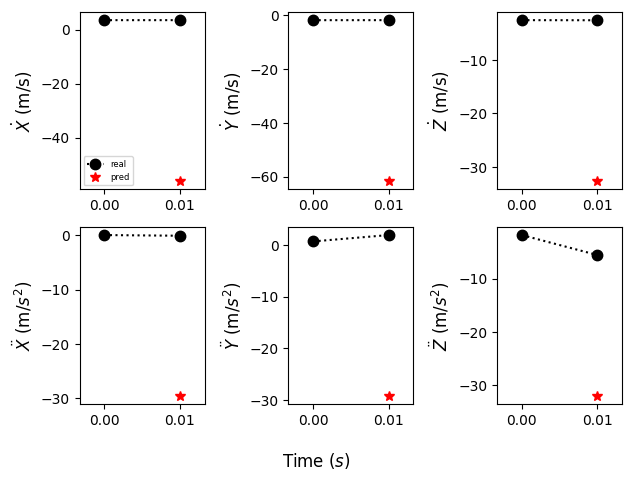

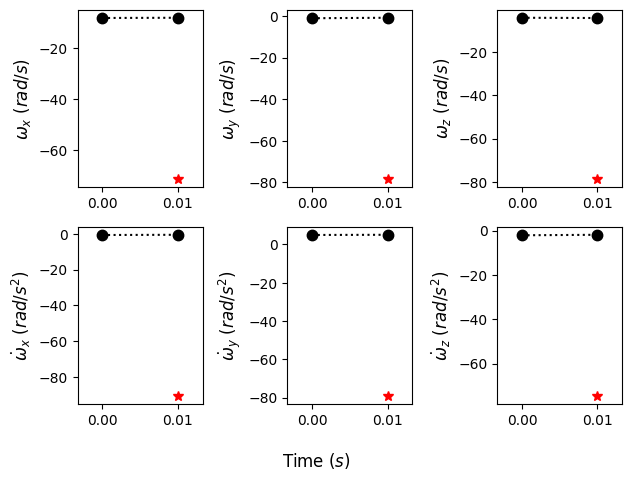

Current Batch Train Loss: 45246.09375

Current Batch Train Loss: 296.60986328125

Current Batch Train Loss: 221.53897094726562

Current Batch Train Loss: 184.48651123046875

Current Batch Train Loss: 167.99072265625

Current Batch Train Loss: 161.3516387939453

Current Batch Train Loss: 156.42689514160156

Current Batch Train Loss: 150.8623046875

Current Batch Train Loss: 151.0052947998047

Current Batch Train Loss: 146.50433349609375

Current Batch Train Loss: 141.27658081054688

Current Batch Train Loss: 140.4154815673828

Current Batch Train Loss: 143.45896911621094

Current Batch Train Loss: 142.5983428955078

Current Batch Train Loss: 135.17718505859375

Current Batch Train Loss: 136.23309326171875

Current Batch Train Loss: 136.50247192382812

Current Batch Train Loss: 136.9076385498047

Current Batch Train Loss: 142.76905822753906

Current Batch Train Loss: 137.48231506347656

Current Batch Train Loss: 132.57276916503906

Current Batch Train Loss: 135.60552978515625

Current Ba

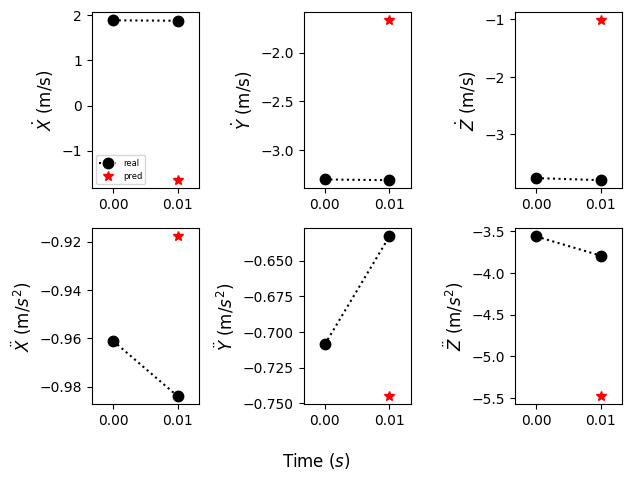

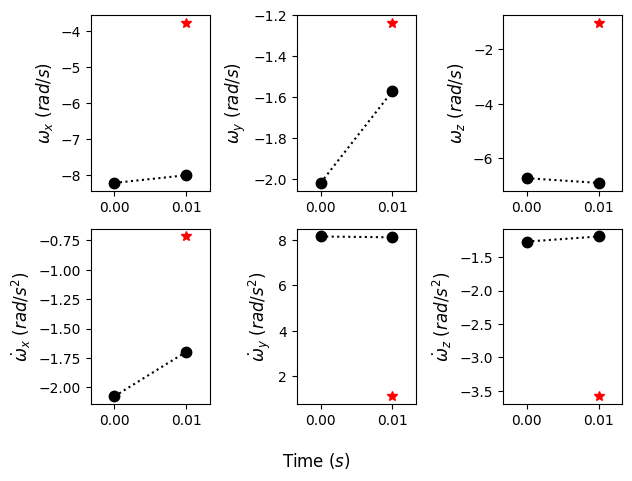

Current Batch Train Loss: 126.42601776123047

Current Batch Train Loss: 129.6202392578125

Current Batch Train Loss: 124.4538803100586

Current Batch Train Loss: 129.1214599609375

Current Batch Train Loss: 125.79080200195312

Current Batch Train Loss: 127.40898132324219

Current Batch Train Loss: 124.61739349365234

Current Batch Train Loss: 126.98235321044922

Current Batch Train Loss: 121.63816833496094

Current Batch Train Loss: 130.14903259277344

Current Batch Train Loss: 126.98784637451172

Current Batch Train Loss: 123.39921569824219

Current Batch Train Loss: 123.6624755859375

Current Batch Train Loss: 119.93073272705078

Current Batch Train Loss: 121.86558532714844

Current Batch Train Loss: 121.81673431396484

Current Batch Train Loss: 120.37718963623047

Current Batch Train Loss: 121.25645446777344

Current Batch Train Loss: 124.58516693115234

Current Batch Train Loss: 121.29838562011719

Current Batch Train Loss: 125.5047836303711

Current Batch Train Loss: 119.314804077

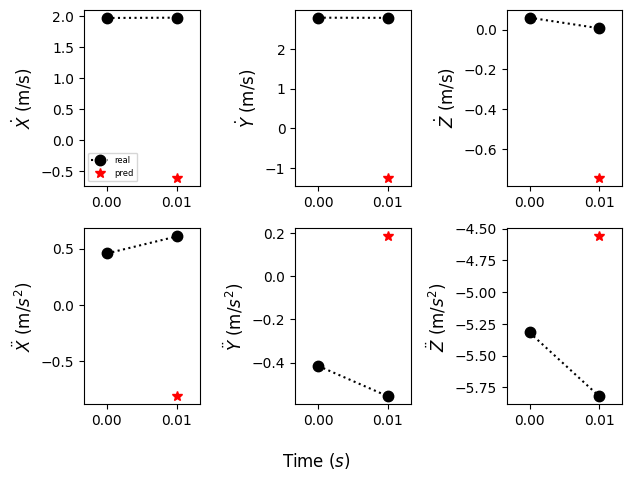

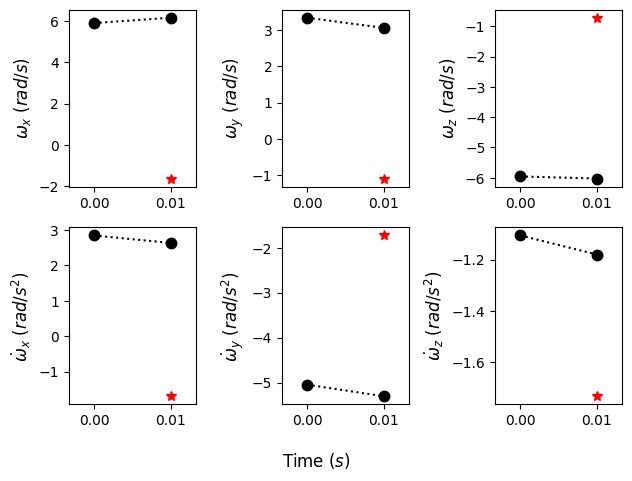

Current Batch Train Loss: 119.75597381591797

Current Batch Train Loss: 119.2212142944336

Current Batch Train Loss: 118.10884857177734

Current Batch Train Loss: 120.84680938720703

Current Batch Train Loss: 121.08023834228516

Current Batch Train Loss: 117.99629211425781

Current Batch Train Loss: 121.04132080078125

Current Batch Train Loss: 122.9358901977539

Current Batch Train Loss: 120.87450408935547

Current Batch Train Loss: 114.63867950439453

Current Batch Train Loss: 115.52847290039062

Current Batch Train Loss: 118.1139144897461

Current Batch Train Loss: 115.6368179321289

Current Batch Train Loss: 120.01817321777344

Current Batch Train Loss: 120.91993713378906

Current Batch Train Loss: 116.50798034667969

Current Batch Train Loss: 118.33853912353516

Current Batch Train Loss: 119.22163391113281

Current Batch Train Loss: 117.6491928100586

Current Batch Train Loss: 119.48614501953125

Current Batch Train Loss: 121.38771057128906

Current Batch Train Loss: 120.113227844

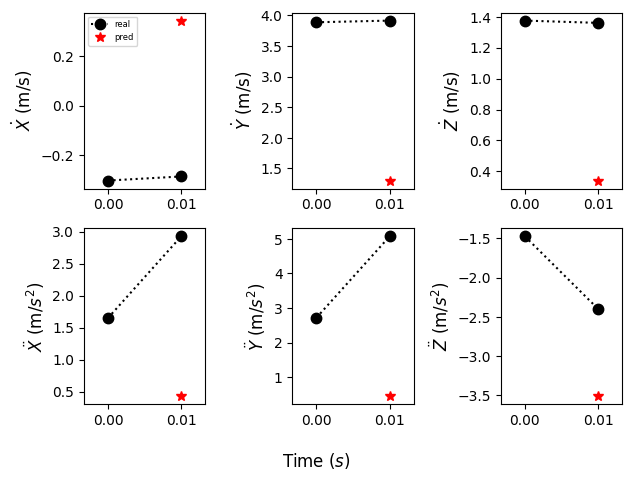

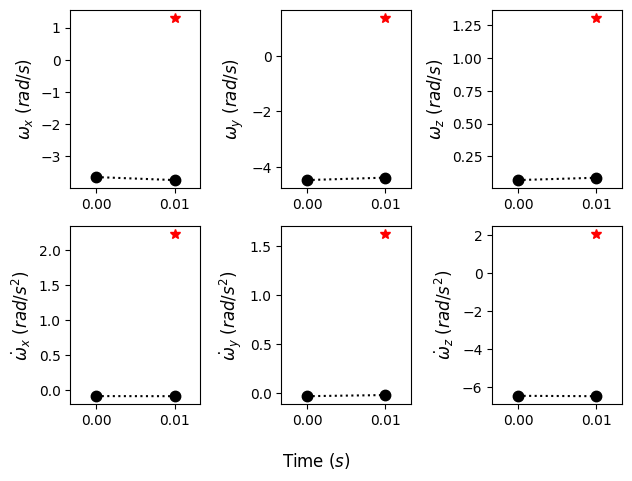

Current Batch Train Loss: 118.81790924072266

Current Batch Train Loss: 117.44275665283203

Current Batch Train Loss: 116.48993682861328

Current Batch Train Loss: 115.8030776977539

Current Batch Train Loss: 118.67760467529297

Current Batch Train Loss: 119.33977508544922

Current Batch Train Loss: 116.6918716430664

Current Batch Train Loss: 114.61048889160156

Current Batch Train Loss: 119.97090148925781

Current Batch Train Loss: 117.67182159423828

Current Batch Train Loss: 113.47748565673828

Current Batch Train Loss: 116.22921752929688

Current Batch Train Loss: 114.23796844482422

Current Batch Train Loss: 110.99636840820312

Current Batch Train Loss: 112.25469207763672

Current Batch Train Loss: 110.32254791259766

Current Batch Train Loss: 110.75743103027344

Current Batch Train Loss: 107.3505859375

Current Batch Train Loss: 109.93190002441406

Current Batch Train Loss: 107.18504333496094

Current Batch Train Loss: 109.06645202636719

Current Batch Train Loss: 106.6431427001

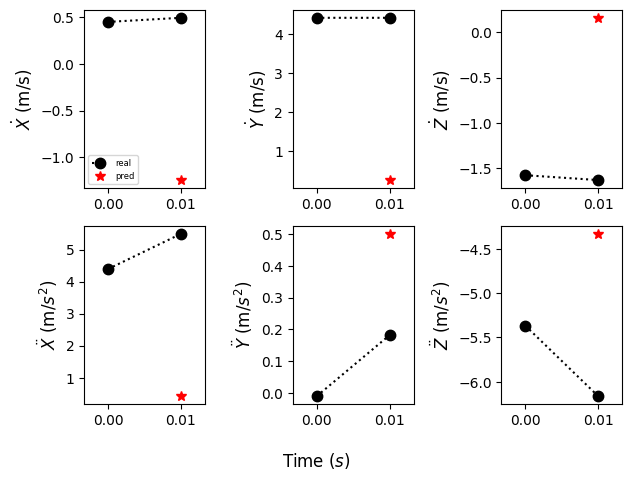

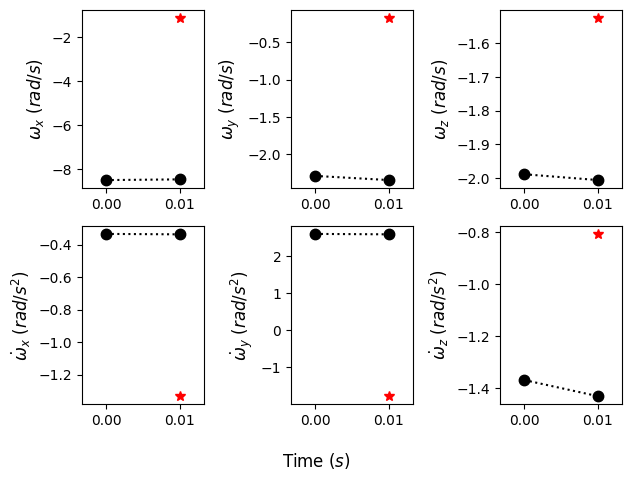

Current Batch Train Loss: 110.23372650146484

Current Batch Train Loss: 104.48221588134766

Current Batch Train Loss: 108.89447021484375

Current Batch Train Loss: 108.01874542236328

Current Batch Train Loss: 105.95034790039062

Current Batch Train Loss: 110.16513061523438

Current Batch Train Loss: 106.97811126708984

Current Batch Train Loss: 110.1019287109375

Current Batch Train Loss: 106.33403778076172

Current Batch Train Loss: 107.7664794921875

Current Batch Train Loss: 107.4881362915039

Current Batch Train Loss: 106.64657592773438

Current Batch Train Loss: 105.33514404296875

Current Batch Train Loss: 107.81086730957031

Current Batch Train Loss: 106.13116455078125

Current Batch Train Loss: 106.97911071777344

Current Batch Train Loss: 104.77877807617188

Current Batch Train Loss: 105.19098663330078

Current Batch Train Loss: 104.62874603271484

Current Batch Train Loss: 106.60464477539062

Current Batch Train Loss: 107.6745834350586

Current Batch Train Loss: 108.29615020

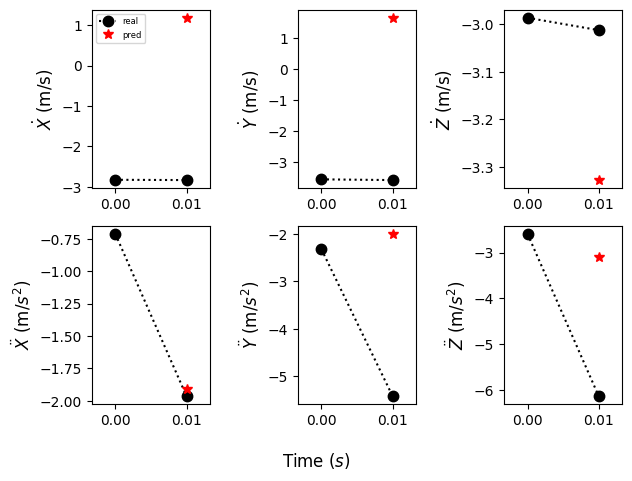

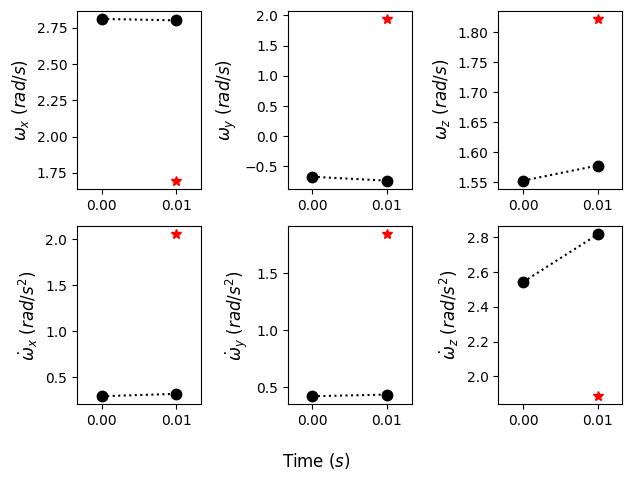

Current Batch Train Loss: 103.78897857666016

Current Batch Train Loss: 105.40756225585938

Current Batch Train Loss: 104.48921966552734

Current Batch Train Loss: 104.5622329711914

Current Batch Train Loss: 112.2306900024414

Current Batch Train Loss: 103.72314453125

Current Batch Train Loss: 105.48027801513672

Current Batch Train Loss: 109.77213287353516

Current Batch Train Loss: 104.91592407226562

Current Batch Train Loss: 106.08599853515625

Current Batch Train Loss: 105.10931396484375

Current Batch Train Loss: 104.69612884521484

Current Batch Train Loss: 107.42096710205078

Current Batch Train Loss: 109.3802261352539

Current Batch Train Loss: 104.22261047363281

Current Batch Train Loss: 103.82733154296875

Current Batch Train Loss: 105.4521255493164

Current Batch Train Loss: 104.72549438476562

Current Batch Train Loss: 104.47798156738281

Current Batch Train Loss: 103.2800064086914

Current Batch Train Loss: 104.24531555175781

Current Batch Train Loss: 102.875862121582

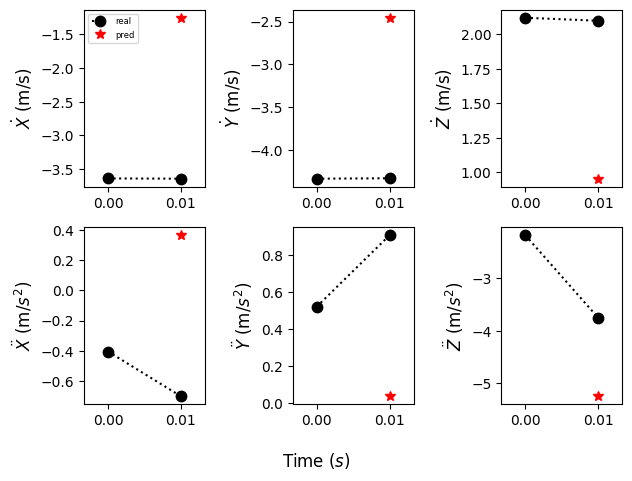

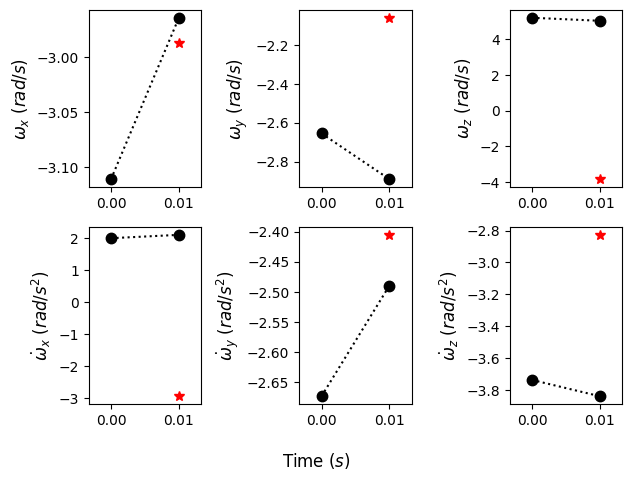

Current Batch Train Loss: 107.0264663696289

Current Batch Train Loss: 103.33869934082031

Current Batch Train Loss: 103.79097747802734

Current Batch Train Loss: 105.79396057128906

Current Batch Train Loss: 103.88220977783203

Current Batch Train Loss: 104.79490661621094

Current Batch Train Loss: 103.26577758789062

Current Batch Train Loss: 104.14983367919922

Current Batch Train Loss: 104.86336517333984

Current Batch Train Loss: 104.78087615966797

Current Batch Train Loss: 103.60586547851562

Current Batch Train Loss: 104.65962982177734

Current Batch Train Loss: 102.04358673095703

Current Batch Train Loss: 102.99185943603516

Current Batch Train Loss: 103.59356689453125

Current Batch Train Loss: 103.61820220947266

Current Batch Train Loss: 102.5871353149414

Current Batch Train Loss: 103.80011749267578

Current Batch Train Loss: 104.5949935913086

Current Batch Train Loss: 104.53593444824219

Current Batch Train Loss: 103.83152770996094

Current Batch Train Loss: 105.7564010

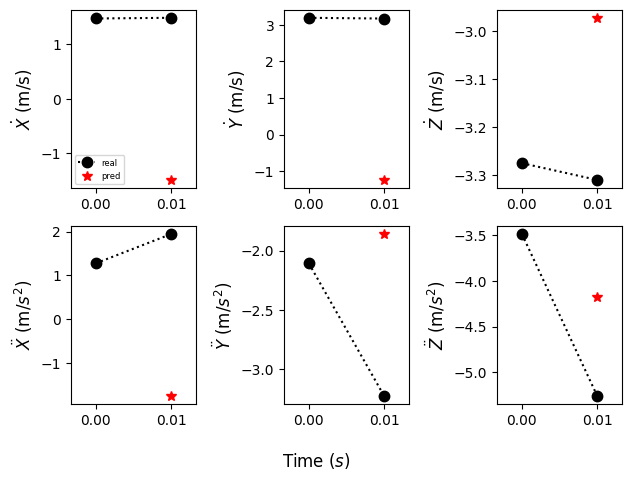

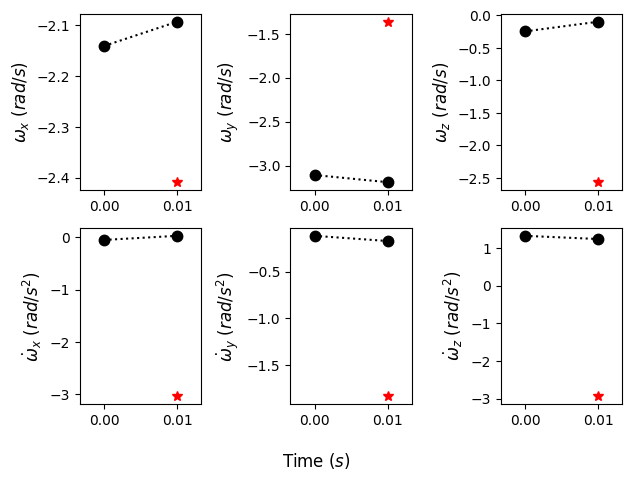

Current Batch Train Loss: 102.63429260253906

Current Batch Train Loss: 105.05361938476562

Current Batch Train Loss: 103.84396362304688

Current Batch Train Loss: 103.88408660888672

Current Batch Train Loss: 104.74365234375

Current Batch Train Loss: 104.03639221191406

Current Batch Train Loss: 104.12171936035156

Current Batch Train Loss: 104.03055572509766

Current Batch Train Loss: 103.13294219970703

Current Batch Train Loss: 103.09101104736328

Current Batch Train Loss: 104.7671890258789

Current Batch Train Loss: 100.6453857421875

Current Batch Train Loss: 101.83695983886719

Current Batch Train Loss: 103.18531799316406

Current Batch Train Loss: 101.9600601196289

Current Batch Train Loss: 103.98847961425781

Current Batch Train Loss: 99.44171142578125

Current Batch Train Loss: 100.3118667602539

Current Batch Train Loss: 102.91658020019531

Current Batch Train Loss: 101.91117858886719

Current Batch Train Loss: 102.4187240600586

Current Batch Train Loss: 103.4627304077148

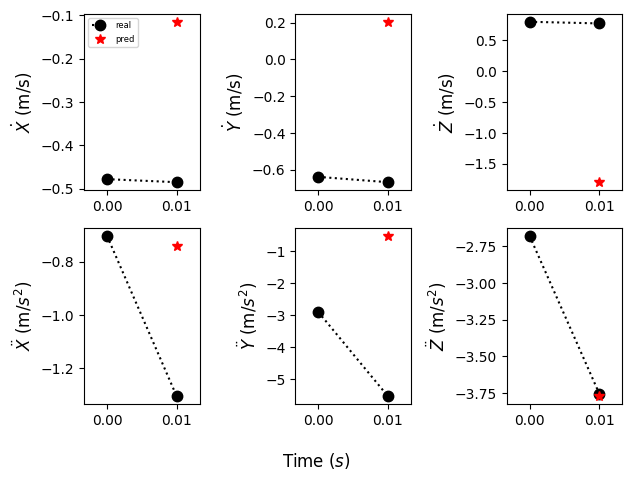

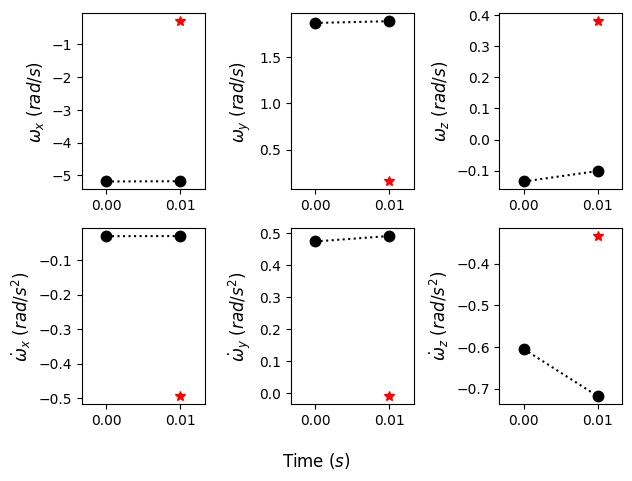

Current Batch Train Loss: 103.10553741455078

Current Batch Train Loss: 103.37950134277344

Current Batch Train Loss: 104.6734848022461

Current Batch Train Loss: 97.99423217773438

Current Batch Train Loss: 103.2354736328125

Current Batch Train Loss: 103.83692932128906

Current Batch Train Loss: 100.31266021728516

Current Batch Train Loss: 102.5185775756836

Current Batch Train Loss: 105.74613952636719

Current Batch Train Loss: 104.43677520751953

Current Batch Train Loss: 102.73745727539062

Current Batch Train Loss: 102.38457489013672

Current Batch Train Loss: 100.53527069091797

Current Batch Train Loss: 103.06281280517578

Current Batch Train Loss: 102.3458251953125

Current Batch Train Loss: 100.29698181152344

Current Batch Train Loss: 101.15330505371094

Current Batch Train Loss: 101.35350799560547

Current Batch Train Loss: 100.59037017822266

Current Batch Train Loss: 100.48186492919922

Current Batch Train Loss: 101.3170394897461

Current Batch Train Loss: 101.0301971435

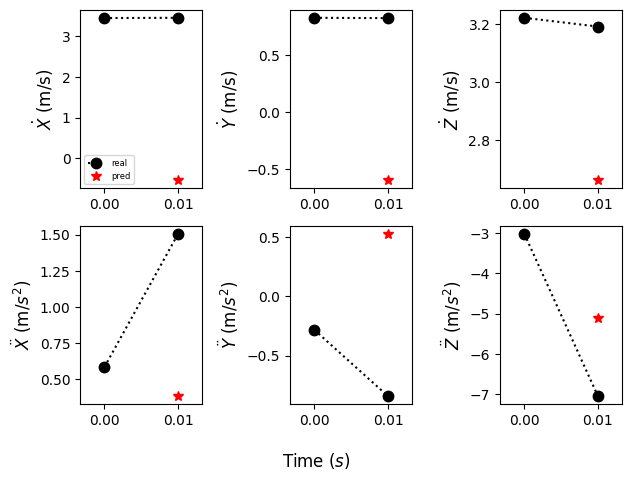

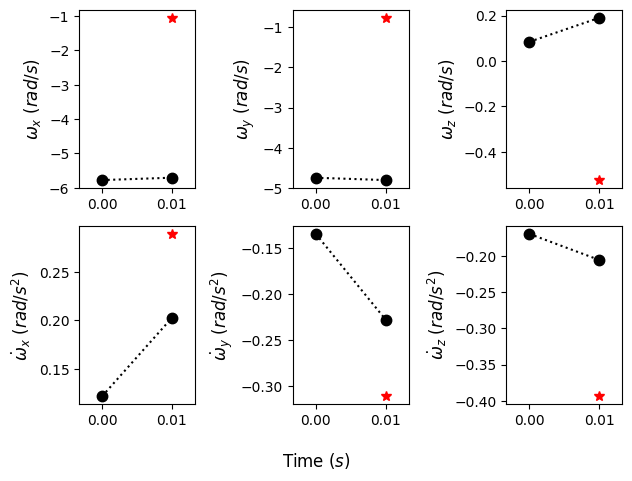

Current Batch Train Loss: 103.298095703125

Current Batch Train Loss: 102.50850677490234

Current Batch Train Loss: 102.27467346191406

Current Batch Train Loss: 101.56693267822266

Current Batch Train Loss: 102.93904876708984

Current Batch Train Loss: 99.6756591796875

Current Batch Train Loss: 99.53189086914062

Current Batch Train Loss: 102.9295883178711

Current Batch Train Loss: 103.17378234863281

Current Batch Train Loss: 101.9653091430664

Current Batch Train Loss: 101.79977416992188

Current Batch Train Loss: 103.01795196533203

Current Batch Train Loss: 98.30155944824219

Current Batch Train Loss: 98.9574966430664

Current Batch Train Loss: 101.30244445800781

Current Batch Train Loss: 100.68036651611328

Current Batch Train Loss: 98.51130676269531

Current Batch Train Loss: 100.18354034423828

Current Batch Train Loss: 102.27224731445312

Current Batch Train Loss: 101.0663070678711

Current Batch Train Loss: 101.60313415527344

Current Batch Train Loss: 101.98408508300781



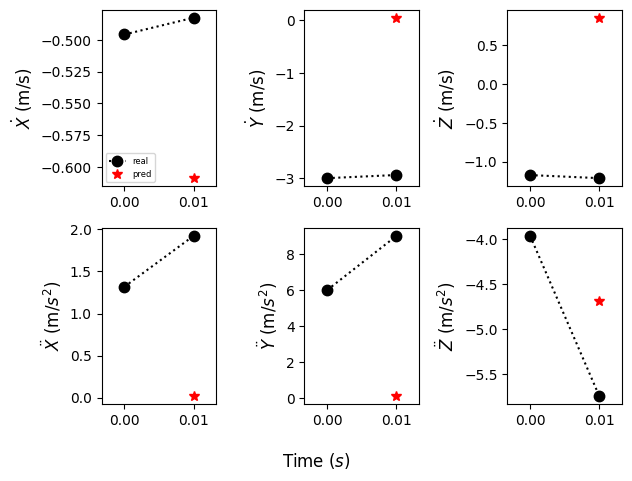

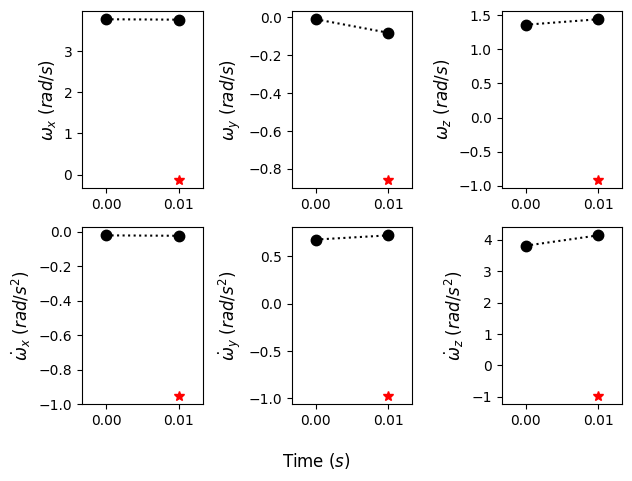

Current Batch Train Loss: 99.4518051147461

Current Batch Train Loss: 101.66300964355469

Current Batch Train Loss: 101.0511703491211

Current Batch Train Loss: 103.0032730102539

Current Batch Train Loss: 102.96052551269531

Current Batch Train Loss: 101.11236572265625

Current Batch Train Loss: 102.34285736083984

Current Batch Train Loss: 101.60737609863281

Current Batch Train Loss: 103.84561157226562

Current Batch Train Loss: 102.41534423828125

Current Batch Train Loss: 103.36386108398438

Current Batch Train Loss: 99.94309997558594

Current Batch Train Loss: 100.98944854736328

Current Batch Train Loss: 103.27303314208984

Current Batch Train Loss: 100.60958862304688

Current Batch Train Loss: 99.64628601074219

Current Batch Train Loss: 101.40863800048828

Current Batch Train Loss: 101.49993133544922

Current Batch Train Loss: 100.23567962646484

Current Batch Train Loss: 103.228271484375

Current Batch Train Loss: 101.89350128173828

Current Batch Train Loss: 104.197517395019

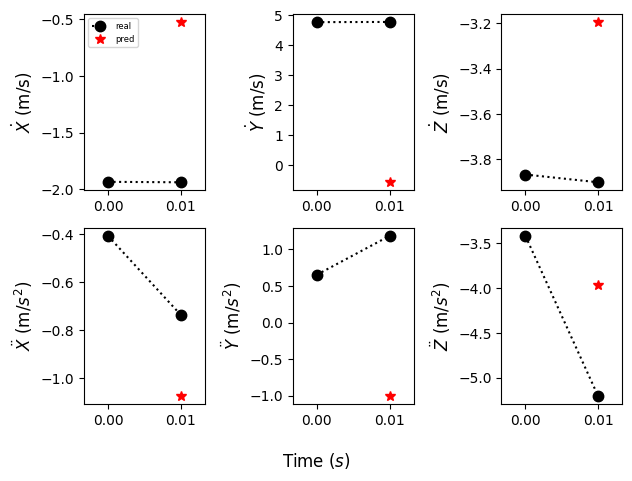

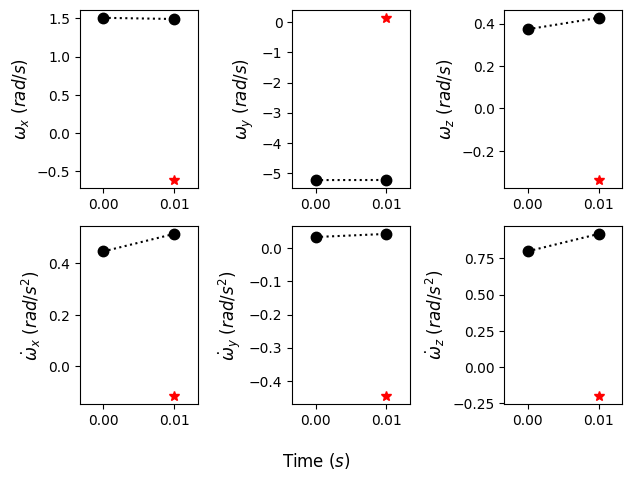

Current Batch Train Loss: 97.50022888183594

Current Batch Train Loss: 101.29816436767578

Current Batch Train Loss: 98.97578430175781

Current Batch Train Loss: 100.8916015625

Current Batch Train Loss: 100.39202117919922

Current Batch Train Loss: 100.12671661376953

Current Batch Train Loss: 104.11943054199219

Current Batch Train Loss: 101.37744140625

Current Batch Train Loss: 98.21613311767578

Current Batch Train Loss: 102.17548370361328

Current Batch Train Loss: 99.46377563476562

Current Batch Train Loss: 101.6060562133789

Current Batch Train Loss: 101.37464141845703

Current Batch Train Loss: 102.10176849365234

Current Batch Train Loss: 99.95426177978516

Current Batch Train Loss: 100.36180877685547

Current Batch Train Loss: 102.54255676269531

Current Batch Train Loss: 101.7928466796875

Current Batch Train Loss: 100.40867614746094

Current Batch Train Loss: 101.965087890625

Current Batch Train Loss: 103.40118408203125

Current Batch Train Loss: 97.75936126708984

Curre

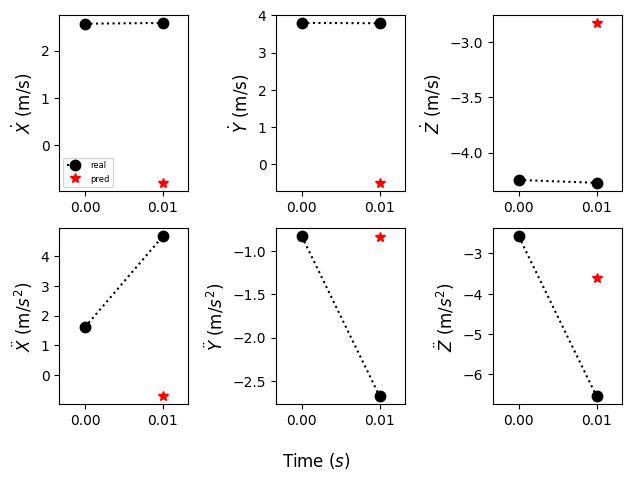

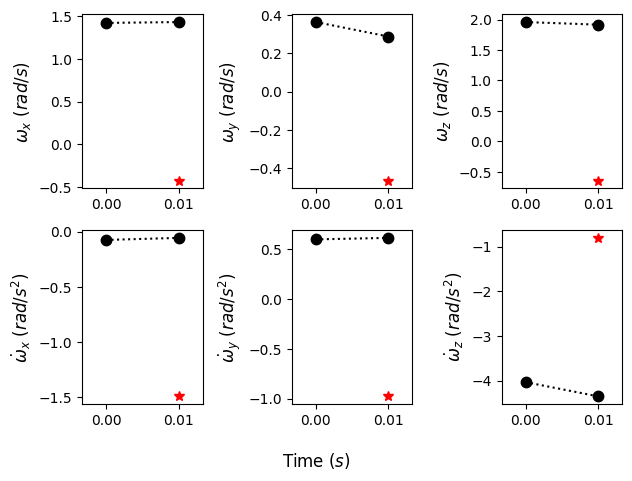

Current Batch Train Loss: 100.57159423828125

Current Batch Train Loss: 103.57418060302734

Current Batch Train Loss: 103.46307373046875

Current Batch Train Loss: 101.22666931152344

Current Batch Train Loss: 102.07389831542969

Current Batch Train Loss: 100.18217468261719

Current Batch Train Loss: 100.656982421875

Current Batch Train Loss: 101.13542175292969

Current Batch Train Loss: 101.40957641601562

Current Batch Train Loss: 99.73165893554688

Current Batch Train Loss: 97.88219451904297

Current Batch Train Loss: 99.3938980102539

Current Batch Train Loss: 98.03752136230469

Current Batch Train Loss: 101.8055648803711

Current Batch Train Loss: 100.59418487548828

Current Batch Train Loss: 99.10060119628906

Current Batch Train Loss: 101.21424102783203

Current Batch Train Loss: 99.68070220947266

Current Batch Train Loss: 101.97280883789062

Current Batch Train Loss: 100.19700622558594

Current Batch Train Loss: 100.94256591796875

Current Batch Train Loss: 100.409423828125



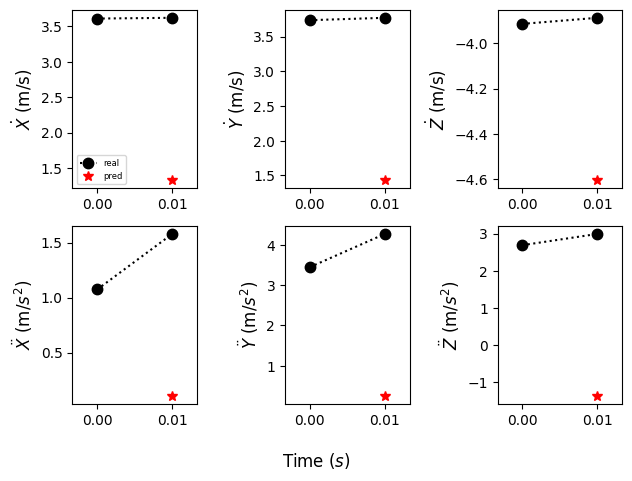

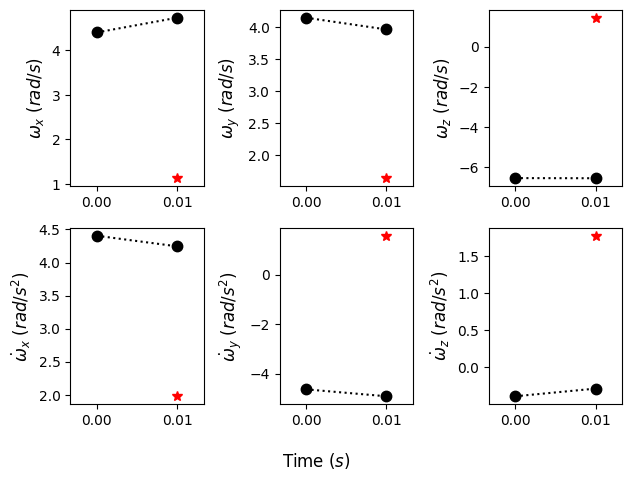

Current Batch Train Loss: 102.37940216064453

Current Batch Train Loss: 98.42755889892578

Current Batch Train Loss: 97.94210815429688

Current Batch Train Loss: 98.40780639648438

Current Batch Train Loss: 100.66305541992188

Current Batch Train Loss: 99.55046844482422

Current Batch Train Loss: 99.731201171875

Current Batch Train Loss: 99.07190704345703

Current Batch Train Loss: 102.09414672851562

Current Batch Train Loss: 98.22896575927734

Current Batch Train Loss: 102.68292236328125

Current Batch Train Loss: 99.8321304321289

Current Batch Train Loss: 98.71306610107422

Current Batch Train Loss: 101.61459350585938

Current Batch Train Loss: 99.2148208618164

Current Batch Train Loss: 101.22561645507812

Current Batch Train Loss: 104.67530059814453

Current Batch Train Loss: 98.52792358398438

Current Batch Train Loss: 99.12571716308594

Current Batch Train Loss: 100.32460021972656

Current Batch Train Loss: 99.0337905883789

Current Batch Train Loss: 98.9724349975586

Current 

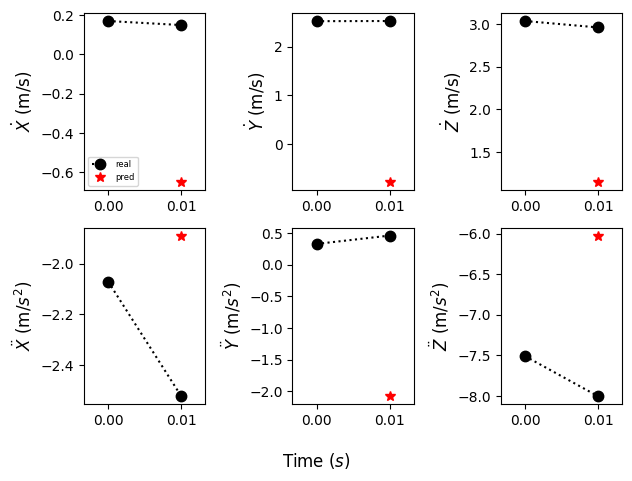

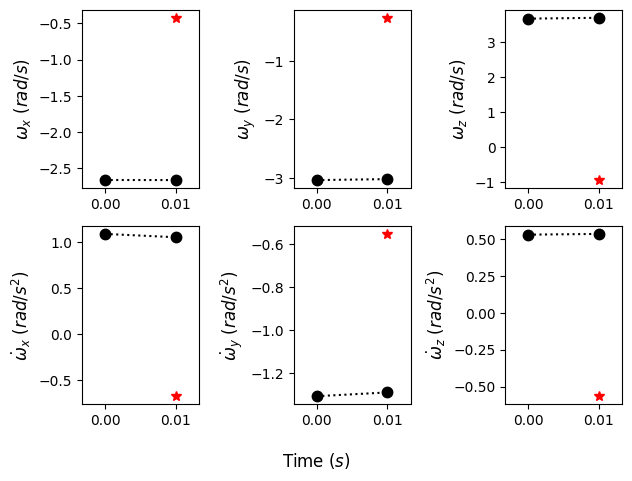

Current Batch Train Loss: 94.99852752685547

Current Batch Train Loss: 92.79944610595703

Current Batch Train Loss: 92.76805114746094

Current Batch Train Loss: 94.47123718261719

Current Batch Train Loss: 92.43073272705078

Current Batch Train Loss: 92.82975769042969

Current Batch Train Loss: 91.93407440185547

Current Batch Train Loss: 93.3643798828125

Current Batch Train Loss: 95.56396484375

Current Batch Train Loss: 91.31031799316406

Current Batch Train Loss: 90.18570709228516

Current Batch Train Loss: 94.86711120605469

Current Batch Train Loss: 94.02601623535156

Current Batch Train Loss: 93.16822814941406

Current Batch Train Loss: 90.90367889404297

Current Batch Train Loss: 93.89857482910156

Current Batch Train Loss: 91.32617950439453

Current Batch Train Loss: 92.24325561523438

Current Batch Train Loss: 90.82628631591797

Current Batch Train Loss: 95.16686248779297

Current Batch Train Loss: 93.20414733886719

Current Batch Train Loss: 91.72549438476562

Current Batch 

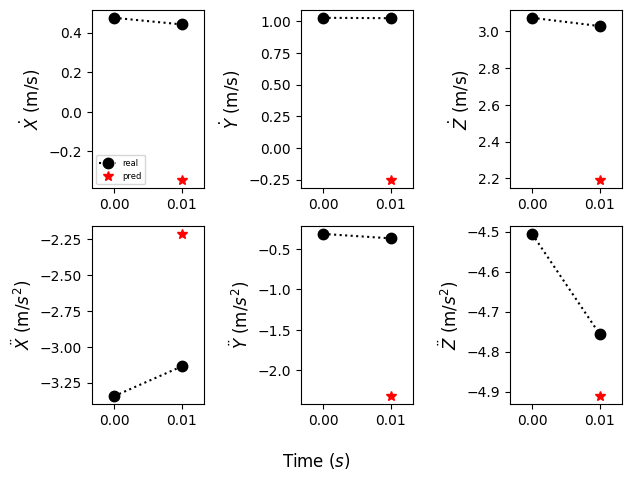

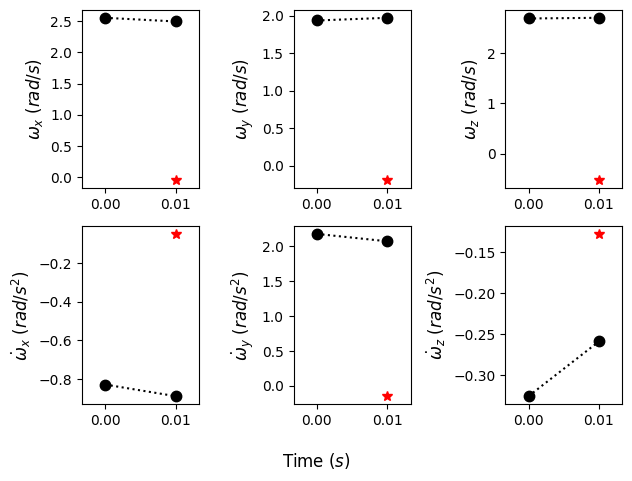

Current Batch Train Loss: 92.9126968383789

Current Batch Train Loss: 90.68057250976562

Current Batch Train Loss: 91.41653442382812

Current Batch Train Loss: 93.96223449707031

Current Batch Train Loss: 90.16914367675781

Current Batch Train Loss: 90.20478057861328

Current Batch Train Loss: 92.36241149902344

Current Batch Train Loss: 90.08448028564453

Current Batch Train Loss: 93.44187927246094

Current Batch Train Loss: 90.60450744628906

Current Batch Train Loss: 92.19532775878906

Current Batch Train Loss: 91.08424377441406

Current Batch Train Loss: 92.50225067138672

Current Batch Train Loss: 92.23490142822266

Current Batch Train Loss: 90.51779174804688

Current Batch Train Loss: 92.37183380126953

Current Batch Train Loss: 93.01659393310547

Current Batch Train Loss: 92.61060333251953

Current Batch Train Loss: 92.79126739501953

Current Batch Train Loss: 91.91402435302734

Current Batch Train Loss: 91.92816925048828

Current Batch Train Loss: 89.15630340576172

Current Bat

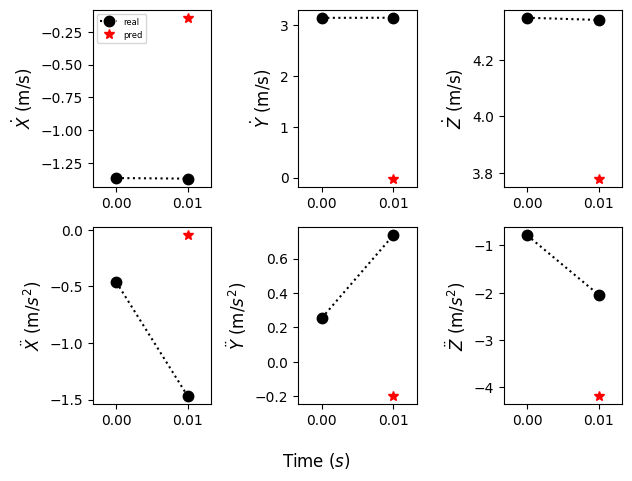

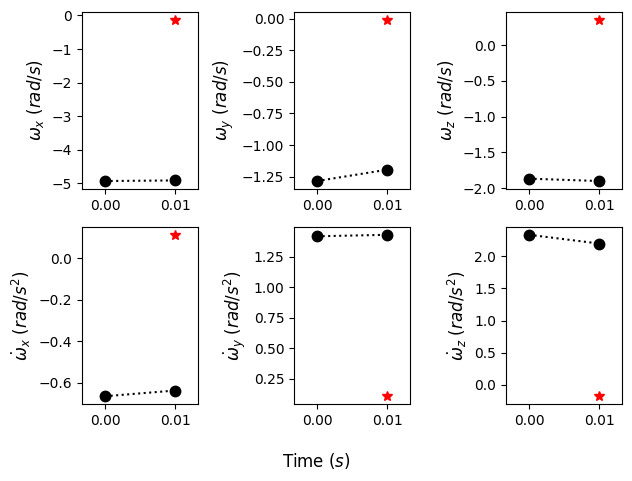

Current Batch Train Loss: 94.8668441772461

Current Batch Train Loss: 90.99276733398438

Current Batch Train Loss: 90.73680877685547

Current Batch Train Loss: 90.57633209228516

Current Batch Train Loss: 93.02825927734375

Current Batch Train Loss: 93.470458984375

Current Batch Train Loss: 90.115966796875

Current Batch Train Loss: 91.31278991699219

Current Batch Train Loss: 93.71993255615234

Current Batch Train Loss: 92.67095184326172

Current Batch Train Loss: 93.77642822265625

Current Batch Train Loss: 90.31427764892578

Current Batch Train Loss: 90.42488861083984

Current Batch Train Loss: 88.50777435302734

Current Batch Train Loss: 91.19222259521484

Current Batch Train Loss: 92.36653900146484

Current Batch Train Loss: 88.0200424194336

Current Batch Train Loss: 89.56949615478516

Current Batch Train Loss: 93.23560333251953

Current Batch Train Loss: 91.29142761230469

Current Batch Train Loss: 91.51443481445312

Current Batch Train Loss: 92.29270935058594

Current Batch Tr

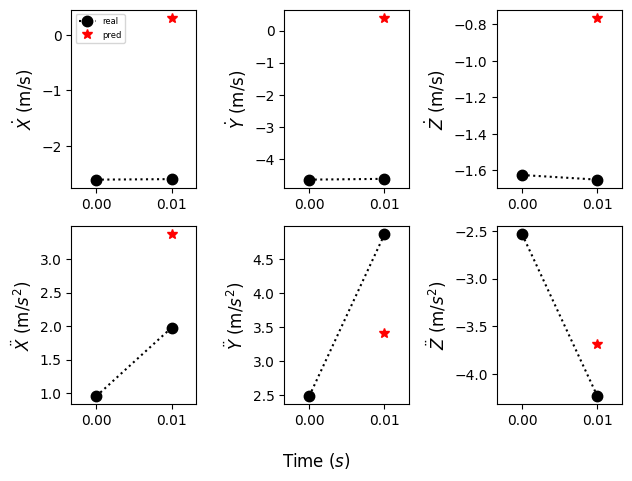

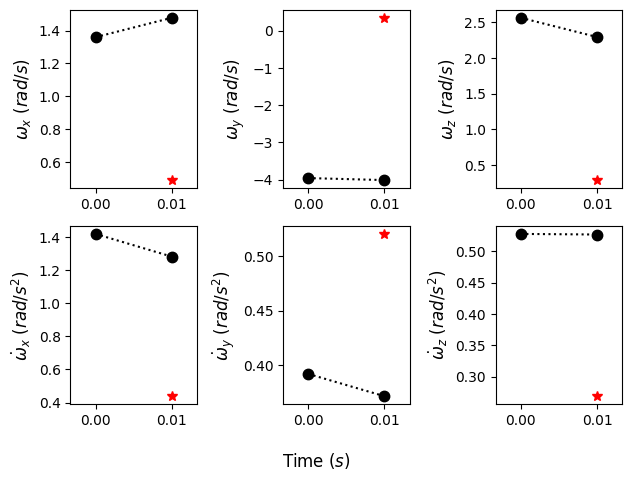

Current Batch Train Loss: 91.44498443603516

Current Batch Train Loss: 91.03665924072266

Current Batch Train Loss: 91.7546615600586

Current Batch Train Loss: 93.46630096435547

Current Batch Train Loss: 93.09297943115234

Current Batch Train Loss: 89.13668823242188

Current Batch Train Loss: 90.58690643310547

Current Batch Train Loss: 91.39958953857422

Current Batch Train Loss: 91.86763000488281

Current Batch Train Loss: 90.7027587890625

Current Batch Train Loss: 91.71531677246094

Current Batch Train Loss: 93.97394561767578

Current Batch Train Loss: 89.8407211303711

Current Batch Train Loss: 91.13772583007812

Current Batch Train Loss: 89.5774154663086

Current Batch Train Loss: 89.63526153564453

Current Batch Train Loss: 90.63679504394531

Current Batch Train Loss: 90.83018493652344

Current Batch Train Loss: 90.92743682861328

Current Batch Train Loss: 90.48997497558594

Current Batch Train Loss: 88.2682876586914

Current Batch Train Loss: 91.23885345458984

Current Batch T

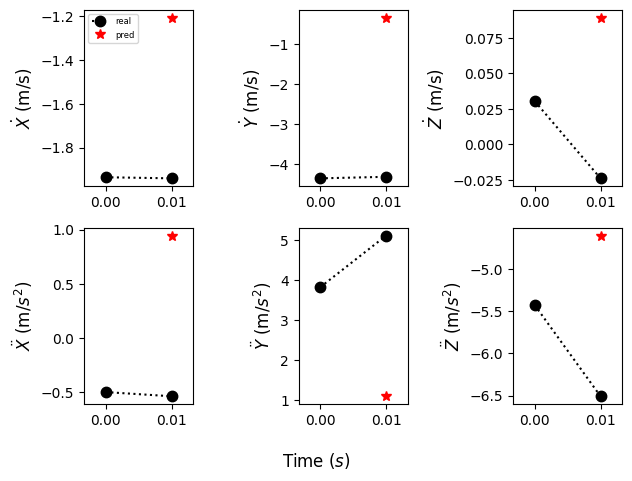

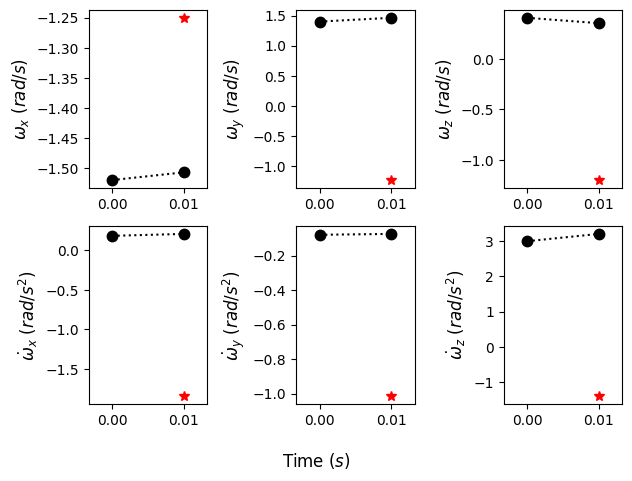

Current Batch Train Loss: 90.83793640136719

Current Batch Train Loss: 90.97926330566406

Current Batch Train Loss: 90.57815551757812

Current Batch Train Loss: 89.35782623291016

Current Batch Train Loss: 89.85279083251953

Current Batch Train Loss: 88.7771224975586

Current Batch Train Loss: 90.74395751953125

Current Batch Train Loss: 90.96774291992188

Current Batch Train Loss: 94.19950866699219

Current Batch Train Loss: 90.34600830078125

Current Batch Train Loss: 90.53723907470703

Current Batch Train Loss: 89.9874496459961

Current Batch Train Loss: 93.7872543334961

Current Batch Train Loss: 91.8534927368164

Current Batch Train Loss: 90.54325103759766

Current Batch Train Loss: 90.52839660644531

Current Batch Train Loss: 88.55709838867188

Current Batch Train Loss: 90.73168182373047

Current Batch Train Loss: 89.2750244140625

Current Batch Train Loss: 91.4209976196289

Current Batch Train Loss: 92.90221405029297

Current Batch Train Loss: 89.60505676269531

Current Batch Tr

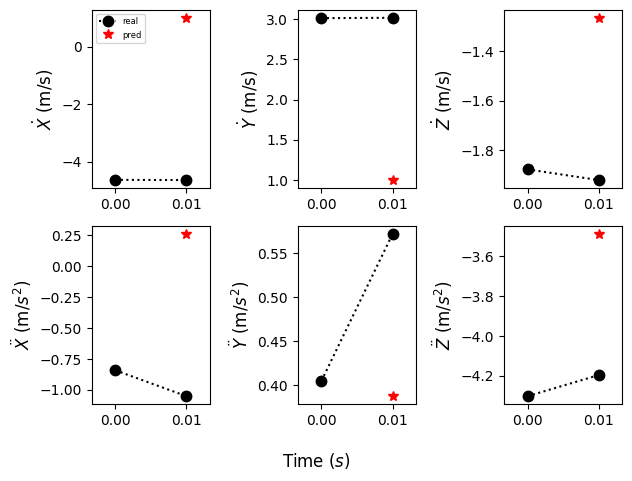

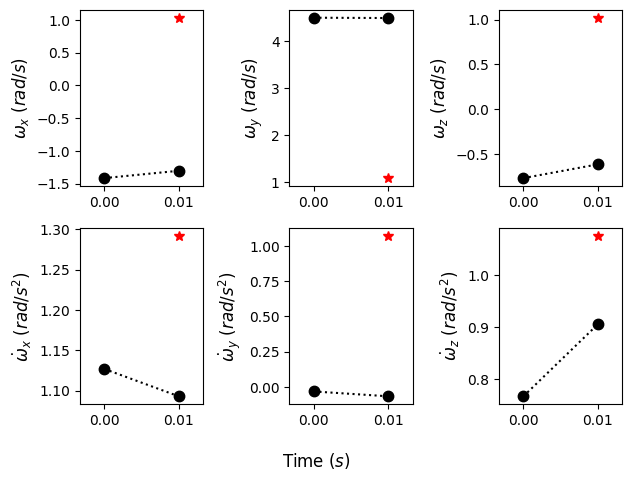

Current Batch Train Loss: 90.3392333984375

Current Batch Train Loss: 90.14962005615234

Current Batch Train Loss: 88.62145233154297

Current Batch Train Loss: 87.85124206542969

Current Batch Train Loss: 88.6887435913086

Current Batch Train Loss: 88.04381561279297

Current Batch Train Loss: 90.72772979736328

Current Batch Train Loss: 88.38430786132812

Current Batch Train Loss: 90.43756866455078

Current Batch Train Loss: 92.20745849609375

Current Batch Train Loss: 87.89570617675781

Current Batch Train Loss: 92.73815155029297

Current Batch Train Loss: 89.49091339111328

Current Batch Train Loss: 90.37682342529297

Current Batch Train Loss: 89.2908706665039

Current Batch Train Loss: 90.3994140625

Current Batch Train Loss: 91.3899154663086

Current Batch Train Loss: 91.55009460449219

Current Batch Train Loss: 90.25740814208984

Current Batch Train Loss: 88.92471313476562

Current Batch Train Loss: 90.83818817138672

Current Batch Train Loss: 90.63075256347656

Current Batch Trai

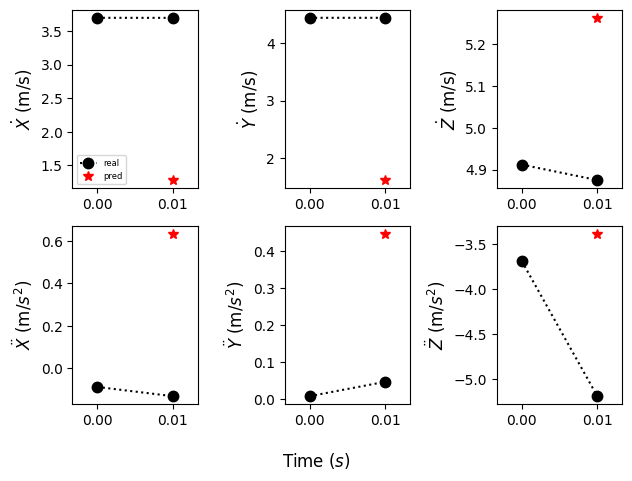

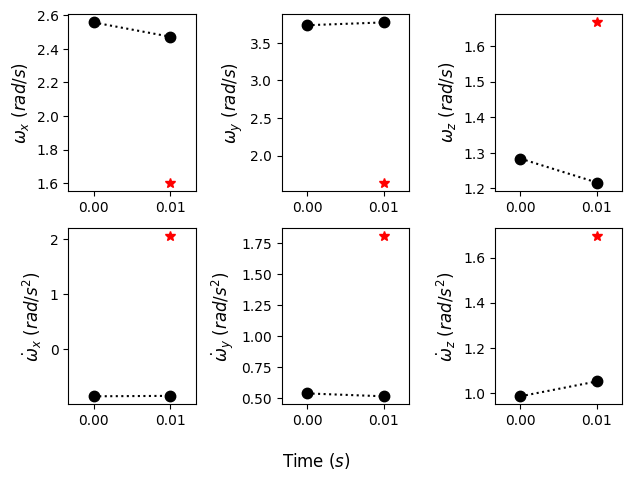

Current Batch Train Loss: 90.38667297363281

Current Batch Train Loss: 90.48857879638672

Current Batch Train Loss: 90.7331771850586

Current Batch Train Loss: 89.6080322265625

Current Batch Train Loss: 88.038330078125

Current Batch Train Loss: 88.58486938476562

Current Batch Train Loss: 89.41401672363281

Current Batch Train Loss: 89.74463653564453

Current Batch Train Loss: 89.33476257324219

Current Batch Train Loss: 91.09053802490234

Current Batch Train Loss: 90.9495849609375

Current Batch Train Loss: 90.62909698486328

Current Batch Train Loss: 89.91876983642578

Current Batch Train Loss: 88.15351104736328

Current Batch Train Loss: 88.44480895996094

Current Batch Train Loss: 88.90409088134766

Current Batch Train Loss: 91.34957122802734

Current Batch Train Loss: 91.18102264404297

Current Batch Train Loss: 87.84764862060547

Current Batch Train Loss: 90.02154541015625

Current Batch Train Loss: 90.17790985107422

Current Batch Train Loss: 91.49047088623047

Current Batch T

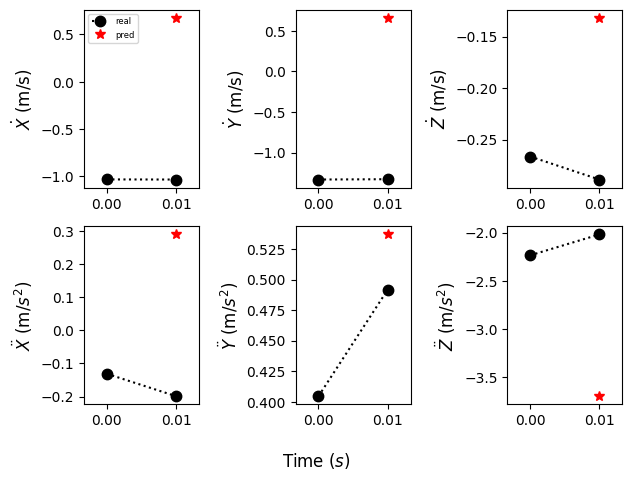

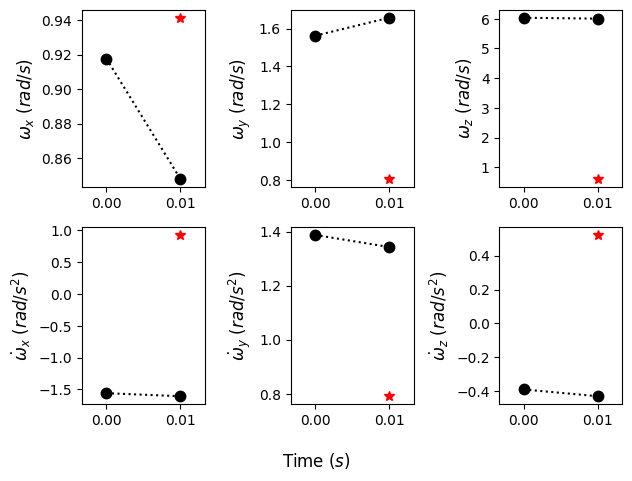

Current Batch Train Loss: 89.40995788574219

Current Batch Train Loss: 91.94148254394531

Current Batch Train Loss: 88.91203308105469

Current Batch Train Loss: 89.29251098632812

Current Batch Train Loss: 89.64051055908203

Current Batch Train Loss: 89.45177459716797

Current Batch Train Loss: 89.37162780761719

Current Batch Train Loss: 87.13282012939453

Current Batch Train Loss: 89.24729919433594

Current Batch Train Loss: 90.566162109375

Current Batch Train Loss: 92.07106018066406

Current Batch Train Loss: 89.41238403320312

Current Batch Train Loss: 88.61975860595703

Current Batch Train Loss: 91.37431335449219

Current Batch Train Loss: 92.96637725830078

Current Batch Train Loss: 88.6648941040039

Current Batch Train Loss: 90.56126403808594

Current Batch Train Loss: 91.42274475097656

Current Batch Train Loss: 87.78815460205078

Current Batch Train Loss: 90.29486083984375

Current Batch Train Loss: 90.71177673339844

Current Batch Train Loss: 89.4754409790039

Current Batch 

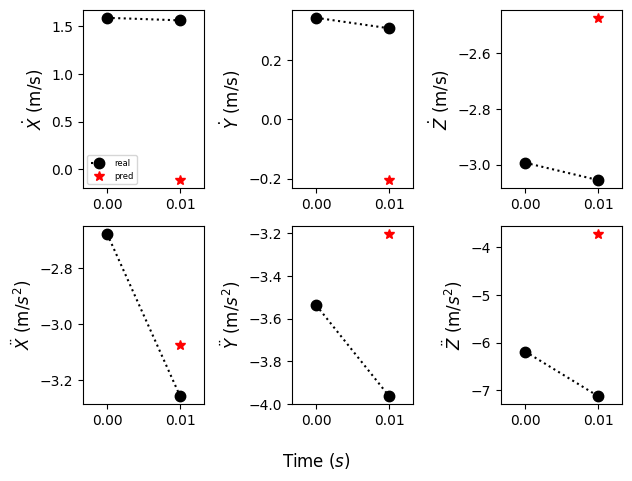

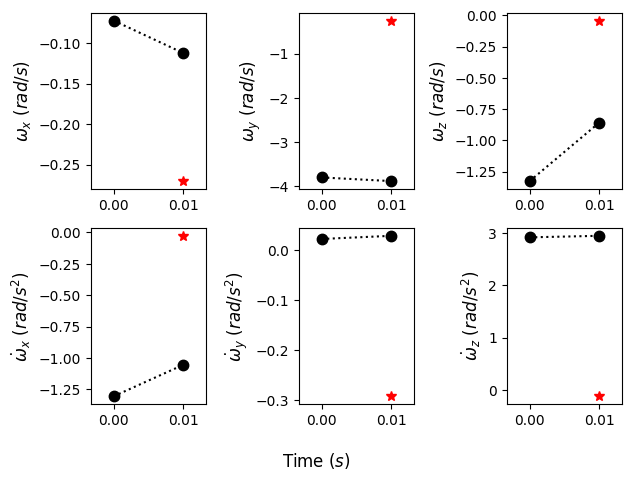

Current Batch Train Loss: 89.85800170898438

Current Batch Train Loss: 92.51270294189453

Current Batch Train Loss: 90.48145294189453

Current Batch Train Loss: 91.89672088623047

Current Batch Train Loss: 91.01263427734375

Current Batch Train Loss: 88.5313949584961

Current Batch Train Loss: 90.72175598144531

Current Batch Train Loss: 86.03877258300781

Current Batch Train Loss: 89.98408508300781

Current Batch Train Loss: 89.23112487792969

Current Batch Train Loss: 87.78599548339844

Current Batch Train Loss: 90.22943878173828

Current Batch Train Loss: 88.07828521728516

Current Batch Train Loss: 87.2721176147461

Current Batch Train Loss: 88.09215545654297

Current Batch Train Loss: 88.49437713623047

Current Batch Train Loss: 87.51008605957031

Current Batch Train Loss: 91.95784759521484

Current Batch Train Loss: 91.52157592773438

Current Batch Train Loss: 90.40354919433594

Current Batch Train Loss: 88.37049102783203

Current Batch Train Loss: 88.81304931640625

Current Batc

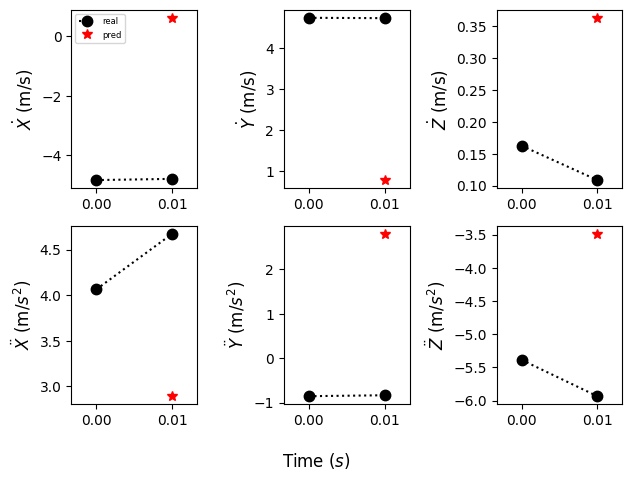

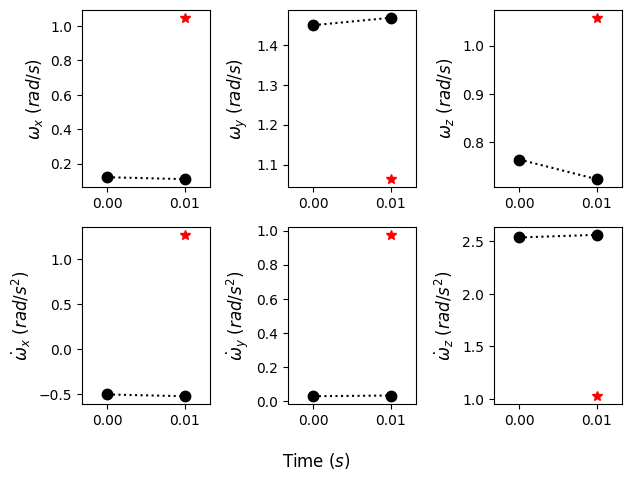

Current Batch Train Loss: 93.01344299316406

Current Batch Train Loss: 89.12532043457031

Current Batch Train Loss: 89.7618637084961

Current Batch Train Loss: 88.53116607666016

Current Batch Train Loss: 88.94454193115234

Current Batch Train Loss: 90.26421356201172

Current Batch Train Loss: 88.45668029785156

Current Batch Train Loss: 89.38967895507812

Current Batch Train Loss: 90.1822280883789

Current Batch Train Loss: 88.94989776611328

Current Batch Train Loss: 86.7215576171875

Current Batch Train Loss: 90.00849151611328

Current Batch Train Loss: 92.5506362915039

Current Batch Train Loss: 88.78691101074219

Current Batch Train Loss: 88.1006088256836

Current Batch Train Loss: 91.21250915527344

Current Batch Train Loss: 90.30268859863281

Current Batch Train Loss: 89.26483917236328

Current Batch Train Loss: 85.73277282714844

Current Batch Train Loss: 87.627685546875

Current Batch Train Loss: 91.07972717285156

Current Batch Train Loss: 90.33008575439453

Current Batch Tra

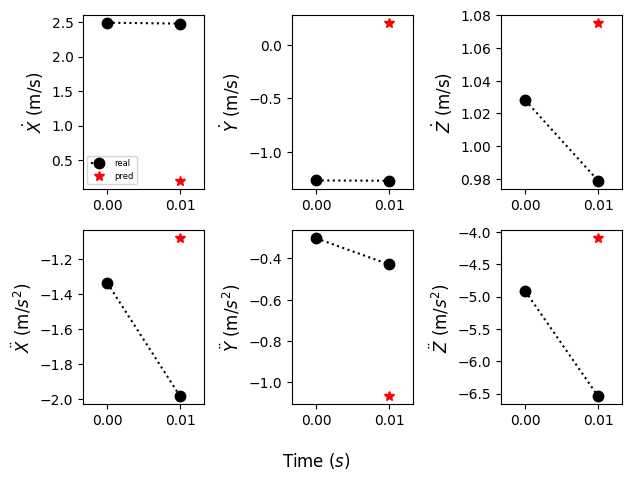

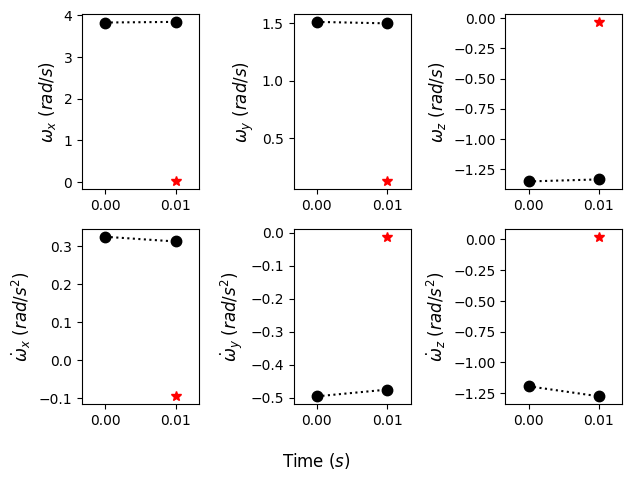

Current Batch Train Loss: 91.67621612548828

Current Batch Train Loss: 88.41633605957031

Current Batch Train Loss: 88.1418228149414

Current Batch Train Loss: 92.95568084716797

Current Batch Train Loss: 87.3991928100586

Current Batch Train Loss: 89.33611297607422

Current Batch Train Loss: 87.05560302734375

Current Batch Train Loss: 89.3326187133789

Current Batch Train Loss: 86.9404067993164

Current Batch Train Loss: 87.58099365234375

Current Batch Train Loss: 89.00584411621094

Current Batch Train Loss: 87.447509765625

Current Batch Train Loss: 88.52361297607422

Current Batch Train Loss: 87.43131256103516

Current Batch Train Loss: 87.93366241455078

Current Batch Train Loss: 88.64606475830078

Current Batch Train Loss: 89.58627319335938

Current Batch Train Loss: 90.48612976074219

Current Batch Train Loss: 87.82886505126953

Current Batch Train Loss: 90.58516693115234

Current Batch Train Loss: 87.0219955444336

Current Batch Train Loss: 89.95681762695312

Current Batch Tra

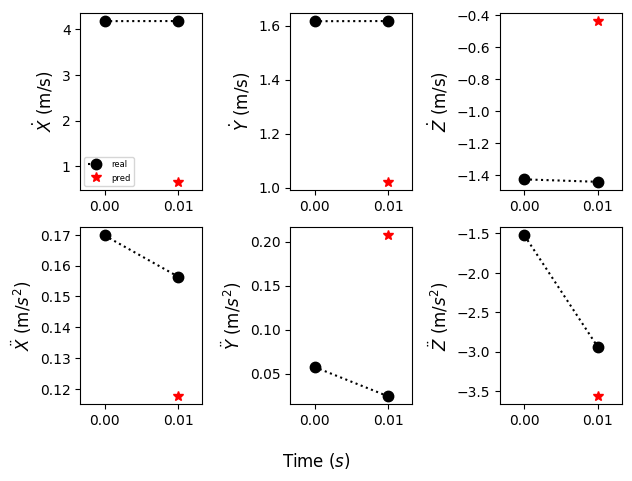

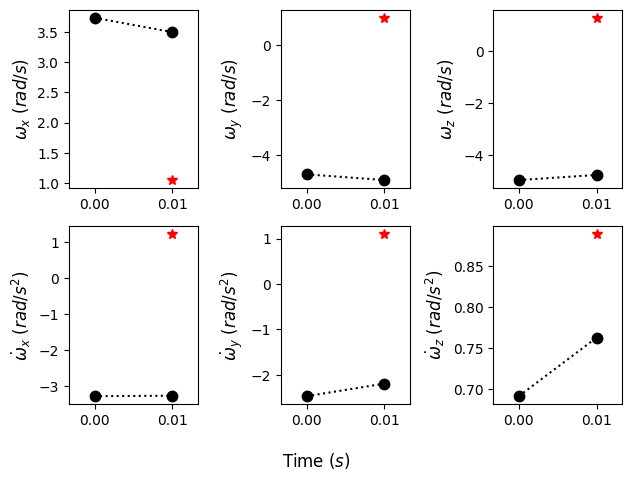

Current Batch Train Loss: 89.24061584472656

Current Batch Train Loss: 85.30730438232422

Current Batch Train Loss: 88.06600189208984

Current Batch Train Loss: 86.58185577392578

Current Batch Train Loss: 89.11905670166016

Current Batch Train Loss: 87.6372299194336

Current Batch Train Loss: 87.7216796875

Current Batch Train Loss: 89.35809326171875

Current Batch Train Loss: 87.48963928222656

Current Batch Train Loss: 89.8865966796875

Current Batch Train Loss: 87.47267150878906

Current Batch Train Loss: 89.05789947509766

Current Batch Train Loss: 90.2450180053711

Current Batch Train Loss: 90.28807830810547

Current Batch Train Loss: 88.83537292480469

Current Batch Train Loss: 90.0619888305664

Current Batch Train Loss: 88.97806549072266

Current Batch Train Loss: 88.69271087646484

Current Batch Train Loss: 87.65257263183594

Current Batch Train Loss: 86.2572250366211

Current Batch Train Loss: 86.84485626220703

Current Batch Train Loss: 88.55524444580078

Current Batch Train

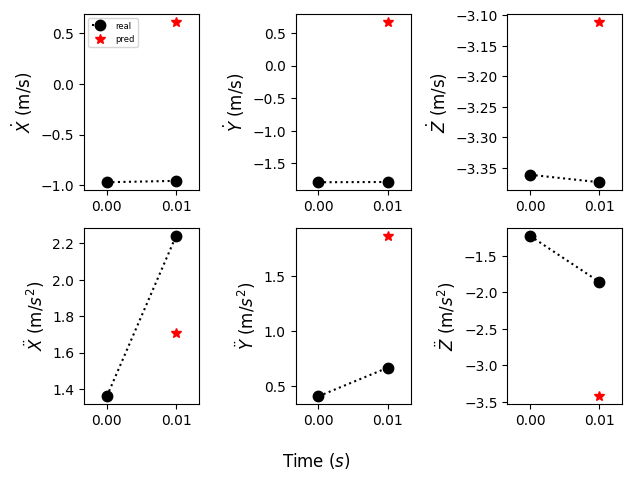

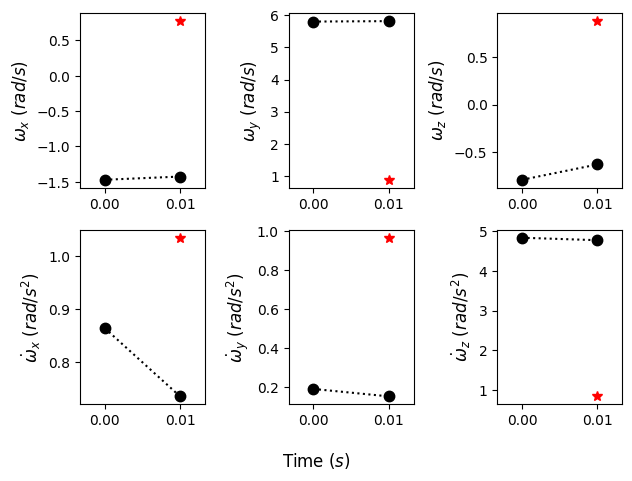

Current Batch Train Loss: 88.15142059326172

Current Batch Train Loss: 89.3007583618164

Current Batch Train Loss: 87.94730377197266

Current Batch Train Loss: 88.73470306396484

Current Batch Train Loss: 88.16690063476562

Current Batch Train Loss: 88.13153839111328

Current Batch Train Loss: 89.246337890625

Current Batch Train Loss: 87.68412780761719

Current Batch Train Loss: 88.76105499267578

Current Batch Train Loss: 88.1161880493164

Current Batch Train Loss: 89.69654083251953

Current Batch Train Loss: 88.52877044677734

Current Batch Train Loss: 88.01923370361328

Current Batch Train Loss: 89.21662902832031

Current Batch Train Loss: 88.34485626220703

Current Batch Train Loss: 89.3869400024414

Current Batch Train Loss: 90.07646942138672

Current Batch Train Loss: 89.47332763671875

Current Batch Train Loss: 90.28240203857422

Current Batch Train Loss: 89.76496124267578

Current Batch Train Loss: 89.8746109008789

Current Batch Train Loss: 90.51802825927734

Current Batch Tr

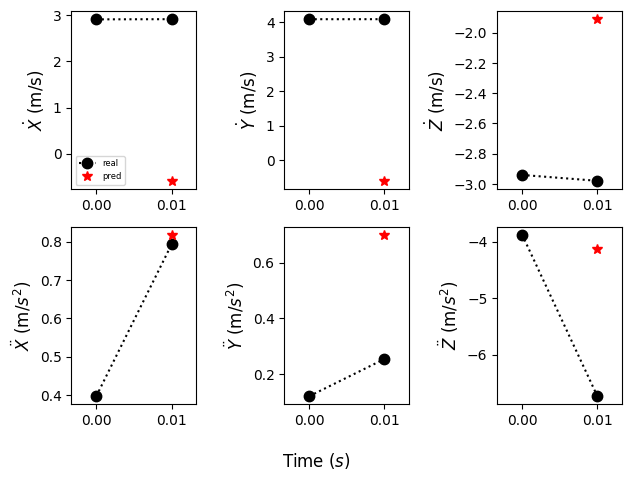

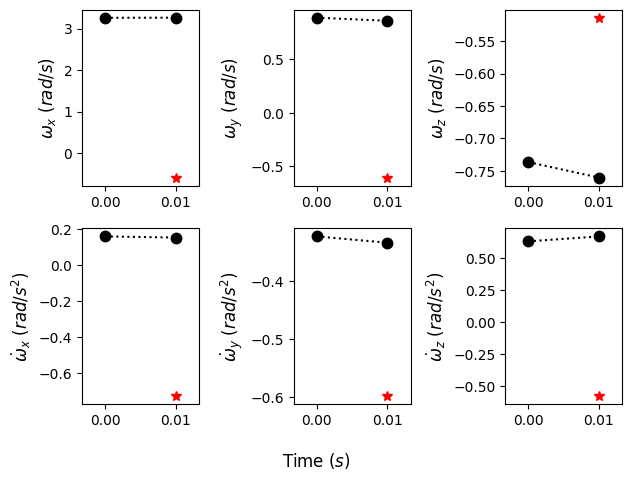

Current Batch Train Loss: 87.23727416992188

Current Batch Train Loss: 88.35863494873047

Current Batch Train Loss: 88.77717590332031

Current Batch Train Loss: 88.00187683105469

Current Batch Train Loss: 87.8446044921875

Current Batch Train Loss: 86.995361328125

Current Batch Train Loss: 86.77569580078125

Current Batch Train Loss: 89.40596008300781

Current Batch Train Loss: 87.59978485107422

Current Batch Train Loss: 87.23426818847656

Current Batch Train Loss: 88.3572006225586

Current Batch Train Loss: 88.24507141113281

Current Batch Train Loss: 87.43108367919922

Current Batch Train Loss: 85.78547668457031

Current Batch Train Loss: 87.1807861328125

Current Batch Train Loss: 87.55580139160156

Current Batch Train Loss: 89.74708557128906

Current Batch Train Loss: 91.341796875

Current Batch Train Loss: 86.58841705322266

Current Batch Train Loss: 89.93992614746094

Current Batch Train Loss: 90.12079620361328

Current Batch Train Loss: 88.81678009033203

Current Batch Train 

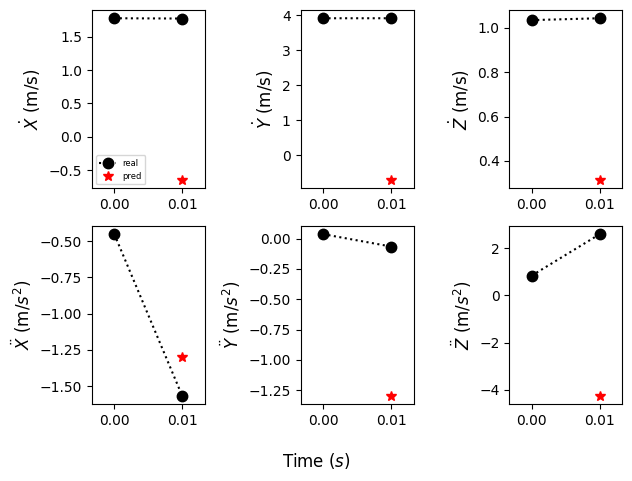

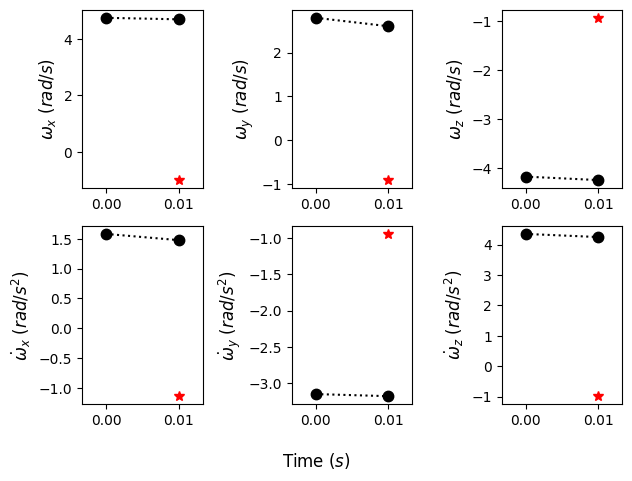

Current Batch Train Loss: 87.00031280517578

Current Batch Train Loss: 85.65449523925781

Current Batch Train Loss: 88.31185150146484

Current Batch Train Loss: 87.91117095947266

Current Batch Train Loss: 86.48611450195312

Current Batch Train Loss: 89.33840942382812

Current Batch Train Loss: 88.77652740478516

Current Batch Train Loss: 87.78033447265625

Current Batch Train Loss: 85.33521270751953

Current Batch Train Loss: 87.29309844970703

Current Batch Train Loss: 86.86244201660156

Current Batch Train Loss: 87.99947357177734

Current Batch Train Loss: 87.2317123413086

Current Batch Train Loss: 89.36149597167969

Current Batch Train Loss: 87.14413452148438

Current Batch Train Loss: 89.27545928955078

Current Batch Train Loss: 88.27845764160156

Current Batch Train Loss: 86.87838745117188

Current Batch Train Loss: 89.12384796142578

Current Batch Train Loss: 88.56873321533203

Current Batch Train Loss: 87.18133544921875

Current Batch Train Loss: 86.33110046386719

Current Bat

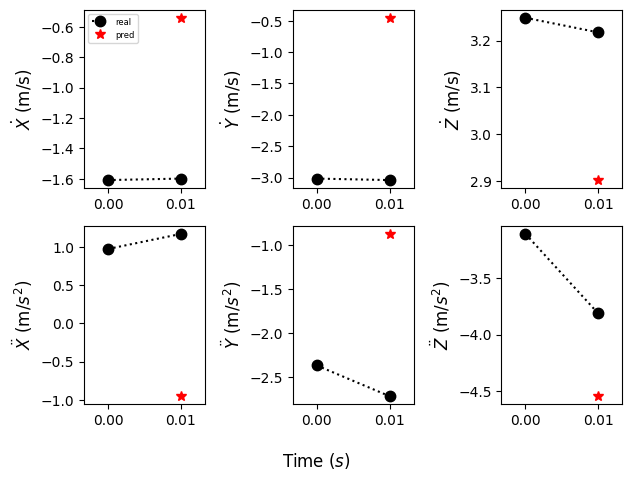

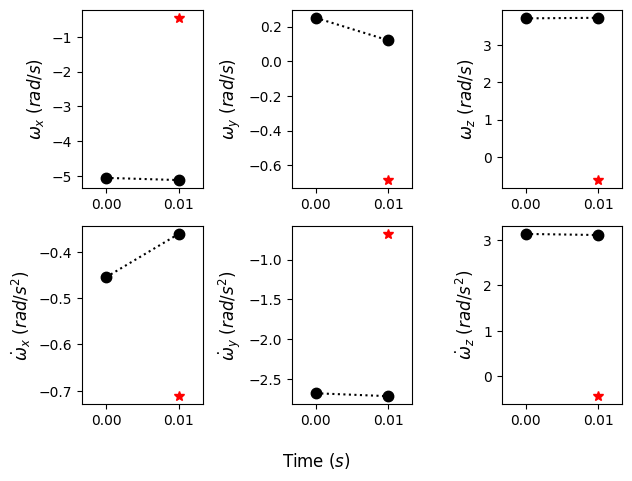

Current Batch Train Loss: 87.98174285888672

Current Batch Train Loss: 89.19392395019531

Current Batch Train Loss: 87.79659271240234

Current Batch Train Loss: 85.91767883300781

Current Batch Train Loss: 89.55890655517578

Current Batch Train Loss: 88.49244689941406

Current Batch Train Loss: 88.93466186523438

Current Batch Train Loss: 87.45027923583984

Current Batch Train Loss: 87.21261596679688

Current Batch Train Loss: 85.72398376464844

Current Batch Train Loss: 88.50894165039062

Current Batch Train Loss: 87.96775817871094

Current Batch Train Loss: 89.0376968383789

Current Batch Train Loss: 86.7004165649414

Current Batch Train Loss: 87.92538452148438

Current Batch Train Loss: 86.56504821777344

Current Batch Train Loss: 89.94380950927734

Current Batch Train Loss: 91.20868682861328

Current Batch Train Loss: 88.5309829711914

Current Batch Train Loss: 88.18228912353516

Current Batch Train Loss: 88.22599029541016

Current Batch Train Loss: 87.93226623535156

Current Batch

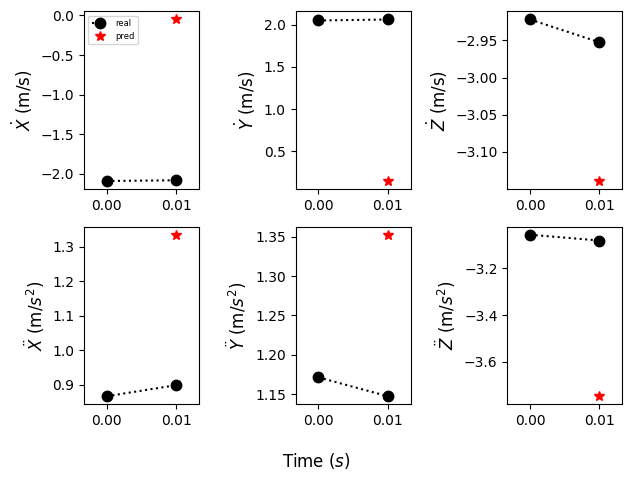

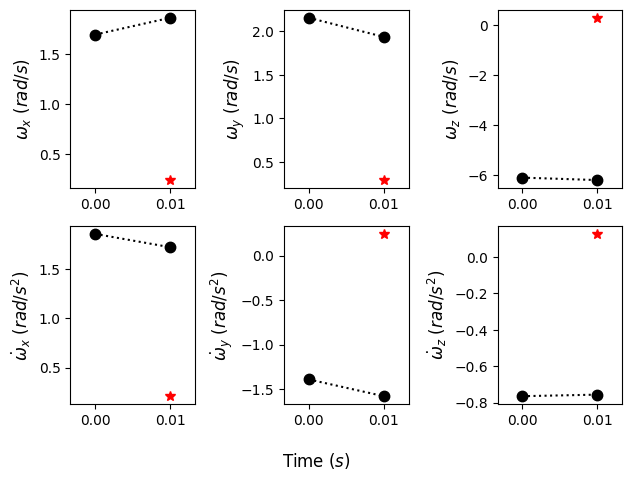

Current Batch Train Loss: 88.5084457397461

Current Batch Train Loss: 87.62830352783203

Current Batch Train Loss: 88.00411987304688

Current Batch Train Loss: 89.26396179199219

Current Batch Train Loss: 88.93636322021484

Current Batch Train Loss: 88.33682250976562

Current Batch Train Loss: 86.9655990600586

Current Batch Train Loss: 87.77226257324219

Current Batch Train Loss: 85.95227813720703

Current Batch Train Loss: 85.70326232910156

Current Batch Train Loss: 87.3485336303711

Current Batch Train Loss: 88.6838607788086

Current Batch Train Loss: 88.07466888427734

Current Batch Train Loss: 87.63449096679688

Current Batch Train Loss: 89.79377746582031

Current Batch Train Loss: 89.70294189453125

Current Batch Train Loss: 86.49297332763672

Current Batch Train Loss: 86.61279296875

Current Batch Train Loss: 86.21022033691406

Current Batch Train Loss: 87.07032012939453

Current Batch Train Loss: 87.07908630371094

Current Batch Train Loss: 86.75555419921875

Current Batch Tra

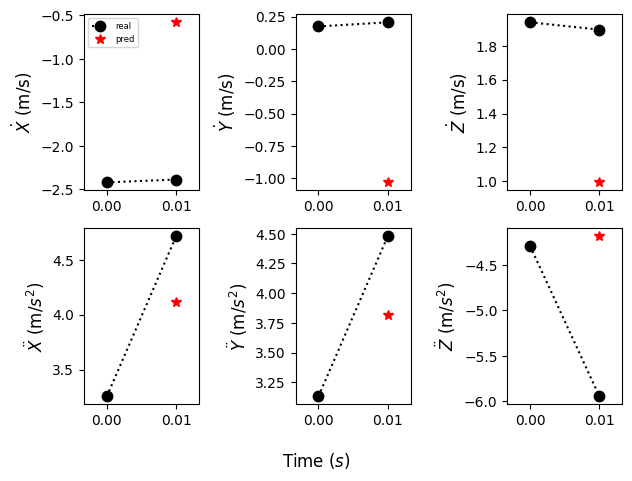

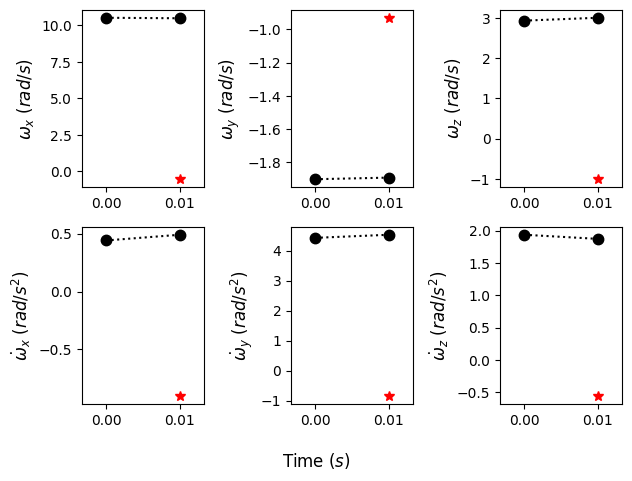

Current Batch Train Loss: 87.04187774658203

Current Batch Train Loss: 87.62483978271484

Current Batch Train Loss: 87.27906799316406

Current Batch Train Loss: 87.95906066894531

Current Batch Train Loss: 86.70277404785156

Current Batch Train Loss: 88.43721771240234

Current Batch Train Loss: 87.42274475097656

Current Batch Train Loss: 88.95819854736328

Current Batch Train Loss: 87.5188217163086

Current Batch Train Loss: 87.1259765625

Current Batch Train Loss: 84.88932037353516

Current Batch Train Loss: 88.01094818115234

Current Batch Train Loss: 86.56969451904297

Current Batch Train Loss: 87.42950439453125

Current Batch Train Loss: 89.07544708251953

Current Batch Train Loss: 86.73986053466797

Current Batch Train Loss: 88.59989166259766

Current Batch Train Loss: 87.14392852783203

Current Batch Train Loss: 84.86431884765625

Current Batch Train Loss: 86.98955535888672

Current Batch Train Loss: 88.28123474121094

Current Batch Train Loss: 89.57217407226562

Current Batch T

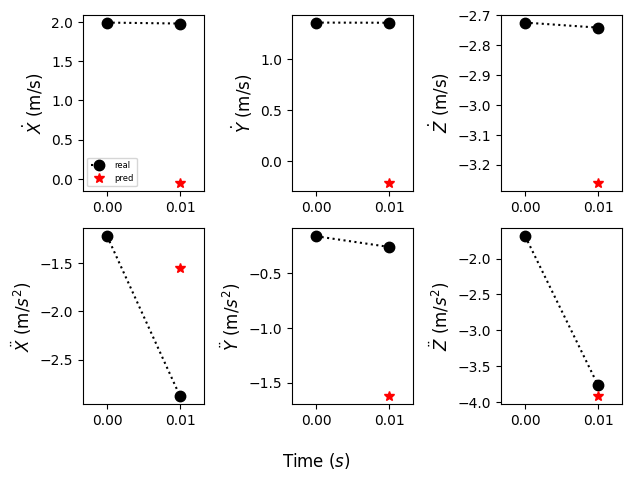

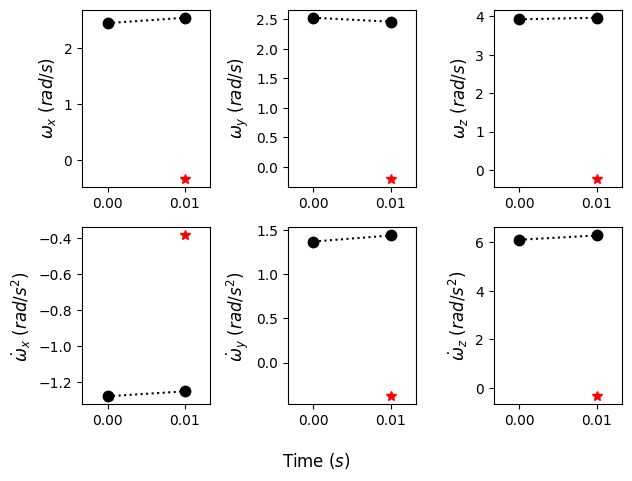

Current Batch Train Loss: 89.30845642089844

Current Batch Train Loss: 87.460205078125

Current Batch Train Loss: 87.48344421386719

Current Batch Train Loss: 88.4006118774414

Current Batch Train Loss: 85.66891479492188

Current Batch Train Loss: 89.33051300048828

Current Batch Train Loss: 88.97064208984375

Current Batch Train Loss: 89.09362030029297

Current Batch Train Loss: 87.51554870605469

Current Batch Train Loss: 88.04922485351562

Current Batch Train Loss: 87.28714752197266

Current Batch Train Loss: 88.0877456665039

Current Batch Train Loss: 86.80923461914062

Current Batch Train Loss: 86.32268524169922

Current Batch Train Loss: 86.94939422607422

Current Batch Train Loss: 85.06944274902344

Current Batch Train Loss: 88.1470718383789

Current Batch Train Loss: 88.2953109741211

Current Batch Train Loss: 84.70979309082031

Current Batch Train Loss: 85.72460174560547

Current Batch Train Loss: 86.13577270507812

Current Batch Train Loss: 90.35057830810547

Current Batch Tr

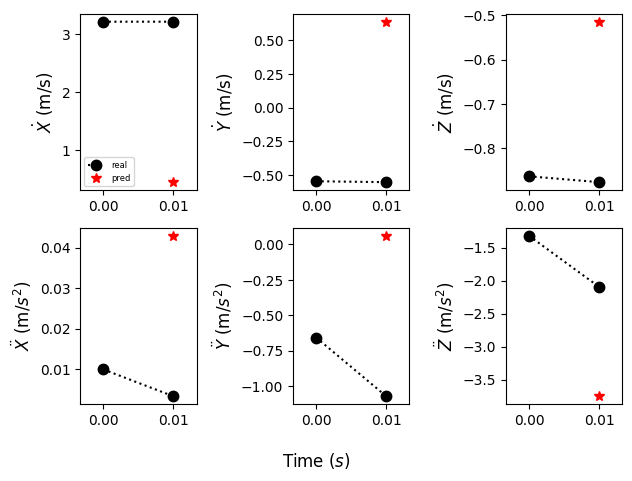

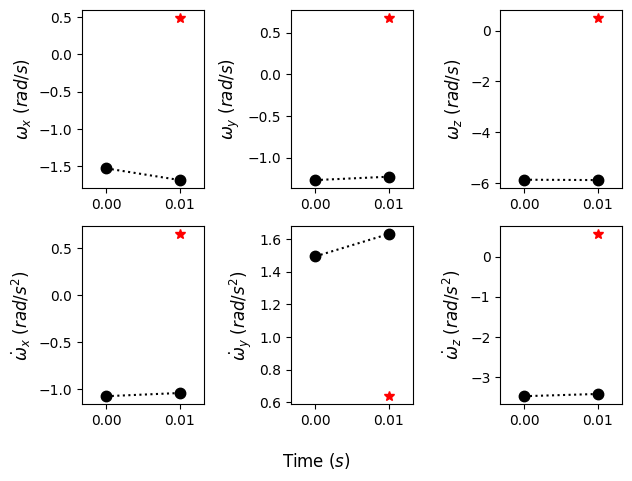

Current Batch Train Loss: 86.23806762695312

Current Batch Train Loss: 87.80931854248047

Current Batch Train Loss: 87.3069839477539

Current Batch Train Loss: 86.24921417236328

Current Batch Train Loss: 87.23036193847656

Current Batch Train Loss: 86.39091491699219

Current Batch Train Loss: 85.60954284667969

Current Batch Train Loss: 89.1458740234375

Current Batch Train Loss: 86.19873046875

Current Batch Train Loss: 85.1992416381836

Current Batch Train Loss: 85.78541564941406

Current Batch Train Loss: 86.21275329589844

Current Batch Train Loss: 85.85121154785156

Current Batch Train Loss: 85.60899353027344

Current Batch Train Loss: 87.38182067871094

Current Batch Train Loss: 85.93711853027344

Current Batch Train Loss: 85.76598358154297

Current Batch Train Loss: 87.53460693359375

Current Batch Train Loss: 86.76146697998047

Current Batch Train Loss: 86.26487731933594

Current Batch Train Loss: 88.08721923828125

Current Batch Train Loss: 89.09845733642578

Current Batch Tr

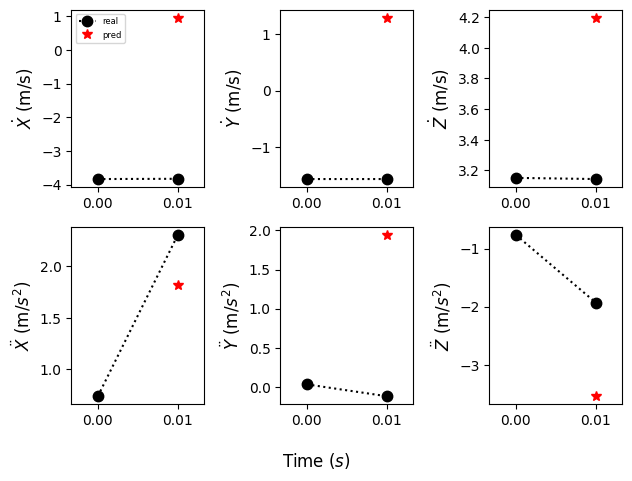

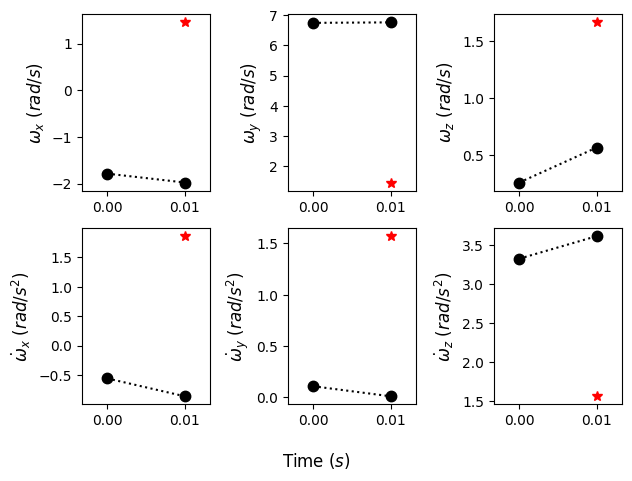

Current Batch Train Loss: 88.18436431884766

Current Batch Train Loss: 88.54717254638672

Current Batch Train Loss: 86.52970886230469

Current Batch Train Loss: 88.2014389038086

Current Batch Train Loss: 85.66033172607422

Current Batch Train Loss: 88.26093292236328

Current Batch Train Loss: 86.42710876464844

Current Batch Train Loss: 87.11914825439453

Current Batch Train Loss: 86.62519073486328

Current Batch Train Loss: 87.95369720458984

Current Batch Train Loss: 88.71735382080078

Current Batch Train Loss: 85.1708755493164

Current Batch Train Loss: 86.48470306396484

Current Batch Train Loss: 89.00303649902344

Current Batch Train Loss: 85.47754669189453

Current Batch Train Loss: 85.29411315917969

Current Batch Train Loss: 88.65716552734375

Current Batch Train Loss: 86.93627166748047

Current Batch Train Loss: 87.21788024902344

Current Batch Train Loss: 89.38141632080078

Current Batch Train Loss: 85.13394927978516

Current Batch Train Loss: 87.63060760498047

Current Batc

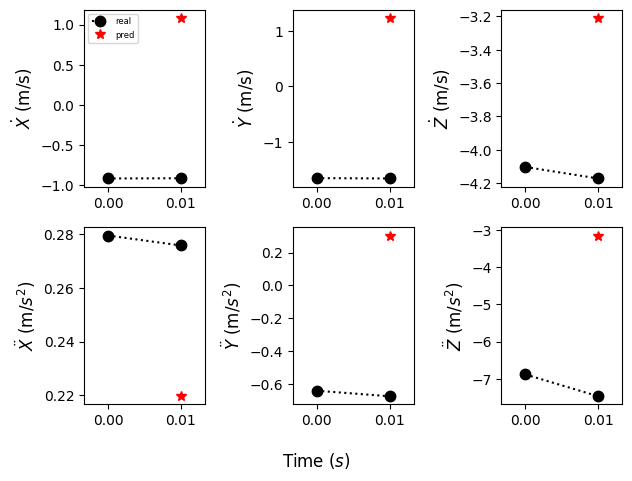

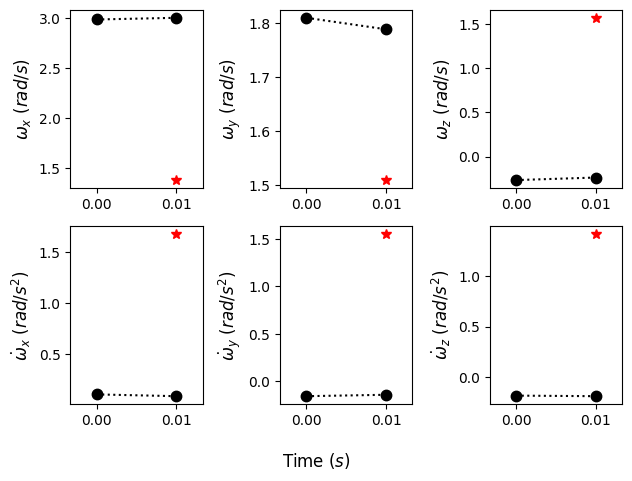

Current Batch Train Loss: 87.3844985961914

Current Batch Train Loss: 84.6390151977539

Current Batch Train Loss: 89.3740234375

Current Batch Train Loss: 86.47901153564453

Current Batch Train Loss: 88.89091491699219

Current Batch Train Loss: 88.63033294677734

Current Batch Train Loss: 85.93875885009766

Current Batch Train Loss: 87.08998107910156

Current Batch Train Loss: 87.85362243652344

Current Batch Train Loss: 88.14537811279297

Current Batch Train Loss: 87.06282806396484

Current Batch Train Loss: 87.98986053466797

Current Batch Train Loss: 88.57784271240234

Current Batch Train Loss: 88.82546997070312

Current Batch Train Loss: 87.06075286865234

Current Batch Train Loss: 87.03887939453125

Current Batch Train Loss: 87.01112365722656

Current Batch Train Loss: 89.86487579345703

Current Batch Train Loss: 87.52536010742188

Current Batch Train Loss: 87.35708618164062

Current Batch Train Loss: 85.91740417480469

Current Batch Train Loss: 86.6917953491211

Current Batch Tra

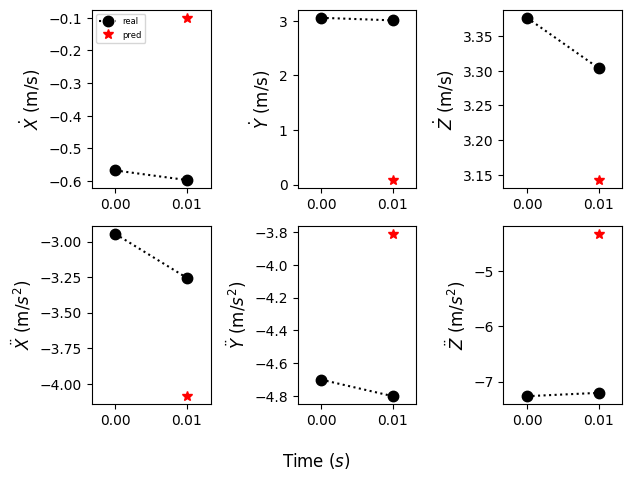

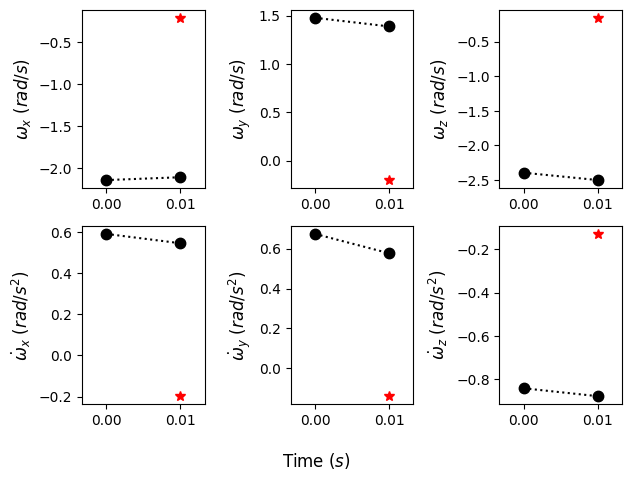

Current Batch Train Loss: 86.0696792602539

Current Batch Train Loss: 87.32469940185547

Current Batch Train Loss: 87.48675537109375

Current Batch Train Loss: 86.28004455566406

Current Batch Train Loss: 88.30049896240234

Current Batch Train Loss: 86.49584197998047

Current Batch Train Loss: 86.67485809326172

Current Batch Train Loss: 88.56334686279297

Current Batch Train Loss: 86.45193481445312

Current Batch Train Loss: 85.60680389404297

Current Batch Train Loss: 85.98368072509766

Current Batch Train Loss: 86.46306610107422

Current Batch Train Loss: 84.58721160888672

Current Batch Train Loss: 86.48295593261719

Current Batch Train Loss: 86.38218688964844

Current Batch Train Loss: 87.2229232788086

Current Batch Train Loss: 87.2640380859375

Current Batch Train Loss: 85.87763214111328

Current Batch Train Loss: 86.98014831542969

Current Batch Train Loss: 85.69921875

Current Batch Train Loss: 85.63998413085938

Current Batch Train Loss: 86.1141357421875

Current Batch Train 

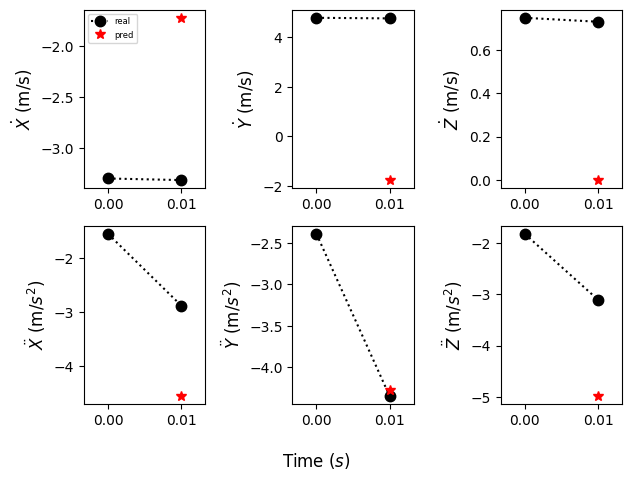

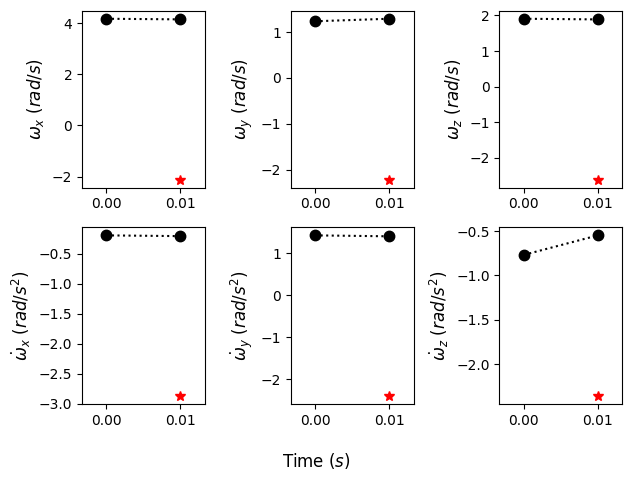

Current Batch Train Loss: 86.0319595336914

Current Batch Train Loss: 85.57036590576172

Current Batch Train Loss: 84.53086853027344

Current Batch Train Loss: 86.7334976196289

Current Batch Train Loss: 86.51171875

Current Batch Train Loss: 84.72584533691406

Current Batch Train Loss: 85.85709381103516

Current Batch Train Loss: 86.02500915527344

Current Batch Train Loss: 84.8609390258789

Current Batch Train Loss: 84.17516326904297

Current Batch Train Loss: 87.38290405273438

Current Batch Train Loss: 85.96764373779297

Current Batch Train Loss: 87.03480529785156

Current Batch Train Loss: 87.11705017089844

Current Batch Train Loss: 86.42071533203125

Current Batch Train Loss: 86.96157836914062

Current Batch Train Loss: 88.45470428466797

Current Batch Train Loss: 86.50884246826172

Current Batch Train Loss: 86.1629638671875

Current Batch Train Loss: 87.20833587646484

Current Batch Train Loss: 83.69945526123047

Current Batch Train Loss: 87.37865447998047

Current Batch Train 

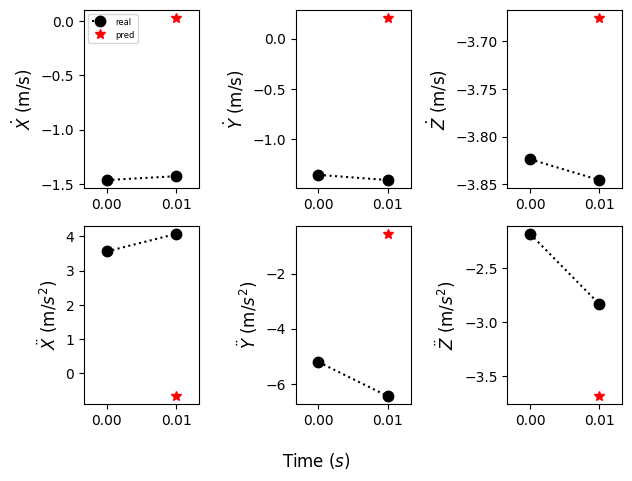

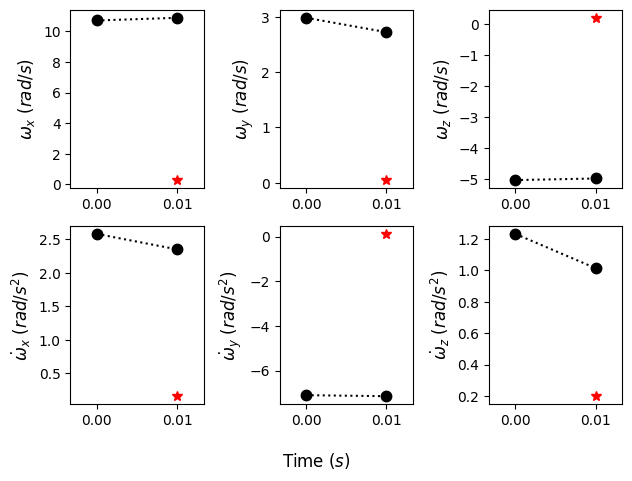

Current Batch Train Loss: 87.92672729492188

Current Batch Train Loss: 88.11105346679688

Current Batch Train Loss: 87.09232330322266

Current Batch Train Loss: 88.11251068115234

Current Batch Train Loss: 84.60879516601562

Current Batch Train Loss: 87.69929504394531

Current Batch Train Loss: 87.01570892333984

Current Batch Train Loss: 86.11137390136719

Current Batch Train Loss: 86.57422637939453

Current Batch Train Loss: 85.20235443115234

Current Batch Train Loss: 86.58074951171875

Current Batch Train Loss: 85.23119354248047

Current Batch Train Loss: 84.76028442382812

Current Batch Train Loss: 86.14861297607422

Current Batch Train Loss: 87.4748764038086

Current Batch Train Loss: 86.81989288330078

Current Batch Train Loss: 85.63053894042969

Current Batch Train Loss: 84.11543273925781

Current Batch Train Loss: 88.76948547363281

Current Batch Train Loss: 84.66399383544922

Current Batch Train Loss: 85.86970520019531

Current Batch Train Loss: 86.32777404785156

Current Bat

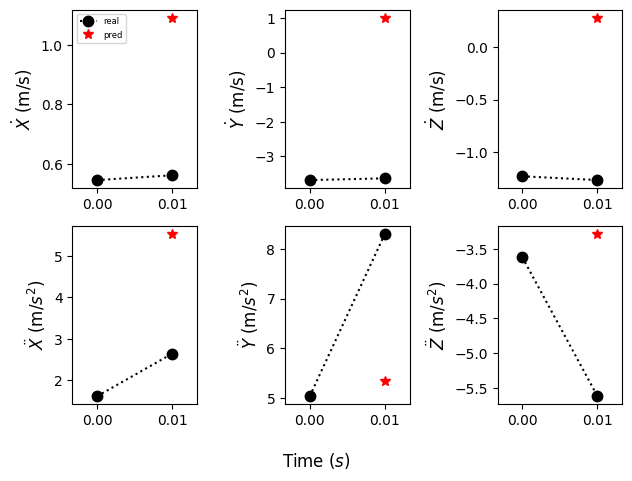

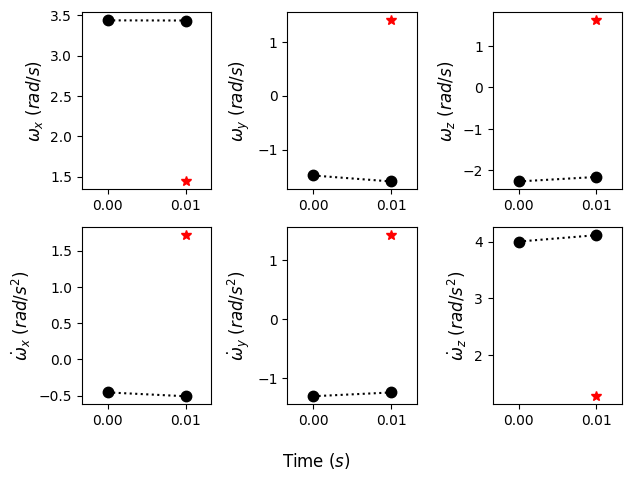

Current Batch Train Loss: 85.34669494628906

Current Batch Train Loss: 87.02777099609375

Current Batch Train Loss: 88.7156753540039

Current Batch Train Loss: 88.47101593017578

Current Batch Train Loss: 85.44783782958984

Current Batch Train Loss: 86.50924682617188

Current Batch Train Loss: 87.31099700927734

Current Batch Train Loss: 87.69200134277344

Current Batch Train Loss: 86.90814208984375

Current Batch Train Loss: 86.60985565185547

Current Batch Train Loss: 87.0420150756836

Current Batch Train Loss: 89.98185729980469

Current Batch Train Loss: 85.69347381591797

Current Batch Train Loss: 86.02050018310547

Current Batch Train Loss: 85.41952514648438

Current Batch Train Loss: 90.24320220947266

Current Batch Train Loss: 84.82393646240234

Current Batch Train Loss: 86.80905151367188

Current Batch Train Loss: 86.33622741699219

Current Batch Train Loss: 86.21782684326172

Current Batch Train Loss: 87.07388305664062

Current Batch Train Loss: 86.12142181396484

Current Batc

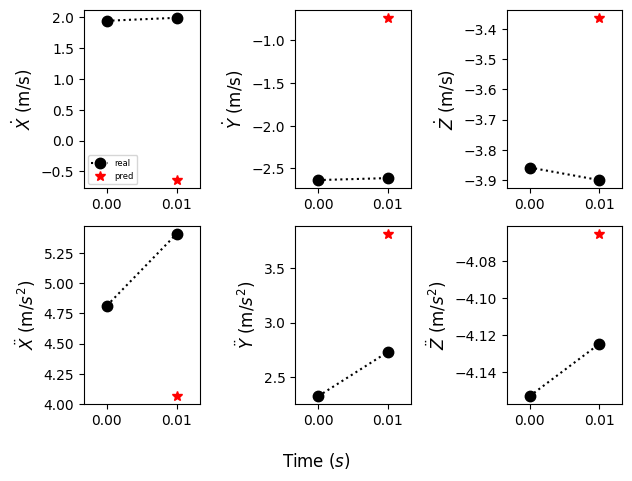

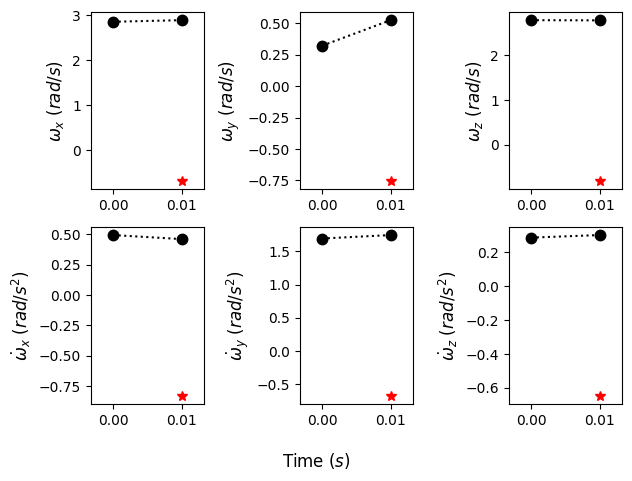

Current Batch Train Loss: 85.11257934570312

Current Batch Train Loss: 85.78636932373047

Current Batch Train Loss: 85.7561264038086

Current Batch Train Loss: 87.6054916381836

Current Batch Train Loss: 85.38831329345703

Current Batch Train Loss: 86.79148864746094

Current Batch Train Loss: 84.45710754394531

Current Batch Train Loss: 86.08494567871094

Current Batch Train Loss: 84.89508056640625

Current Batch Train Loss: 85.90592193603516

Current Batch Train Loss: 86.82581329345703

Current Batch Train Loss: 85.32380676269531

Current Batch Train Loss: 86.69837188720703

Current Batch Train Loss: 85.8635025024414

Current Batch Train Loss: 85.71839904785156

Current Batch Train Loss: 86.510498046875

Current Batch Train Loss: 86.5028076171875

Current Batch Train Loss: 87.18365478515625

Current Batch Train Loss: 86.13785552978516

Current Batch Train Loss: 85.91567993164062

Current Batch Train Loss: 85.33756256103516

Current Batch Train Loss: 85.3240966796875

Current Batch Tra

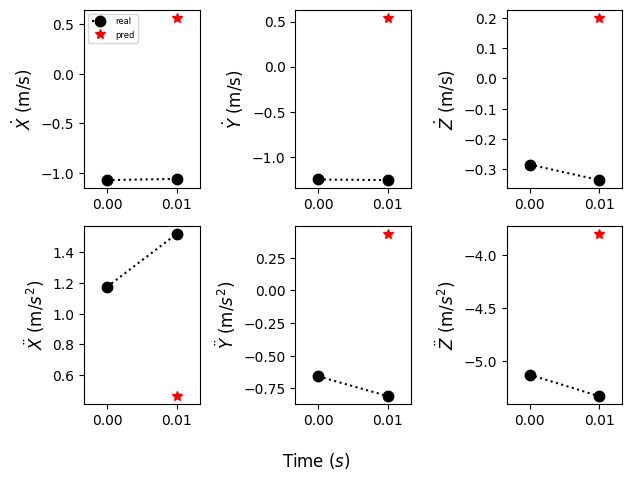

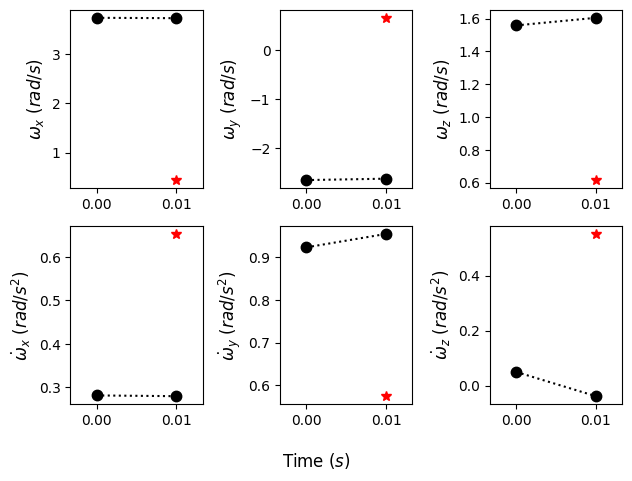

Current Batch Train Loss: 88.42583465576172

Current Batch Train Loss: 85.8791732788086

Current Batch Train Loss: 85.20576477050781

Current Batch Train Loss: 85.61094665527344

Current Batch Train Loss: 85.20022583007812

Current Batch Train Loss: 86.02262878417969

Current Batch Train Loss: 86.60848236083984

Current Batch Train Loss: 87.4946517944336

Current Batch Train Loss: 85.5620346069336

Current Batch Train Loss: 86.28617095947266

Current Batch Train Loss: 85.57484436035156

Current Batch Train Loss: 86.49942016601562

Current Batch Train Loss: 84.1788558959961

Current Batch Train Loss: 85.68299865722656

Current Batch Train Loss: 86.84811401367188

Current Batch Train Loss: 87.6425552368164

Current Batch Train Loss: 86.01763153076172

Current Batch Train Loss: 83.78260040283203

Current Batch Train Loss: 88.37863159179688

Current Batch Train Loss: 85.18363189697266

Current Batch Train Loss: 86.27253723144531

Current Batch Train Loss: 85.81685638427734

Current Batch T

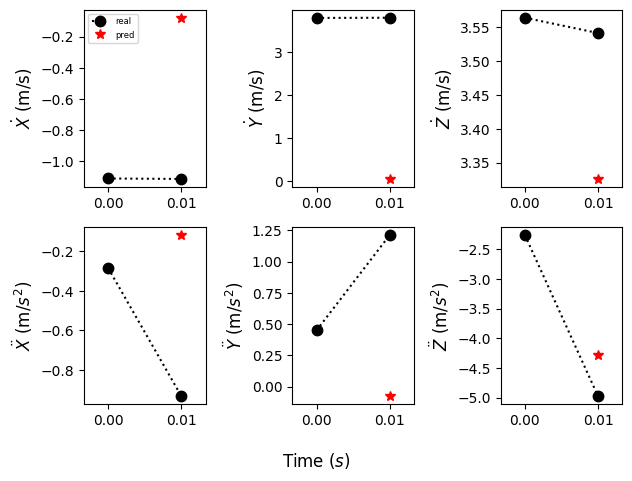

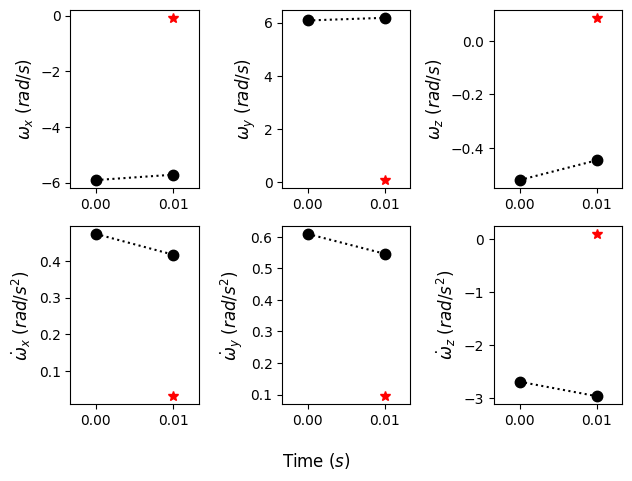

Current Batch Train Loss: 83.66559600830078

Current Batch Train Loss: 86.71517944335938

Current Batch Train Loss: 86.62134552001953

Current Batch Train Loss: 86.49090576171875

Current Batch Train Loss: 82.87478637695312

Current Batch Train Loss: 86.69664001464844

Current Batch Train Loss: 87.38565063476562

Current Batch Train Loss: 88.56449890136719

Current Batch Train Loss: 86.0487289428711

Current Batch Train Loss: 86.59172058105469

Current Batch Train Loss: 84.22975158691406

Current Batch Train Loss: 84.96715545654297

Current Batch Train Loss: 86.91077423095703

Current Batch Train Loss: 85.63534545898438

Current Batch Train Loss: 88.63381958007812

Current Batch Train Loss: 88.65936279296875

Current Batch Train Loss: 85.49004364013672

Current Batch Train Loss: 86.95632934570312

Current Batch Train Loss: 86.08695983886719

Current Batch Train Loss: 85.11827087402344

Current Batch Train Loss: 85.59980010986328

Current Batch Train Loss: 87.05403137207031

Current Bat

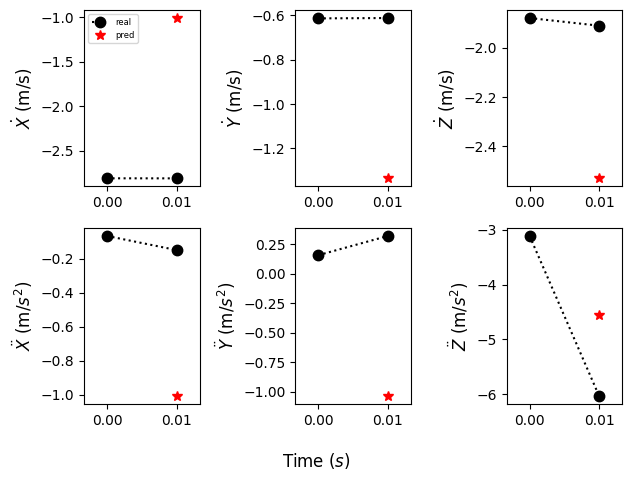

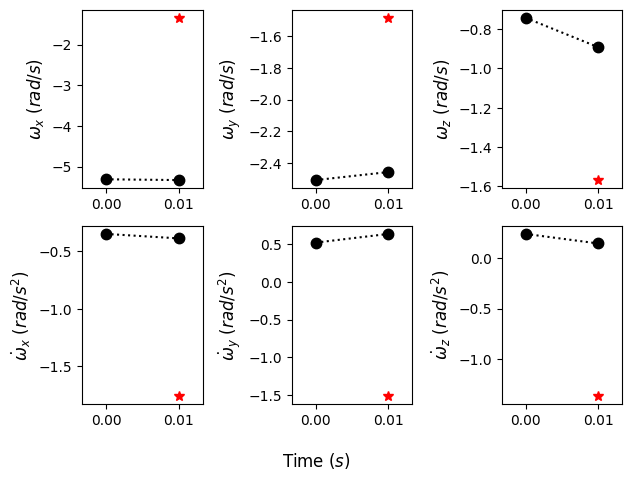

Current Batch Train Loss: 85.9887466430664

Current Batch Train Loss: 83.27082824707031

Current Batch Train Loss: 85.21101379394531

Current Batch Train Loss: 86.0737075805664

Current Batch Train Loss: 83.8580322265625

Current Batch Train Loss: 84.34717559814453

Current Batch Train Loss: 85.63614654541016

Current Batch Train Loss: 87.17849731445312

Current Batch Train Loss: 86.39698028564453

Current Batch Train Loss: 86.5020980834961

Current Batch Train Loss: 86.54134368896484

Current Batch Train Loss: 84.0156478881836

Current Batch Train Loss: 84.87026977539062

Current Batch Train Loss: 86.60546112060547

Current Batch Train Loss: 82.12173461914062

Current Batch Train Loss: 88.51643371582031

Current Batch Train Loss: 85.5425796508789

Current Batch Train Loss: 86.40951538085938

Current Batch Train Loss: 85.77914428710938

Current Batch Train Loss: 85.59642028808594

Current Batch Train Loss: 86.54822540283203

Current Batch Train Loss: 83.55892944335938

Current Batch Tr

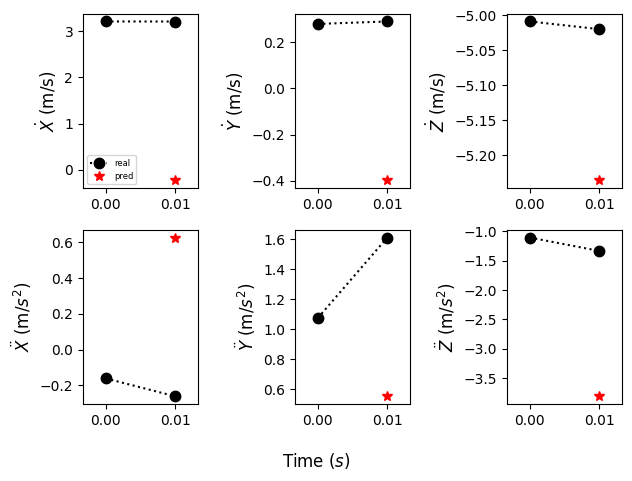

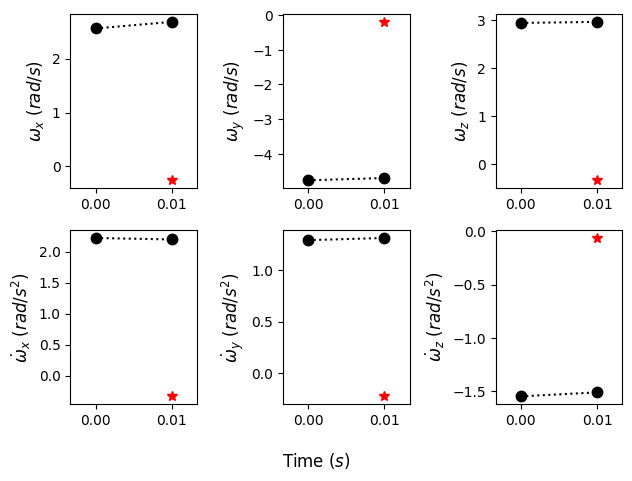

Current Batch Train Loss: 84.33151245117188

Current Batch Train Loss: 84.66880798339844

Current Batch Train Loss: 85.38158416748047

Current Batch Train Loss: 85.80696868896484

Current Batch Train Loss: 84.46472930908203

Current Batch Train Loss: 85.29764556884766

Current Batch Train Loss: 87.03885650634766

Current Batch Train Loss: 87.70294189453125

Current Batch Train Loss: 85.6025161743164

Current Batch Train Loss: 86.7707748413086

Current Batch Train Loss: 87.99693298339844

Current Batch Train Loss: 84.14472198486328

Current Batch Train Loss: 85.13166046142578

Current Batch Train Loss: 85.8606948852539

Current Batch Train Loss: 87.72740936279297

Current Batch Train Loss: 87.59030151367188

Current Batch Train Loss: 86.69769287109375

Current Batch Train Loss: 86.0856704711914

Current Batch Train Loss: 84.46356201171875

Current Batch Train Loss: 84.85639190673828

Current Batch Train Loss: 84.26737213134766

Current Batch Train Loss: 85.5355224609375

Current Batch T

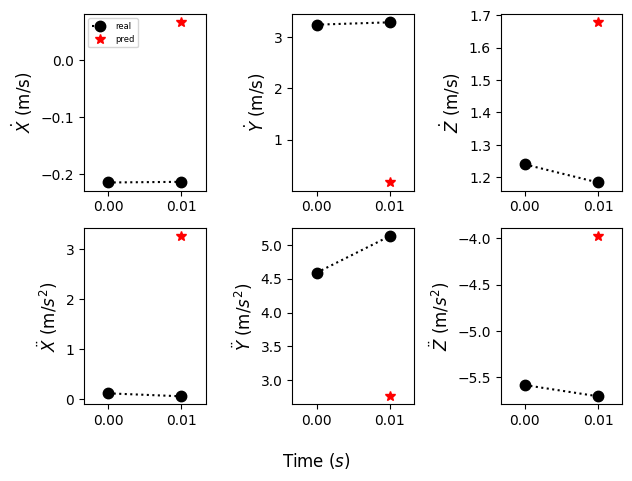

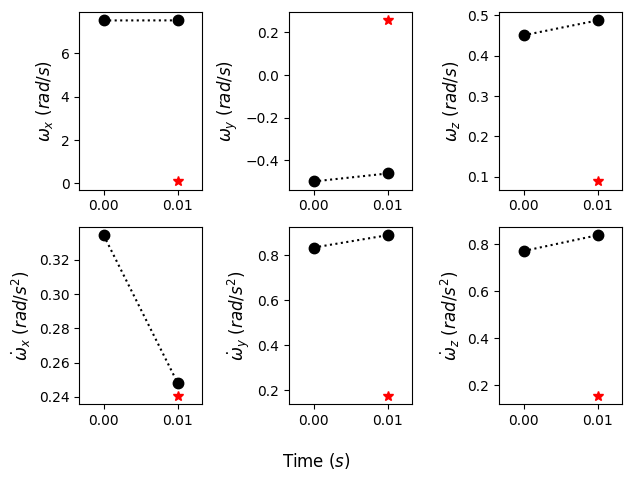

Current Batch Train Loss: 87.70091247558594

Current Batch Train Loss: 84.83491516113281

Current Batch Train Loss: 86.70184326171875

Current Batch Train Loss: 86.86515808105469

Current Batch Train Loss: 86.50556945800781

Current Batch Train Loss: 88.6233139038086

Current Batch Train Loss: 86.00762939453125

Current Batch Train Loss: 86.44548797607422

Current Batch Train Loss: 85.44722747802734

Current Batch Train Loss: 87.4509506225586

Current Batch Train Loss: 84.68661499023438

Current Batch Train Loss: 84.06837463378906

Current Batch Train Loss: 85.29244995117188

Current Batch Train Loss: 87.11231994628906

Current Batch Train Loss: 86.13400268554688

Current Batch Train Loss: 85.79402923583984

Current Batch Train Loss: 86.35598754882812

Current Batch Train Loss: 84.4237060546875

Current Batch Train Loss: 85.69371032714844

Current Batch Train Loss: 85.15155029296875

Current Batch Train Loss: 82.46892547607422

Current Batch Train Loss: 84.54869842529297

Current Batch

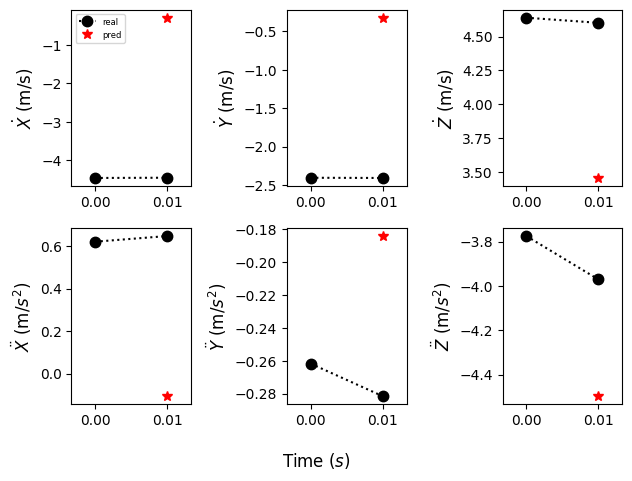

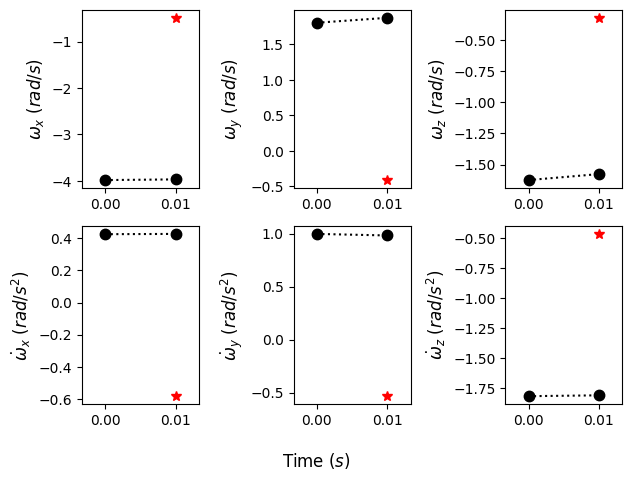

Current Batch Train Loss: 84.93785858154297

Current Batch Train Loss: 85.60755920410156

Current Batch Train Loss: 85.76983642578125

Current Batch Train Loss: 81.18080139160156

Current Batch Train Loss: 84.99325561523438

Current Batch Train Loss: 85.01373291015625

Current Batch Train Loss: 85.98638153076172

Current Batch Train Loss: 85.03707885742188

Current Batch Train Loss: 83.82026672363281

Current Batch Train Loss: 85.73871612548828

Current Batch Train Loss: 85.058349609375

Current Batch Train Loss: 85.73934173583984

Current Batch Train Loss: 85.564208984375

Current Batch Train Loss: 82.74779510498047

Current Batch Train Loss: 85.58289337158203

Current Batch Train Loss: 82.35877990722656

Current Batch Train Loss: 87.41770935058594

Current Batch Train Loss: 83.47709655761719

Current Batch Train Loss: 86.54642486572266

Current Batch Train Loss: 86.51790618896484

Current Batch Train Loss: 84.21318054199219

Current Batch Train Loss: 86.52389526367188

Current Batch 

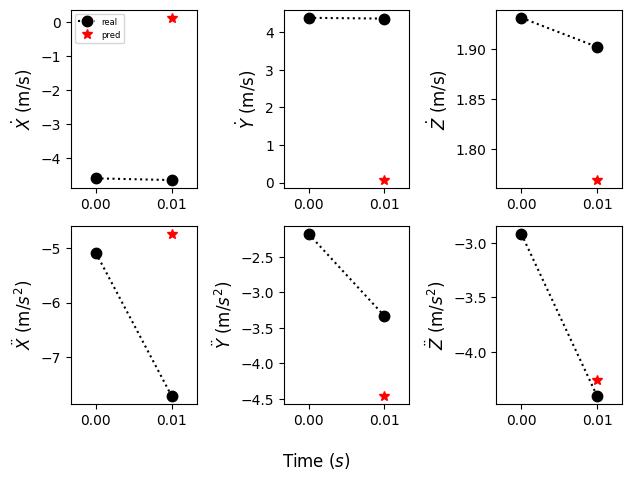

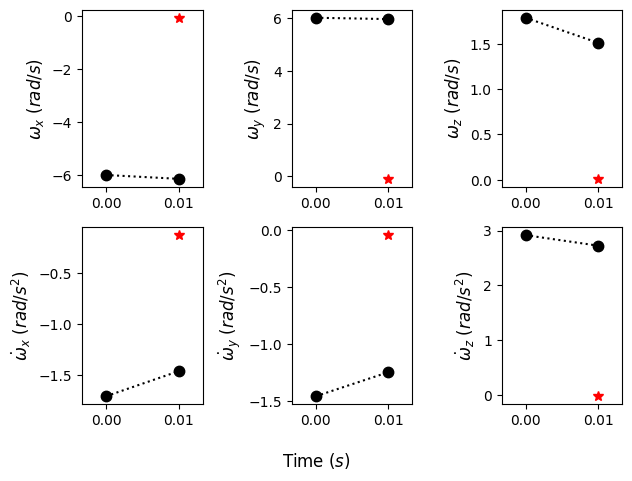

Current Batch Train Loss: 86.58202362060547

Current Batch Train Loss: 86.2764663696289

Current Batch Train Loss: 84.50146484375

Current Batch Train Loss: 85.20658874511719

Current Batch Train Loss: 84.82997131347656

Current Batch Train Loss: 83.66029357910156

Current Batch Train Loss: 86.38720703125

Current Batch Train Loss: 85.24519348144531

Current Batch Train Loss: 85.36701202392578

Current Batch Train Loss: 84.6536636352539

Current Batch Train Loss: 87.72976684570312

Current Batch Train Loss: 85.40351867675781

Current Batch Train Loss: 85.03670501708984

Current Batch Train Loss: 87.51313781738281

Current Batch Train Loss: 83.46412658691406

Current Batch Train Loss: 84.8715591430664

Current Batch Train Loss: 86.29621887207031

Current Batch Train Loss: 84.26691436767578

Current Batch Train Loss: 85.97432708740234

Current Batch Train Loss: 85.72042083740234

Current Batch Train Loss: 85.18329620361328

Current Batch Train Loss: 83.85662078857422

Current Batch Train

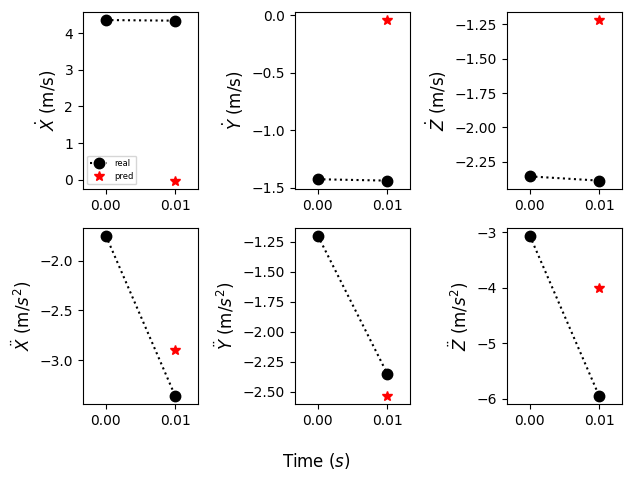

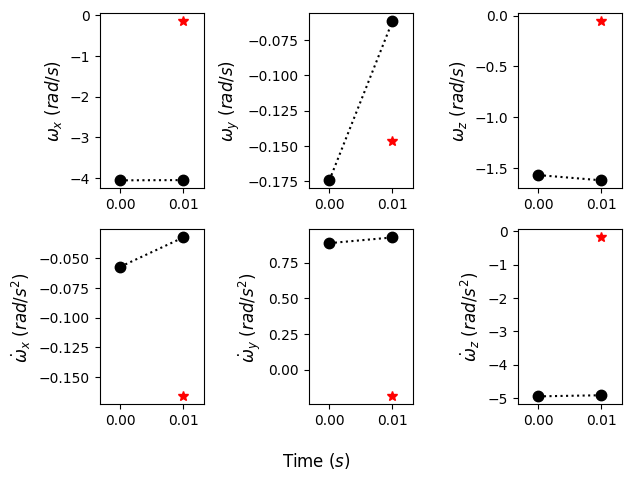

Current Batch Train Loss: 86.0506820678711

Current Batch Train Loss: 86.77913665771484

Current Batch Train Loss: 86.32051849365234

Current Batch Train Loss: 84.19629669189453

Current Batch Train Loss: 87.37775421142578

Current Batch Train Loss: 84.4947738647461

Current Batch Train Loss: 84.15083312988281

Current Batch Train Loss: 84.25798034667969

Current Batch Train Loss: 85.31816101074219

Current Batch Train Loss: 85.42056274414062

Current Batch Train Loss: 84.93596649169922

Current Batch Train Loss: 84.12908172607422

Current Batch Train Loss: 84.32594299316406

Current Batch Train Loss: 84.5289535522461

Current Batch Train Loss: 85.14977264404297

Current Batch Train Loss: 85.1409683227539

Current Batch Train Loss: 86.16077423095703

Current Batch Train Loss: 85.53527069091797

Current Batch Train Loss: 84.26061248779297

Current Batch Train Loss: 84.3551254272461

Current Batch Train Loss: 84.56778717041016

Current Batch Train Loss: 84.59001159667969

Current Batch T

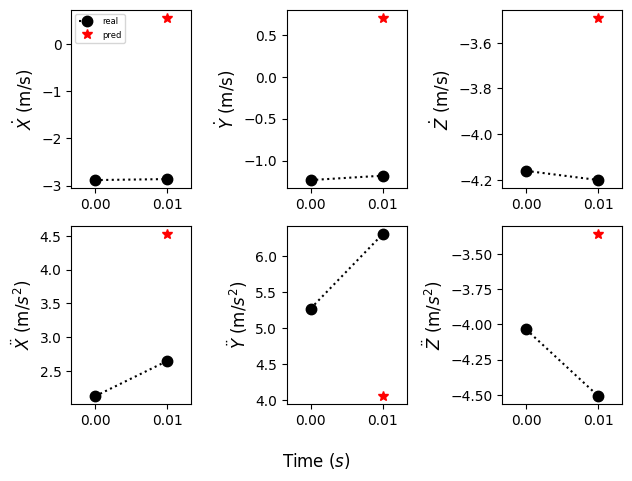

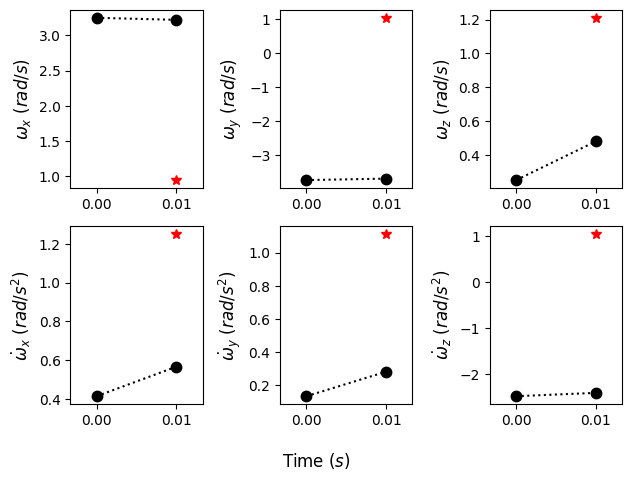

Current Batch Train Loss: 85.40353393554688

Current Batch Train Loss: 88.15023803710938

Current Batch Train Loss: 85.34672546386719

Current Batch Train Loss: 83.9787826538086

Current Batch Train Loss: 86.13195037841797

Current Batch Train Loss: 86.0398178100586

Current Batch Train Loss: 84.7003402709961

Current Batch Train Loss: 87.88835144042969

Current Batch Train Loss: 85.42102813720703

Current Batch Train Loss: 85.27050018310547

Current Batch Train Loss: 83.15194702148438

Current Batch Train Loss: 84.70411682128906

Current Batch Train Loss: 85.58927154541016

Current Batch Train Loss: 85.36231231689453

Current Batch Train Loss: 84.01598358154297

Current Batch Train Loss: 85.41402435302734

Current Batch Train Loss: 85.65184020996094

Current Batch Train Loss: 84.74188232421875

Current Batch Train Loss: 83.51210021972656

Current Batch Train Loss: 86.07486724853516

Current Batch Train Loss: 84.89402770996094

Current Batch Train Loss: 85.69493103027344

Current Batch

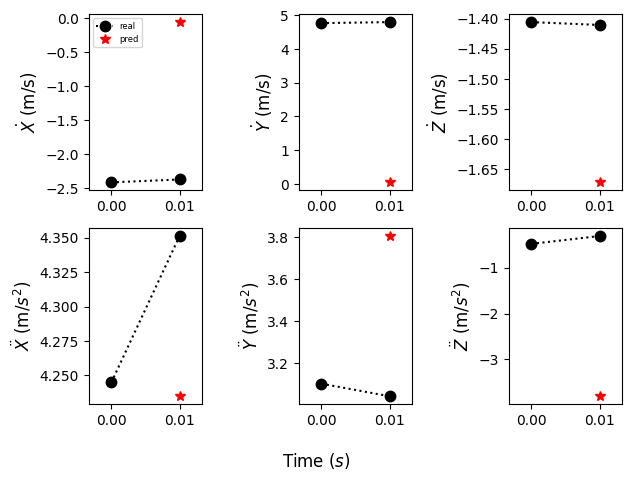

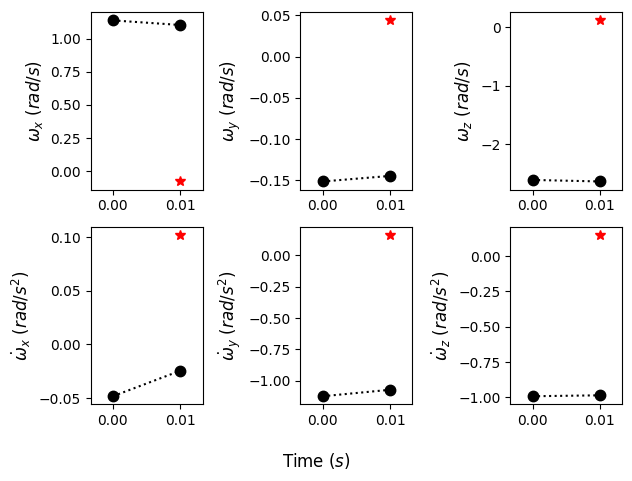

Current Batch Train Loss: 84.72645568847656

Current Batch Train Loss: 86.34964752197266

Current Batch Train Loss: 86.62560272216797

Current Batch Train Loss: 85.96277618408203

Current Batch Train Loss: 83.5219497680664

Current Batch Train Loss: 83.16036224365234

Current Batch Train Loss: 84.29045104980469

Current Batch Train Loss: 87.19390106201172

Current Batch Train Loss: 85.76886749267578

Current Batch Train Loss: 83.70677947998047

Current Batch Train Loss: 83.93354034423828

Current Batch Train Loss: 85.49891662597656

Current Batch Train Loss: 84.6657485961914

Current Batch Train Loss: 86.1410903930664

Current Batch Train Loss: 87.3154525756836

Current Batch Train Loss: 86.61564636230469

Current Batch Train Loss: 83.87162017822266

Current Batch Train Loss: 84.80804443359375

Current Batch Train Loss: 86.83113098144531

Current Batch Train Loss: 84.2990493774414

Current Batch Train Loss: 86.81684112548828

Current Batch Train Loss: 82.97419738769531

Current Batch T

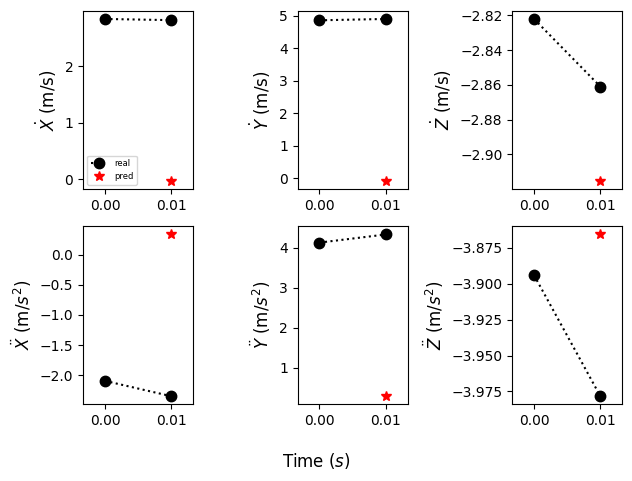

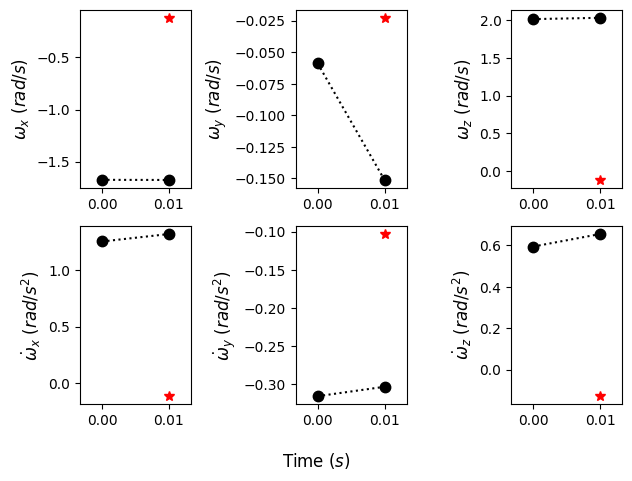

Current Batch Train Loss: 85.3992919921875

Current Batch Train Loss: 86.32630157470703

Current Batch Train Loss: 83.19873809814453

Current Batch Train Loss: 84.7212142944336

Current Batch Train Loss: 84.93951416015625

Current Batch Train Loss: 85.11138153076172

Current Batch Train Loss: 85.12953186035156

Current Batch Train Loss: 84.78273010253906

Current Batch Train Loss: 85.72535705566406

Current Batch Train Loss: 86.04024505615234

Current Batch Train Loss: 84.6229248046875

Current Batch Train Loss: 84.67039489746094

Current Batch Train Loss: 85.02118682861328

Current Batch Train Loss: 87.95036315917969

Current Batch Train Loss: 83.91654205322266

Current Batch Train Loss: 85.59713745117188

Current Batch Train Loss: 84.13114166259766

Current Batch Train Loss: 86.50051879882812

Current Batch Train Loss: 86.09498596191406

Current Batch Train Loss: 85.4990005493164

Current Batch Train Loss: 85.4488525390625

Current Batch Train Loss: 84.6640853881836

Current Batch Tr

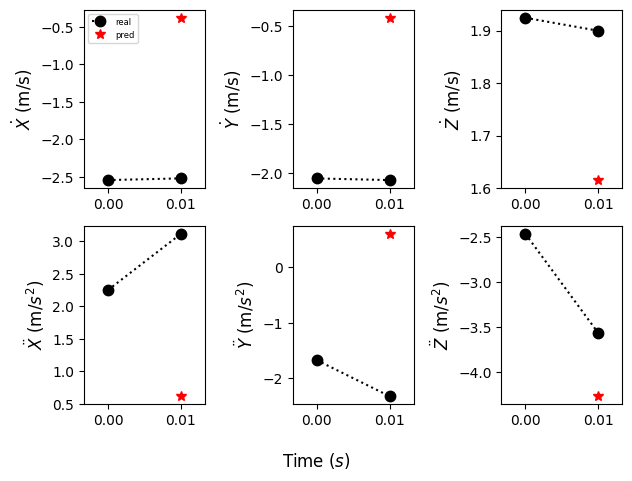

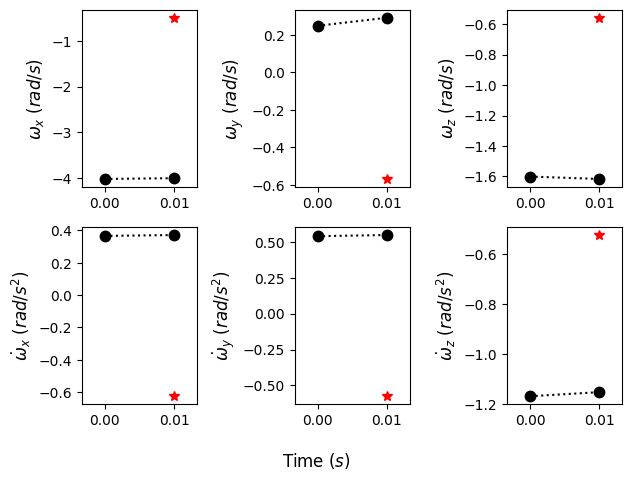

Current Batch Train Loss: 83.7055435180664

Current Batch Train Loss: 86.67103576660156

Current Batch Train Loss: 84.37449645996094

Current Batch Train Loss: 86.90574645996094

Current Batch Train Loss: 85.42237091064453

Current Batch Train Loss: 84.39503479003906

Current Batch Train Loss: 87.71455383300781

Current Batch Train Loss: 83.86908721923828

Current Batch Train Loss: 84.5546646118164

Current Batch Train Loss: 84.70979309082031

Current Batch Train Loss: 85.2750244140625

Current Batch Train Loss: 85.41866302490234

Current Batch Train Loss: 86.02963256835938

Current Batch Train Loss: 85.28612518310547

Current Batch Train Loss: 86.09685516357422

Current Batch Train Loss: 86.12163543701172

Current Batch Train Loss: 82.51292419433594

Current Batch Train Loss: 81.60005187988281

Current Batch Train Loss: 85.93953704833984

Current Batch Train Loss: 85.20642852783203

Current Batch Train Loss: 83.6165542602539

Current Batch Train Loss: 85.36327362060547

Current Batch 

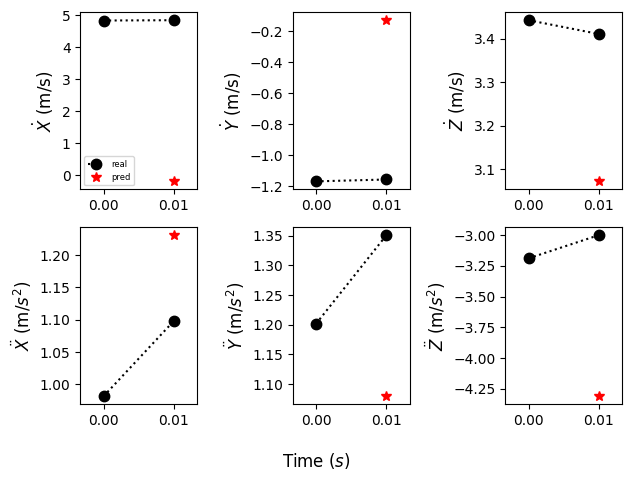

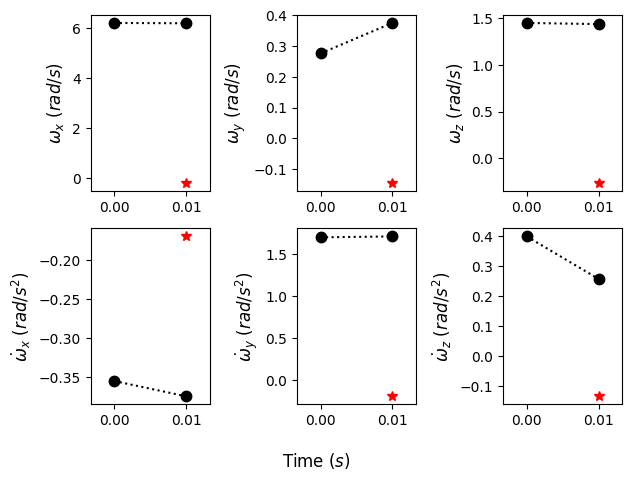

Current Batch Train Loss: 83.79643249511719

Current Batch Train Loss: 84.632568359375

Current Batch Train Loss: 85.77510070800781

Current Batch Train Loss: 86.31327056884766

Current Batch Train Loss: 86.52208709716797

Current Batch Train Loss: 87.2754135131836

Current Batch Train Loss: 85.26554870605469

Current Batch Train Loss: 86.9211196899414

Current Batch Train Loss: 84.20042419433594

Current Batch Train Loss: 83.54643249511719

Current Batch Train Loss: 85.4608154296875

Current Batch Train Loss: 84.13921356201172

Current Batch Train Loss: 85.63886260986328

Current Batch Train Loss: 85.32183837890625

Current Batch Train Loss: 84.78658294677734

Current Batch Train Loss: 85.26008605957031

Current Batch Train Loss: 82.29247283935547

Current Batch Train Loss: 86.0326919555664

Current Batch Train Loss: 84.7405776977539

Current Batch Train Loss: 83.77277374267578

Current Batch Train Loss: 84.81073760986328

Current Batch Train Loss: 85.6166000366211

Current Batch Trai

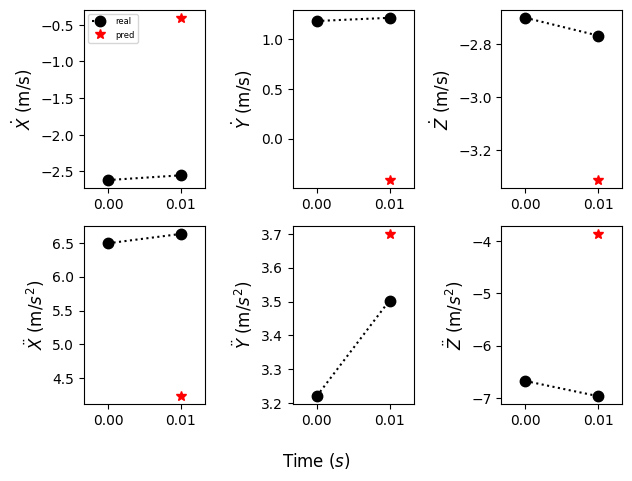

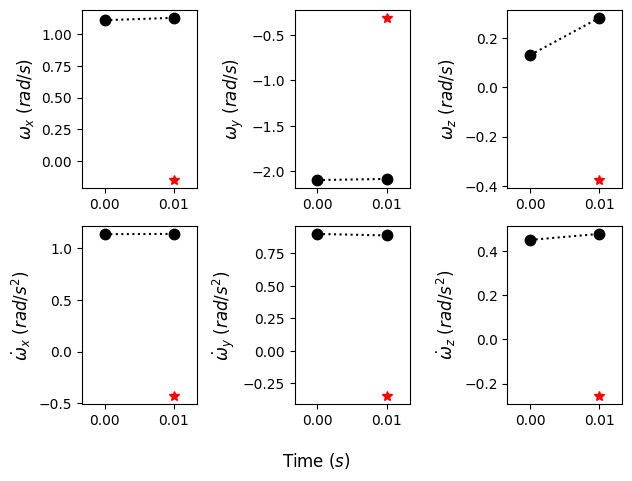

Current Batch Train Loss: 84.0593032836914

Current Batch Train Loss: 87.6105728149414

Current Batch Train Loss: 82.3831787109375

Current Batch Train Loss: 84.41313171386719

Current Batch Train Loss: 86.47918701171875

Current Batch Train Loss: 83.6717300415039

Current Batch Train Loss: 83.91159057617188

Current Batch Train Loss: 85.4911880493164

Current Batch Train Loss: 85.48600769042969

Current Batch Train Loss: 84.35083770751953

Current Batch Train Loss: 86.50135040283203

Current Batch Train Loss: 83.8282699584961

Current Batch Train Loss: 85.30921936035156

Current Batch Train Loss: 83.22265625

Current Batch Train Loss: 84.12592315673828

Current Batch Train Loss: 86.5047607421875

Current Batch Train Loss: 83.44581604003906

Current Batch Train Loss: 85.3593521118164

Current Batch Train Loss: 84.86576843261719

Current Batch Train Loss: 84.827880859375

Current Batch Train Loss: 81.482421875

Current Batch Train Loss: 83.69782257080078

Current Batch Train Loss: 85.69

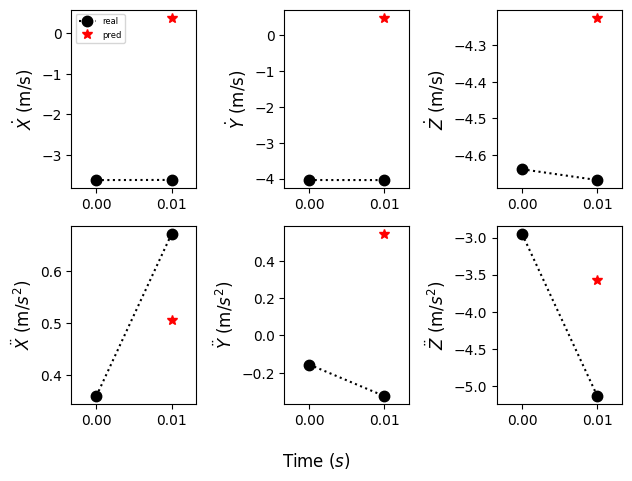

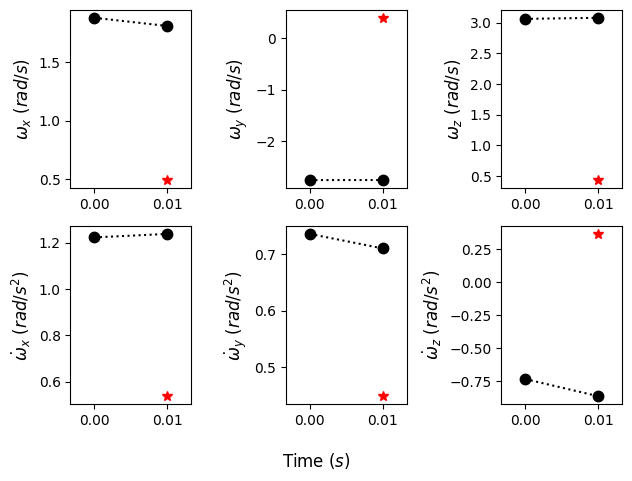

Current Batch Train Loss: 87.09553527832031

Current Batch Train Loss: 83.24186706542969

Current Batch Train Loss: 85.78544616699219

Current Batch Train Loss: 83.22490692138672

Current Batch Train Loss: 85.19795989990234

Current Batch Train Loss: 85.72377014160156

Current Batch Train Loss: 85.02074432373047

Current Batch Train Loss: 85.82735443115234

Current Batch Train Loss: 85.27987670898438

Current Batch Train Loss: 83.66775512695312

Current Batch Train Loss: 83.48279571533203

Current Batch Train Loss: 84.6270980834961

Current Batch Train Loss: 85.52032470703125

Current Batch Train Loss: 83.27079010009766

Current Batch Train Loss: 85.48115539550781

Current Batch Train Loss: 84.0977554321289

Current Batch Train Loss: 83.74279022216797

Current Batch Train Loss: 82.4114990234375

Current Batch Train Loss: 85.12352752685547

Current Batch Train Loss: 85.98065948486328

Current Batch Train Loss: 84.10494995117188

Current Batch Train Loss: 85.36978149414062

Current Batch

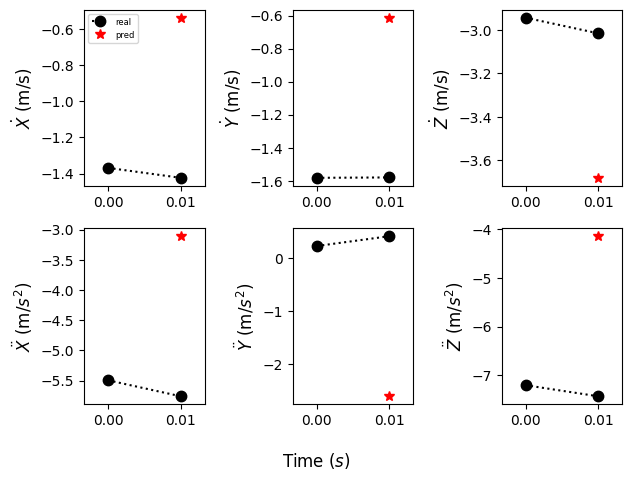

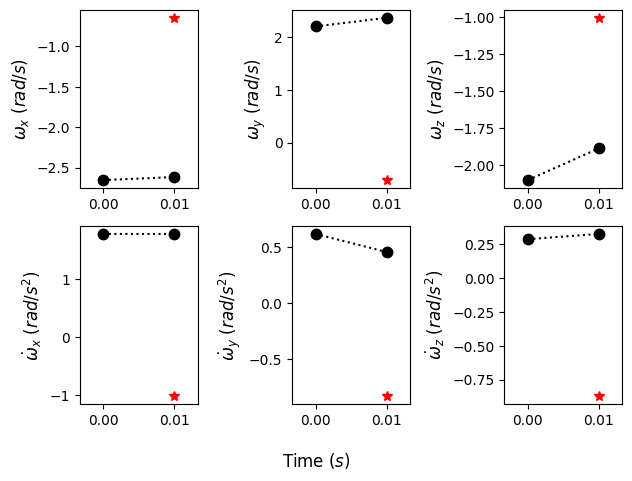

Current Batch Train Loss: 86.54965209960938

Current Batch Train Loss: 83.32861328125

Current Batch Train Loss: 84.1495590209961

Current Batch Train Loss: 86.87611389160156

Current Batch Train Loss: 84.22111511230469

Current Batch Train Loss: 83.62584686279297

Current Batch Train Loss: 84.24404907226562

Current Batch Train Loss: 84.03316497802734

Current Batch Train Loss: 83.98674011230469

Current Batch Train Loss: 83.10350036621094

Current Batch Train Loss: 84.44981384277344

Current Batch Train Loss: 83.60335540771484

Current Batch Train Loss: 84.30118560791016

Current Batch Train Loss: 83.48457336425781

Current Batch Train Loss: 83.18414306640625

Current Batch Train Loss: 84.55110931396484

Current Batch Train Loss: 84.02540588378906

Current Batch Train Loss: 83.79618835449219

Current Batch Train Loss: 84.37454986572266

Current Batch Train Loss: 87.93885803222656

Current Batch Train Loss: 83.2059555053711

Current Batch Train Loss: 85.41159057617188

Current Batch T

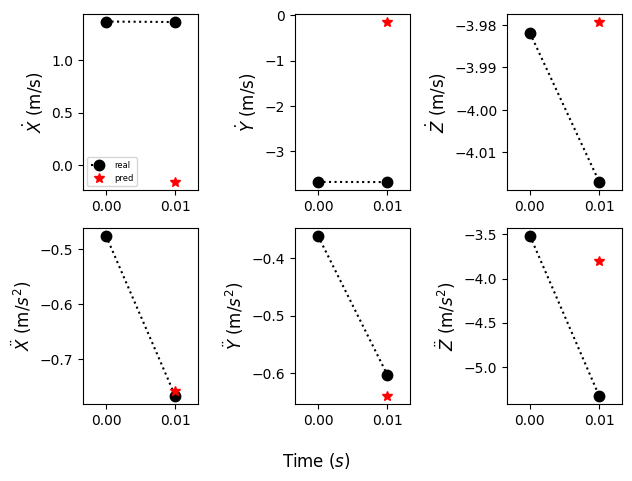

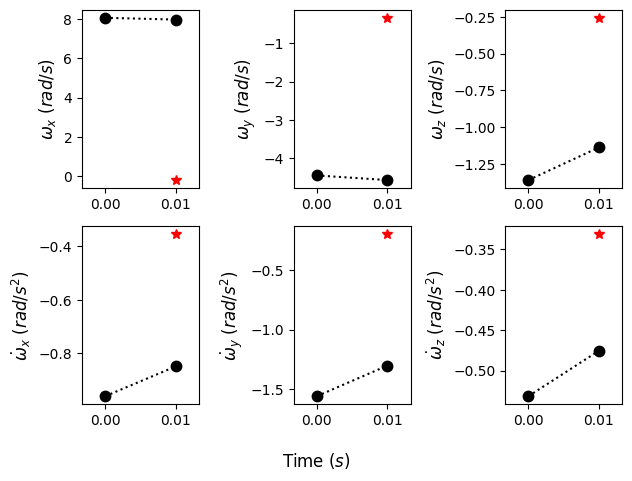

Current Batch Train Loss: 85.50789642333984

Current Batch Train Loss: 82.82215881347656

Current Batch Train Loss: 85.91210174560547

Current Batch Train Loss: 84.9607925415039

Current Batch Train Loss: 84.52120971679688

Current Batch Train Loss: 84.8580551147461

Current Batch Train Loss: 83.31103515625

Current Batch Train Loss: 83.12004089355469

Current Batch Train Loss: 85.6204833984375

Current Batch Train Loss: 83.57701110839844

Current Batch Train Loss: 82.6293716430664

Current Batch Train Loss: 84.2977523803711

Current Batch Train Loss: 82.6180191040039

Current Batch Train Loss: 83.90473937988281

Current Batch Train Loss: 84.88639831542969

Current Batch Train Loss: 84.05175018310547

Current Batch Train Loss: 84.45829772949219

Current Batch Train Loss: 85.8672103881836

Current Batch Train Loss: 84.4894790649414

Current Batch Train Loss: 84.94766235351562

Current Batch Train Loss: 85.29589080810547

Current Batch Train Loss: 85.1608657836914

Current Batch Train Lo

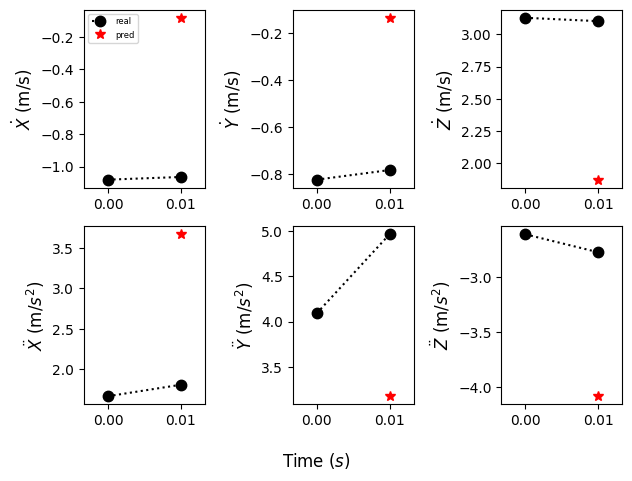

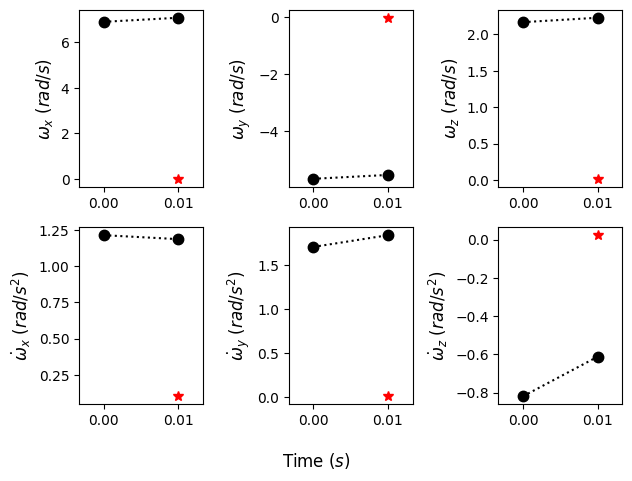

Current Batch Train Loss: 84.11920928955078

Current Batch Train Loss: 85.99932861328125

Current Batch Train Loss: 86.2022476196289

Current Batch Train Loss: 83.99302673339844

Current Batch Train Loss: 87.4431381225586

Current Batch Train Loss: 87.09806060791016

Current Batch Train Loss: 82.50079345703125

Current Batch Train Loss: 84.5434799194336

Current Batch Train Loss: 85.75115966796875

Current Batch Train Loss: 85.36650085449219

Current Batch Train Loss: 85.9876937866211

Current Batch Train Loss: 84.66542053222656

Current Batch Train Loss: 85.73916625976562

Current Batch Train Loss: 84.75635528564453

Current Batch Train Loss: 87.49652099609375

Current Batch Train Loss: 81.59980773925781

Current Batch Train Loss: 84.70125579833984

Current Batch Train Loss: 84.45687866210938

Current Batch Train Loss: 85.58560943603516

Current Batch Train Loss: 85.00743103027344

Current Batch Train Loss: 84.9715576171875

Current Batch Train Loss: 83.7507553100586

Current Batch Tr

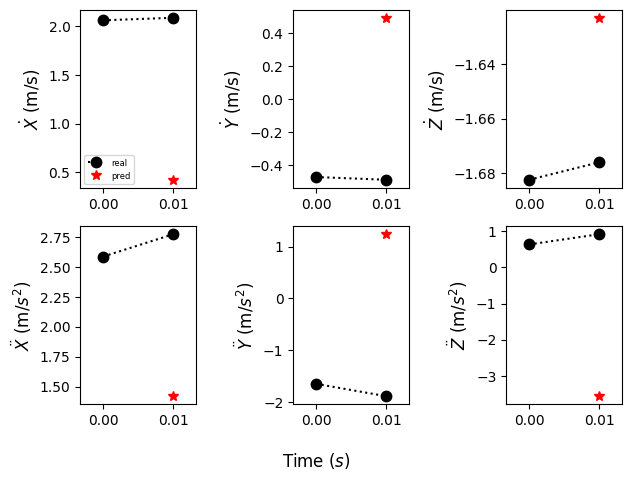

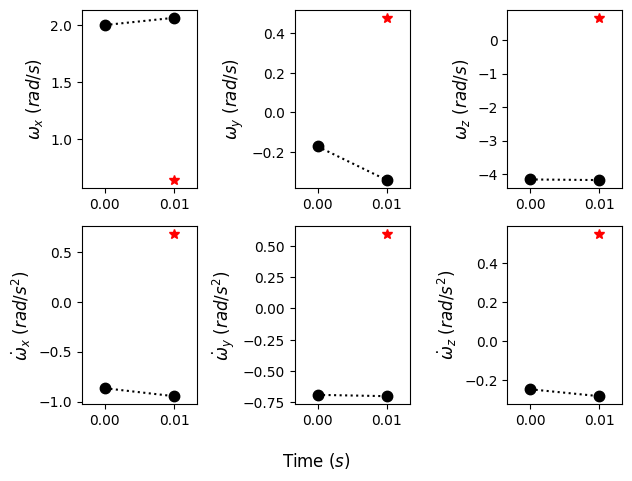

Current Batch Train Loss: 84.87439727783203

Current Batch Train Loss: 85.5576400756836

Current Batch Train Loss: 87.6741943359375

Current Batch Train Loss: 85.14302062988281

Current Batch Train Loss: 84.85784149169922

Current Batch Train Loss: 82.57569122314453

Current Batch Train Loss: 83.93228149414062

Current Batch Train Loss: 83.80306243896484

Current Batch Train Loss: 85.87049865722656

Current Batch Train Loss: 84.54295349121094

Current Batch Train Loss: 85.740966796875

Current Batch Train Loss: 85.41842651367188

Current Batch Train Loss: 84.23513793945312

Current Batch Train Loss: 82.68891906738281

Current Batch Train Loss: 83.91976928710938

Current Batch Train Loss: 84.65172576904297

Current Batch Train Loss: 83.90563201904297

Current Batch Train Loss: 83.71981048583984

Current Batch Train Loss: 85.15788269042969

Current Batch Train Loss: 81.7363510131836

Current Batch Train Loss: 85.74081420898438

Current Batch Train Loss: 82.51053619384766

Current Batch T

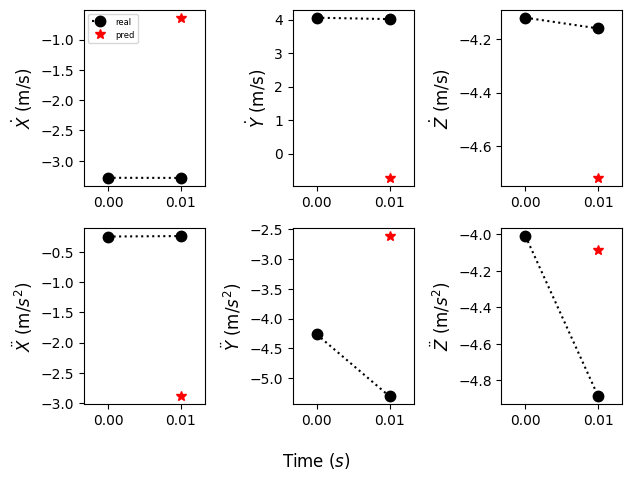

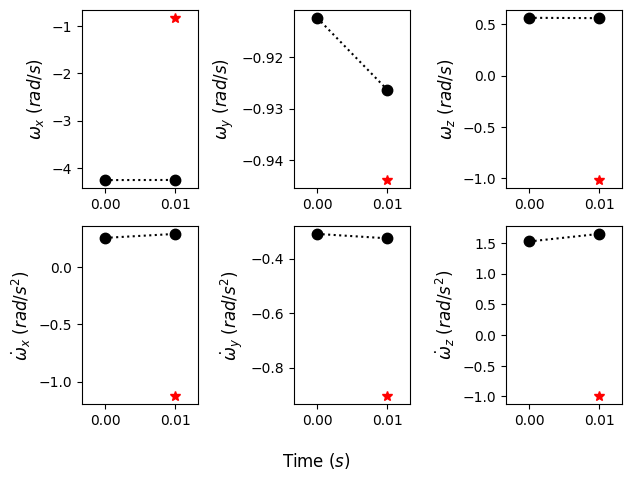

Current Batch Train Loss: 83.49078369140625

Current Batch Train Loss: 84.12325286865234

Current Batch Train Loss: 86.282958984375

Current Batch Train Loss: 84.69910430908203

Current Batch Train Loss: 83.63092041015625

Current Batch Train Loss: 83.33137512207031

Current Batch Train Loss: 84.2695083618164

Current Batch Train Loss: 85.73440551757812

Current Batch Train Loss: 86.47599029541016

Current Batch Train Loss: 84.8364028930664

Current Batch Train Loss: 86.20482635498047

Current Batch Train Loss: 84.87281799316406

Current Batch Train Loss: 84.06819915771484

Current Batch Train Loss: 86.58699035644531

Current Batch Train Loss: 82.69293975830078

Current Batch Train Loss: 85.03317260742188

Current Batch Train Loss: 84.96017456054688

Current Batch Train Loss: 83.73231506347656

Current Batch Train Loss: 84.68276977539062

Current Batch Train Loss: 82.76559448242188

Current Batch Train Loss: 82.01229858398438

Current Batch Train Loss: 84.40287780761719

Current Batch 

KeyboardInterrupt: 

In [16]:
# Initializing PINN model
model = LSTM_PINN(
    input_dim=30,
    output_dim=12,
    num_lstm_layers=2,
    hidden_dim=256
)

#model = torch.load('vel+accel-no-disturbance-no-noise-41-epochs-PINN.pt')

# Initializing model's loss function and optimizer
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=2e-5, amsgrad=True)

# Initializing training + validation loss tracker
train_loss_array = np.array([])
train_iter_array = np.array([])
val_loss_array = np.array([])
val_epoch_array = np.linspace(0, NUM_EPOCHS, NUM_EPOCHS+1)
val_AAE_array = np.array([])

# Initializing training loop
i = 0
for epoch in range(NUM_EPOCHS+1):
  
  if epoch % PLOT_AFTER == 0:

    with torch.no_grad():
      
      # Sampling random validation batch
      idx = random.randint(0, test_dataset.shape[0]-BATCH_SIZE)
      input = torch.concat([test_dataset[idx:idx+BATCH_SIZE,:,:18], test_dataset[idx:idx+BATCH_SIZE,:,24:]], dim=-1)
      #batch_force_and_moments = test_forces_and_moments[idx:idx+BATCH_SIZE,-1,:]
      next_state_vecs = test_dataset[idx:idx+BATCH_SIZE,-1,24:]
      
      prev_unnorm_states = test_dataset_unnorm[idx:idx+BATCH_SIZE,-1,:12]
      add_unnorm_inputs = test_dataset_unnorm[idx:idx+BATCH_SIZE,-1,13:24]
      next_unnorm_states = test_dataset_unnorm[idx:idx+BATCH_SIZE,-1,24:]
      input_unnorm = torch.concat([prev_unnorm_states, add_unnorm_inputs], dim=-1)
      dt_array = test_dataset_unnorm[idx:idx+BATCH_SIZE,-1,12]

      # Collecting batch predicted testing outputs
      pred_state_vecs = model(input)
      
      # Collecting loss from prediction
      loss_test = mse_loss(pred_state_vecs, next_state_vecs) + compute_batch_residuals(input, input_unnorm, dt_array)
      
      # Collecting error info from comparing to ground-truth dynamical data
      pred_state_vecs = db.minmax_unnorm(pred_state_vecs)
      AE_array = compute_AE(next_unnorm_states.detach().numpy(), pred_state_vecs.detach().numpy())
      test_batch_AAE = np.mean(AE_array)
      test_batch_AAE_std = np.std(AE_array)
      
      # Recording performance after every 'PLOT_AFTER' iterations
      print(f"Epoch: {epoch}, Batch Testing Loss: {loss_test}, Batch AAE: {test_batch_AAE} w/ Std Dev: {test_batch_AAE_std}")
      
      # Plotting model prediction results
      plot_all_functions(pred_state_vecs, prev_unnorm_states, next_unnorm_states, dt_array)
      
      # Collecting validation loss history
      val_loss_array = np.concatenate([val_loss_array, np.array([loss_test.item()])], axis=0)
      val_AAE_array = np.concatenate([val_AAE_array, np.array([test_batch_AAE])], axis=0)


  # Executing per-batch training loop
  for batch in range(0, train_dataset.shape[0], BATCH_SIZE):
    # Parsing batch dataset
    input = torch.concat([train_dataset[batch:batch+BATCH_SIZE,:,:18], train_dataset[batch:batch+BATCH_SIZE,:,24:]], dim=-1)
    next_state_vecs = train_dataset[batch:batch+BATCH_SIZE,-1,24:]
    #batch_force_and_moments = train_forces_and_moments[batch:batch+BATCH_SIZE,-1,:]
    
    prev_unnorm_states = train_dataset_unnorm[batch:batch+BATCH_SIZE,-1,:12]
    add_unnorm_inputs = train_dataset_unnorm[batch:batch+BATCH_SIZE,-1,13:24]
    input_unnorm = torch.concat([prev_unnorm_states, add_unnorm_inputs], dim=-1)
    dt_array = train_dataset_unnorm[batch:batch+BATCH_SIZE,-1,12]

    # zero the parameter gradients for each batch
    optimizer.zero_grad()

    # Obtaining batch predictions via forward-prop
    pred_state_vecs = model(input)

    # Collecting loss from prediction
    loss_train = mse_loss(pred_state_vecs, next_state_vecs) + compute_batch_residuals(input, input_unnorm, dt_array)

    # back propogation + optimizer step
    loss_train.backward()
    optimizer.step()

    # Collecting training loss history after every 'COLLECT_LOSS_AFTER' iters
    if i % COLLECT_TRAINING_LOSS_AFTER == 1:
      print(f"Current Batch Train Loss: {loss_train.item()}\n")
      train_loss_array = np.concatenate([train_loss_array, np.array([loss_train.detach()])], axis=0)
      train_iter_array = np.concatenate([train_iter_array, np.array([i])], axis=0)
    i += 1
    
  train_dataset, train_dataset_unnorm = shuffle_data(train_dataset, train_dataset_unnorm)


In [23]:
train_dataset.shape

torch.Size([1500000, 2, 35])

In [19]:
torch.save(model, 'vel+accel-mass-varying-60-epochs-PINN.pt')

### Plotting Loss Histories

Text(0.5, 1.0, 'Training MSE + Residual Loss of Quadrotor Dynamics Predictor')

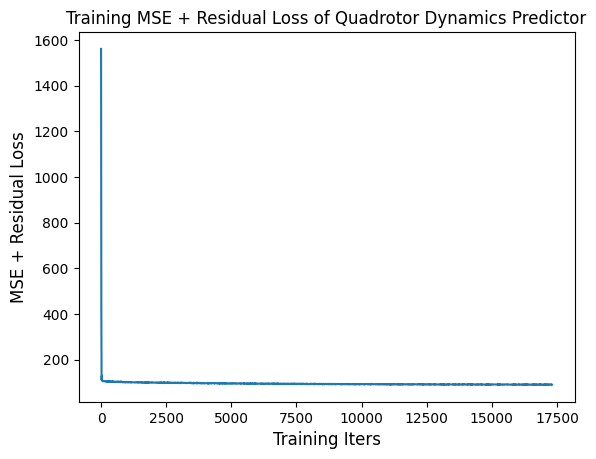

In [24]:
plt.plot(train_iter_array, train_loss_array)
plt.xlabel("Training Iters",fontsize=12), plt.ylabel("MSE + Residual Loss",fontsize=12) 
plt.title("Training MSE + Residual Loss of Quadrotor Dynamics Predictor")

Text(0.5, 1.0, 'Testing MSE + Residual Loss of Quadrotor Dynamics Predictor')

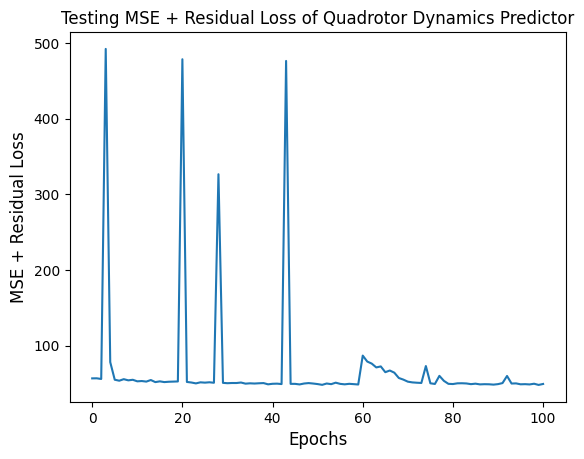

In [38]:
plt.plot(val_epoch_array, val_loss_array)
plt.xlabel("Epochs",fontsize=12), plt.ylabel("MSE + Residual Loss",fontsize=12) 
plt.title("Testing MSE + Residual Loss of Quadrotor Dynamics Predictor")

Text(0.5, 1.0, 'Testing MSE + Residual Loss of Quadrotor Dynamics Predictor')

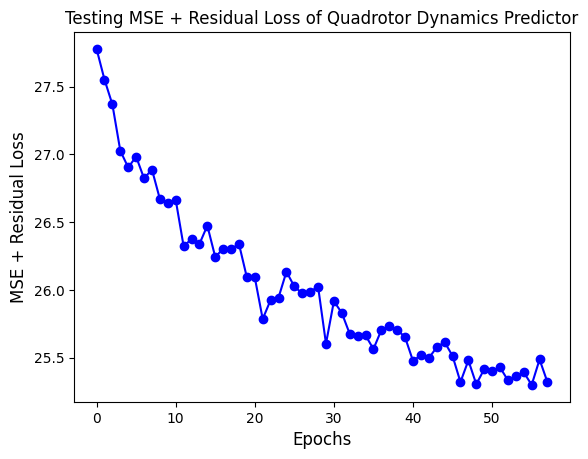

In [26]:
val_epoch_array = np.linspace(0,57,58)

plt.plot(val_epoch_array, val_AAE_array,'-bo')
plt.xlabel("Epochs",fontsize=12), plt.ylabel("MSE + Residual Loss",fontsize=12) 
plt.title("Testing MSE + Residual Loss of Quadrotor Dynamics Predictor")

In [40]:
np.save('AAE_array_PINN-LSTM_pt2', val_AAE_array)

### Evaluation: Trajectory Prediction

In [14]:
def compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  state_diff = np.abs(state_vec - pred_state_vec)
  AE_array = np.sum(state_diff, axis=1)
  
  return AE_array

def scaled_compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  scaled_state_diff = np.abs((state_vec - pred_state_vec) / state_vec) * 100
  scaled_AE_array = np.mean(scaled_state_diff)

  return scaled_AE_array

In [209]:
# Initializing models used in evaluation
model1 = torch.load('vel+accel-no-disturbance-no-noise-100epochs-PINN-pt2.pt')
#model2 = torch.load('large-ss-medium-disturbance-medium-noise-model.pt')
#model3 = torch.load('large-ss-slow-vel-low-noise-model.pt')
model_list = [model1]
num_models = len(model_list)

# Initializing quadrotor sensor noise/disturbance parameters
'''
num_perturb_profiles = 1
perturb_params = np.zeros([num_perturb_profiles,6])
rotor_spike_profile = 100 * np.ones([num_perturb_profiles,]) #np.linspace(0,100,num_perturb_profiles)
gps_bias_profile = 1e-2 * np.ones([num_perturb_profiles,]) #np.linspace(0, 0.2, num_perturb_profiles)
gps_std_profile = 1e-1 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,0.6,num_perturb_profiles)
gyro_bias_profile = 1e-3 * np.ones([num_perturb_profiles,]) #np.linspace(0,0.5,num_perturb_profiles)
gyro_std_profile = 1e-5 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,1e-2,num_perturb_profiles)
disturb_quad_at_array = 100#np.linspace(1,100,num_perturb_profiles)

perturb_params[:,0] = rotor_spike_profile
perturb_params[:,1] = gps_bias_profile
perturb_params[:,2] = gps_std_profile
perturb_params[:,3] = gyro_bias_profile
perturb_params[:,4] = gyro_std_profile
perturb_params[:,5] = disturb_quad_at_array
'''

# Sampling random trajectory data 
sample_length = 100
test_db = Quadrotor_Dynamics_Generator()
#test_traj = test_db.generate_test_traj(seq_length=sample_length, gaussian_noise=True)
#test_traj = test_traj.unsqueeze(dim=0)
test_traj = torch.from_numpy(np.load('test_traj_GT.npy'))
test_traj = test_db.minmax_norm(test_traj)
test_AAE_array = np.zeros([num_models, sample_length])

# Defining test trajectory time array
time_array = np.zeros([sample_length,])

# Initializing array that will contain model predictions
eval_data = torch.zeros([num_models, 2, sample_length, 12])
eval_data[:,0:1,0:1,:] = torch.tile(torch.unsqueeze(test_traj[0:1,0:1,:12], dim=0), dims=[num_models, 1, 1, 1])


# Initializing plotting parameters
Xdot = np.zeros([num_models, sample_length])
Ydot = np.zeros([num_models, sample_length])
Zdot = np.zeros([num_models, sample_length])
ωx = np.zeros([num_models, sample_length])
ωy = np.zeros([num_models, sample_length])
ωz = np.zeros([num_models, sample_length])
Xdot_pred = np.zeros([num_models, sample_length])
Ydot_pred = np.zeros([num_models, sample_length])
Zdot_pred = np.zeros([num_models, sample_length])
ωx_pred = np.zeros([num_models, sample_length])
ωy_pred = np.zeros([num_models, sample_length])
ωz_pred = np.zeros([num_models, sample_length])

'''
Xdot_var = np.zeros([num_models, sample_length])
Ydot_var = np.zeros([num_models, sample_length])
Zdot_var = np.zeros([num_models, sample_length])
ωx_var = np.zeros([num_models, sample_length])
ωy_var = np.zeros([num_models, sample_length])
ωz_var = np.zeros([num_models, sample_length])
'''

# Looping through entire test trajectory
for nn in range(num_models):

  # Setting 'curr_model' to next model in list
  curr_model = model_list[nn]
  
  # Resetting time counter
  curr_time = 0

  for i in range(sample_length):

    curr_sample = test_traj[i:i+1,:,:]
    #curr_sample[:,0:1,8:] = next_context

    curr_dt = curr_sample[:,1:2,0]
    curr_time += curr_dt 
    time_array[i] = curr_time.detach().numpy()
    
    input = torch.concat([curr_sample[:,:,:17], curr_sample[:,:,26:]], dim=-1)
    #batch_force_and_moments = test_forces_and_moments[idx:idx+BATCH_SIZE,-1,:]
    next_state_vecs = curr_sample[:,-1,26:]

    # Collecting batch predicted testing outputs
    pred_state_vecs = curr_model(input)

    # Computing AE of current prediction
    pred_state_vecs = db.minmax_unnorm(pred_state_vecs)
    next_state_vecs = db.minmax_unnorm(next_state_vecs)
    AE_array = compute_AE(next_state_vecs.detach().numpy(), pred_state_vecs.detach().numpy())
    test_AAE_array[nn, i] = AE_array

    eval_data[nn,0:1,i,:] = next_state_vecs
    eval_data[nn,1:2,i,:] = pred_state_vecs

    #next_context = test_traj[i:i+1,1:2,8:] #pred_y[:,1:2,:]


  # Unnormalizing true states, their predictions, and associated variances for plotting
  Xdot[nn,:] = eval_data[nn,0,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0]) + minmax_data[8,0]).detach().numpy()
  Ydot[nn,:] = eval_data[nn,0,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0]) + minmax_data[9,0]).detach().numpy()
  Zdot[nn,:] = eval_data[nn,0,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0]) + minmax_data[10,0]).detach().numpy()

  Xdot_pred[nn,:] = eval_data[nn,1,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0]) + minmax_data[8,0]).detach().numpy()
  Ydot_pred[nn,:] = eval_data[nn,1,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0]) + minmax_data[9,0]).detach().numpy()
  Zdot_pred[nn,:] = eval_data[nn,1,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0]) + minmax_data[10,0]).detach().numpy()
  
  ωx[nn,:] = eval_data[nn,0,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy()
  ωy[nn,:] = eval_data[nn,0,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy()
  ωz[nn,:] = eval_data[nn,0,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy()
  
  ωx_pred[nn,:] = eval_data[nn,1,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy()
  ωy_pred[nn,:] = eval_data[nn,1,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy()
  ωz_pred[nn,:] = eval_data[nn,1,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy()
  
  '''
  Xdot_var[nn,:] = eval_data[nn,2,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0])).detach().numpy())
  Ydot_var[nn,:] = eval_data[nn,2,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0])).detach().numpy())
  Zdot_var[nn,:] = eval_data[nn,2,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0])).detach().numpy())
  
  ωx_var[nn,:] = eval_data[nn,2,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy())
  ωy_var[nn,:] = eval_data[nn,2,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy())
  ωz_var[nn,:] = eval_data[nn,2,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy())
  '''

model_AAE_array = np.mean(test_AAE_array, axis=1)
#print(f"AAE Results\nNo Noise/Disturbance: {model_AAE_array[2]}, Medium Noise/Disturbance: {model_AAE_array[1]}, High Noise/Disturbance: {model_AAE_array[0]}")

/tmp/ipykernel_293496/66819652.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_array[i] = curr_time.detach().numpy()
/tmp/ipykernel_293496/66819652.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_AAE_array[nn, i] = AE_array


In [210]:
model_AAE_array

array([18.66609091])

In [123]:
# Defining length of plotted trajectories (ensure its <= to sample_length)
plt_idx = 120

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{X}$ (m/s)'))

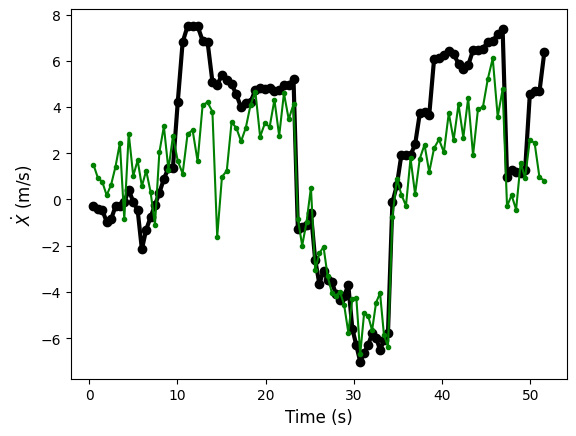

In [211]:
plt.plot(time_array[:plt_idx], Xdot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Xdot_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], X_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx] - Xdot_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx] + Xdot_var[0,:plt_idx], '--r')


plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{X}$ (m/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{Y}$ (m/s)'))

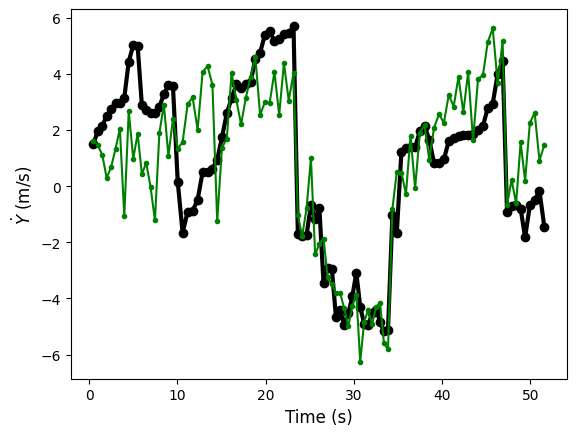

In [212]:
plt.plot(time_array[:plt_idx], Ydot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Y_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Y_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx] - Ydot_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx] + Ydot_var[0,:plt_idx], '--r')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{Y}$ (m/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{Z}$ (m/s)'))

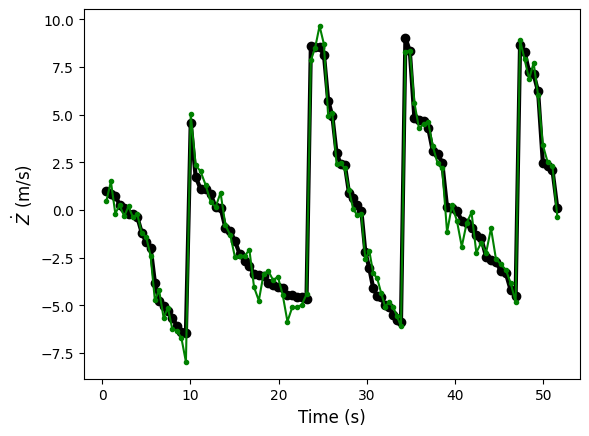

In [205]:
plt.plot(time_array[:plt_idx], Zdot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx] - Zdot_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx] + Zdot_var[0,:plt_idx], '--r')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{Z}$ (m/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{\\omega}_{x}$ (rad/s)'))

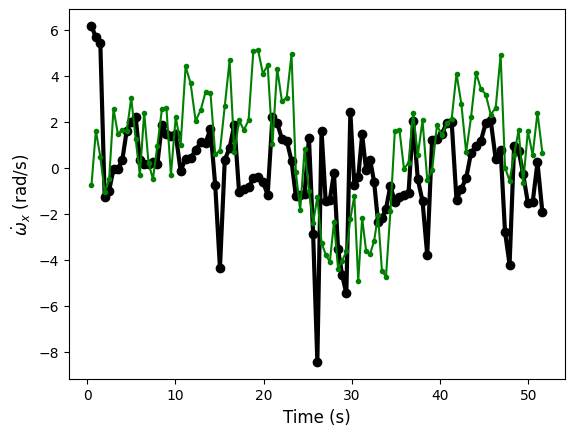

In [206]:
plt.plot(time_array[:plt_idx], ωx[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx] - ωx_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx] + ωx_var[0,:plt_idx], '--r')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{\omega}_{x}$ (rad/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{\\omega}_{y}$ (rad/s)'))

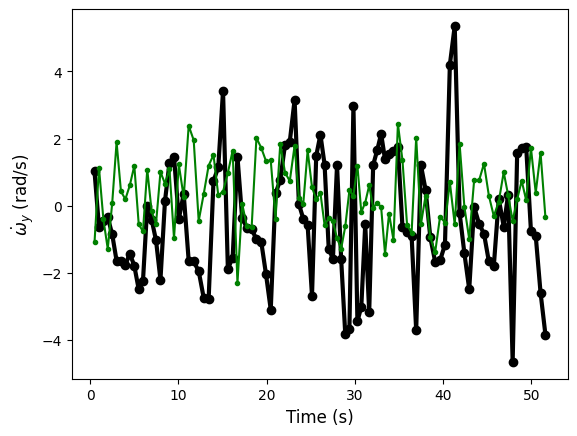

In [207]:
plt.plot(time_array[:plt_idx], ωy[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx] - ωy_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx] + ωy_var[0,:plt_idx], '--r')

#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{\omega}_{y}$ (rad/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{\\omega}_{z}$ (rad/s)'))

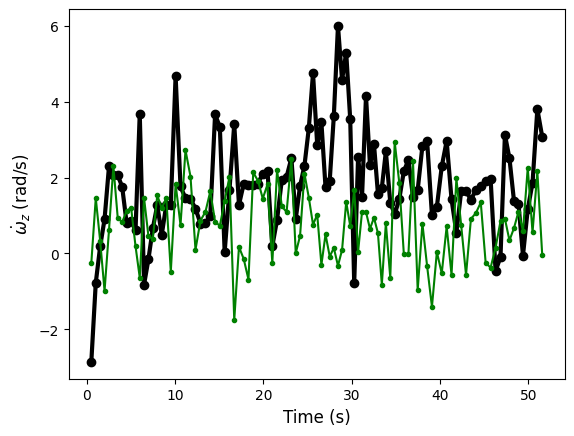

In [208]:
plt.plot(time_array[:plt_idx], ωz[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx] - ωz_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx] + ωz_var[0,:plt_idx], '--r')


#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{\omega}_{z}$ (rad/s)", fontsize=12)

In [213]:
np.save('test_traj_xdot_DKF.npy', Xdot_pred)
np.save('test_traj_ydot_DKF.npy', Ydot_pred)
np.save('test_traj_zdot_DKF.npy', Zdot_pred)
np.save('test_traj_ωx_DKF.npy', ωx_pred)
np.save('test_traj_ωy_DKF.npy', ωy_pred)
np.save('test_traj_ωz_DKF.npy', ωz_pred)

In [21]:
# Initializing model
model = torch.load('vel+accel-mass-varying-60-epochs-PINN.pt')

# Defining array of quadrotor mass values used in evaluation
min_m = 0.5
max_m = 20
num_inertial_profiles = 100
mass_array = torch.linspace(min_m, max_m, num_inertial_profiles)

# Sampling random trajectory data 
sample_length = 10
num_trajs = 20
test_db = Quadrotor_Dynamics_Generator(normalize=True)

#test_traj = test_traj.unsqueeze(dim=0)
test_AAE_array = np.zeros([num_inertial_profiles, sample_length*num_trajs])

# Defining test trajectory time array
time_array = np.zeros([sample_length,])

# Looping through entire test trajectory
for profile in range(num_inertial_profiles):
    
    curr_m = mass_array[profile]
    
    count = 0
    for traj in range(num_trajs):
        
        # Sampling random trajectory data 
        test_traj = test_db.generate_test_traj(seq_length=sample_length, mass=curr_m)
        
        # Resetting time counter
        curr_time = 0
        
        for i in range(sample_length):

            curr_sample = test_traj[i:i+1,:,:]
            #curr_sample[:,0:1,8:] = next_context

            curr_dt = curr_sample[:,1:2,12]
            curr_time += curr_dt 
            time_array[i] = curr_time.detach().numpy()
            
            input = torch.concat([curr_sample[:,:,:18], curr_sample[:,:,24:]], dim=-1)
            #batch_force_and_moments = test_forces_and_moments[idx:idx+BATCH_SIZE,-1,:]
            next_state_vecs = curr_sample[:,-1,24:]

            # Collecting batch predicted testing outputs
            pred_state_vecs = model(input)

            # Computing AE of current prediction
            pred_state_vecs = test_db.minmax_unnorm(pred_state_vecs)
            next_state_vecs = test_db.minmax_unnorm(next_state_vecs)
            AE_array = compute_AE(next_state_vecs.detach().numpy(), pred_state_vecs.detach().numpy())
            test_AAE_array[profile, count] = AE_array
            count += 1

/tmp/ipykernel_5181/1993548762.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_array[i] = curr_time.detach().numpy()
/tmp/ipykernel_5181/1993548762.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_AAE_array[profile, count] = AE_array


In [23]:
test_AAE_array

array([[29.07206154, 28.36310387, 25.92452049, ..., 16.22526741,
        16.84186554, 20.44391441],
       [20.50863266, 19.58277512, 21.41500282, ..., 15.74259567,
        17.90173149, 27.27220917],
       [17.26084709, 17.37035751, 13.46535873, ..., 15.15974236,
        19.40386581, 18.36435318],
       ...,
       [27.2977829 , 18.17666817, 19.75189018, ..., 23.03159714,
        31.31239891, 33.19539642],
       [25.20828629, 26.21584892, 17.18332672, ..., 20.33385277,
        25.62427521, 23.90623474],
       [22.88911819, 22.84917641, 21.16743469, ..., 18.78668594,
        18.51714706, 35.32288742]])

In [24]:
mass_AAE_array = np.mean(test_AAE_array,axis=1)

mass_AAE_array

array([23.72658552, 21.87229059, 19.69706372, 22.48944976, 21.1635911 ,
       21.12762335, 19.79428324, 19.64917482, 19.67314993, 18.85433735,
       19.89456305, 19.60404827, 22.78053401, 20.56654012, 21.48801429,
       20.73541368, 20.17411655, 20.16540812, 21.67191469, 18.89020935,
       20.05155981, 19.04399203, 19.0908824 , 18.9086832 , 21.13416173,
       19.14476686, 19.33173399, 20.1248999 , 19.14976266, 18.3369394 ,
       21.12378707, 21.15439832, 18.66436306, 20.60084991, 22.03610497,
       23.40136612, 20.42567722, 18.56752447, 19.5675107 , 21.14165658,
       19.44838379, 19.24043106, 21.49987308, 22.97326758, 20.25863414,
       20.9692064 , 19.57909321, 19.55985538, 18.98288164, 21.84518161,
       22.6926534 , 20.38751695, 21.20054308, 18.95359872, 19.98031962,
       19.614322  , 20.10451469, 20.81741078, 19.92605509, 20.61387432,
       20.08493037, 19.46367499, 20.19663261, 21.44525224, 22.99755884,
       25.14548913, 19.98467295, 18.43015085, 22.30609643, 20.81

In [27]:
np.save('PINN_AAE_array_MassVary.npy', mass_AAE_array)

In [26]:
test_traj[:,:,17]

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [35]:
perturb_AAE_array = np.mean(test_AAE_array,axis=1)
np.save('DKF-AAE-Perturb-array.npy', perturb_AAE_array)